# Notebook for generating the figures of: "Resting State Functional Connectivity Demonstrates Increased Segregation in Bilateral Temporal Lobe Epilepsy" by Lucas et. al.

Importing relevant functions and plotting settings

In [22]:
# plot settings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from statsmodels.stats import multitest
from scipy import stats
from sklearn.decomposition import PCA
from neuroCombat import neuroCombat
import pandas as pd
from sklearn import preprocessing
import bct
from tqdm import tqdm
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE, family='Arial')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


label_params = {'size':14, 'weight':'normal'}
title_params = {'size':16, 'weight':'bold'}

Functions for matching network densities

In [23]:
def match_density(fcon, density, print_thresh=False):
    fcon = np.abs(fcon)
    def calc_density(binary):
        density = np.sum(binary)/(binary.shape[0]*(binary.shape[0]-1))
        return density
    density_list = []
    thresh = np.arange(0,0.99,0.01)
    for i in range(len(thresh)):
        binary = (fcon>np.arctanh(thresh[i])).astype(int)
        density_list.append(calc_density(binary))
    density_list = np.array(density_list)
    thresh_idx = np.argmin(np.abs(density_list-density))
    if print_thresh==True:
        print(thresh[thresh_idx])
    return (fcon>np.arctanh(thresh[thresh_idx])).astype(int)


Functions for plotting different network metrics and performing statistical analysis

In [46]:
# calculating Cohen's D
def cohend(x1,x2):
        u1 = np.mean(x1)
        u2 = np.mean(x2)
        var1 = np.var(x1)
        var2 = np.var(x2)
        n1 = len(x1)
        n2 = len(x2)
        s1 = var1
        s2 = var2
        # calculate the pooled standard deviation
        s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
        # calculate the means of the samples
        return (u1 - u2) / s

def plot_metrics(df_network_metrics1, df_network_metrics2,metric, save=False):
    
    mean_vals = np.mean(df_network_metrics1[metric].values, axis=0)
    std_vals = np.std(df_network_metrics1[metric].values, axis=0)
    n_subjects = np.array(df_network_metrics1[metric]).shape[0]
    conf = std_vals*(1.96)/(np.sqrt(n_subjects))
    densities = np.arange(0.1,0.5,0.01)
    plt.fill_between(densities, mean_vals+conf, mean_vals-conf, alpha=0.3)
    plt.plot(densities, mean_vals,'-', linewidth=2)

    df_network_metrics1 = df_network_metrics2
    mean_vals = np.mean(df_network_metrics1[metric].values, axis=0)
    std_vals = np.std(df_network_metrics1[metric].values, axis=0)
    n_subjects = np.array(df_network_metrics1[metric]).shape[0]
    conf = std_vals*(1.96)/(np.sqrt(n_subjects))
    densities = np.arange(0.1,0.5,0.01)
    plt.fill_between(densities, mean_vals+conf, mean_vals-conf, alpha=0.3)
    plt.plot(densities, mean_vals,'-', linewidth=2)
    
    plt.legend(['G1','-','G2','-'])

    plt.ylabel(metric + ' (a.u.)', weight='bold', size=14)
    plt.xlabel('Density (a.u.)',weight='bold', size=14)
    plt.title(metric, weight='bold', size=16)
    sns.despine()

def plot_metrics_fill(df_network_metrics_density, metric, by, save=False):
    groups = list(set(list(df_network_metrics_density[by].values)))
    if len(groups)==2:
        colors=['#ED5435','#56B894']
    for i in range(len(groups)):
        mean_vals = np.mean(df_network_metrics_density[df_network_metrics_density[by]==groups[i]][metric].values, axis=0)
        std_vals = np.std(df_network_metrics_density[df_network_metrics_density[by]==groups[i]][metric].values, axis=0)
        n_subjects = np.array(df_network_metrics_density[df_network_metrics_density[by]==groups[i]][metric]).shape[0]
        conf = std_vals*(1.96)/(np.sqrt(n_subjects))
        densities = np.arange(0.1,0.5,0.01)
        plt.fill_between(densities, mean_vals+conf, mean_vals-conf, alpha=0.3, color=colors[i])
        plt.plot(densities, mean_vals,'-', color=colors[i])

    plt.legend(['','Unilateral','','Bilateral'])

    plt.ylabel(metric + ' (a.u.)', weight='bold', size=14)
    plt.xlabel('Density (a.u.)',weight='bold', size=14)
    plt.title(metric, weight='bold', size=16)
    sns.despine()

# Statistics Functions

def get_cluster_sizes(bin_mask):
    cluster_sizes = [0]
    count = 0
    for i in bin_mask:
        if i == 1:
            count += 1
        elif count > 0:
            cluster_sizes.append(count)
            count = 0
        else:
            count = 0
    cluster_sizes.append(count)
    return cluster_sizes

def get_fdr(df_epilepsy, metric, on, thresh=0.05):

    a = np.vstack(df_epilepsy[df_epilepsy[on]==True][metric].values)
    b = np.vstack(df_epilepsy[df_epilepsy[on]==False][metric].values)

    t,p = stats.ttest_ind(a, b, axis=0)
    rejected, corr_p = multitest.fdrcorrection(p, alpha=thresh)
    return rejected


def get_suprathreshold_cluster_stat(df_network_metrics_density, metric, by, thresh1=0.05,thresh2=0.05, n_iters=1000):
    # Compute the maximum threshold in the original data
    groups = list(set(list(df_network_metrics_density[by])))
    a = df_network_metrics_density[df_network_metrics_density[by] == groups[0]][metric]
    b = df_network_metrics_density[df_network_metrics_density[by] == groups[1]][metric]
    a = np.vstack(list(a))
    b = np.vstack(list(b))
    t_orig, p_orig = scipy.stats.ttest_ind(a, b, axis=0)

    t_crit = scipy.stats.t.ppf(q=1 - (thresh1/2), df=(a.shape[0]+b.shape[0]-2))

    max_cluster_size = np.max(get_cluster_sizes((np.abs(t_orig)>t_crit).astype(int)))

    g1_size = a.shape[0]
    g2_size = b.shape[0]
    max_cluster_size_shuffled = []
    for i in range(n_iters):
        merged_ab = np.vstack([a, b])
        np.random.shuffle(merged_ab)
        a_shuffled = merged_ab[:g1_size,:]
        b_shuffled = merged_ab[g1_size:(g1_size+g2_size),:]
        t_shuffled, p_shuffled = scipy.stats.ttest_ind(a_shuffled, b_shuffled, axis=0)
        max_cluster_size_shuffled.append(np.max(get_cluster_sizes((np.abs(t_shuffled)>t_crit).astype(int))))
    max_cluster_permuted = np.sort(max_cluster_size_shuffled)[::-1][int(thresh2*n_iters)]
    
    # Calculate the p-value
    p_perm = (np.sum(max_cluster_size_shuffled>max_cluster_size)+1)/(n_iters+1)
    
    if max_cluster_size>max_cluster_permuted:
        print('Significant: ',max_cluster_size,'>',max_cluster_permuted,', p-value: ', p_perm)
    else:
        print('Not significant: ', max_cluster_size, '<', max_cluster_permuted, ', p-value: ', p_perm)
    return p_orig

def plot_communities_fill(df_network_metrics_density, metric, by, save=False):
    groups = list(set(list(df_network_metrics_density[by].values)))
    if len(groups)==2:
        colors=['#ED5435','#56B894']
    for i in range(len(groups)):
        mean_vals = np.mean(df_network_metrics_density[df_network_metrics_density[by]==groups[i]][metric].values, axis=0)
        std_vals = np.std(df_network_metrics_density[df_network_metrics_density[by]==groups[i]][metric].values, axis=0)
        n_subjects = np.array(df_network_metrics_density[df_network_metrics_density[by]==groups[i]][metric]).shape[0]
        conf = std_vals*(1.96)/(np.sqrt(n_subjects))
        densities = np.arange(0.5,3,0.1)
        plt.fill_between(densities, mean_vals+conf, mean_vals-conf, alpha=0.3, color=colors[i])
        plt.plot(densities, mean_vals,'-', color=colors[i])

    plt.legend(['Unilateral','Bilateral'])

    plt.ylabel('Number of Communities Detected', weight='bold', size=12)
    plt.xlabel('$\gamma$',weight='bold', size=12)
    plt.title(metric, weight='bold', size=12)
    sns.despine()

Loading the functional connectivity dataframe from the `/data` folder

In [4]:
# Penn Un-Harm
f = open('../data/df_epilepsy_penn_uol_unharm.p', 'rb')
df_epilepsy_unharm = pickle.load(f)

f = open('../data/df_control_penn_uol_unharm.p', 'rb')
df_control_unharm = pickle.load(f)

#### Functions for Harmonizing Each Network Metric Independently

In [5]:
# Function for harmonizing each network metric separately
def harmonize_batch_only(X, scanner_list, lat_list):
    # Getting example data
    # 200 rows (features) and 10 columns (scans)
    data = X
    data = data.T
    # Specifying the batch (scanner variable) as well as a biological covariate to preserve:
    batch = scanner_list

    le = preprocessing.LabelEncoder()
    lat_list = le.fit_transform(lat_list)
    print(lat_list)
    covars = {'batch': batch, 'lat': lat_list}
    covars = pd.DataFrame(covars)


    # To specify names of the variables that are categorical:
    categorical_cols = ['lat']

    # To specify the name of the variable that encodes for the scanner/batch covariate:
    batch_col = 'batch'

    # Harmonization step:
    data_combat = neuroCombat(dat=data,
                              covars=covars,
                              batch_col=batch_col, categorical_cols=categorical_cols)["data"]

    
    data_combat_reshaped = data_combat.T
    return data_combat_reshaped

def listify(arr):
    # convert 2d-array into a list of arrays
    arr_list = []
    for i in range(len(arr)):
        arr_list.append(arr[i,:])
    return arr_list

# Part 1: Average Clustering, betweeness, degree and global efficiency

#### Harmonizing the metrics independently

In [6]:
df_epilepsy_unharm['Average Clustering - Harmonized'] = listify(harmonize_batch_only(np.vstack(df_epilepsy_unharm['Average Clustering']), df_epilepsy_unharm['version'].values, df_epilepsy_unharm['Bilateral'].values))
df_epilepsy_unharm['Global Efficiency - Harmonized'] = listify(harmonize_batch_only(np.vstack(df_epilepsy_unharm['Global Efficiency']), df_epilepsy_unharm['version'].values, df_epilepsy_unharm['Bilateral'].values))
df_epilepsy_unharm['Average Betweeness - Harmonized'] = listify(harmonize_batch_only(np.vstack(df_epilepsy_unharm['Average Betweeness']), df_epilepsy_unharm['version'].values, df_epilepsy_unharm['Bilateral'].values))
df_epilepsy_unharm['Average Degree - Harmonized'] = listify(harmonize_batch_only(np.vstack(df_epilepsy_unharm['Average Degree']), df_epilepsy_unharm['version'].values, df_epilepsy_unharm['Bilateral'].values))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0

#### Plotting the network metrics

Text(-0.48, 0.765, 'C.')

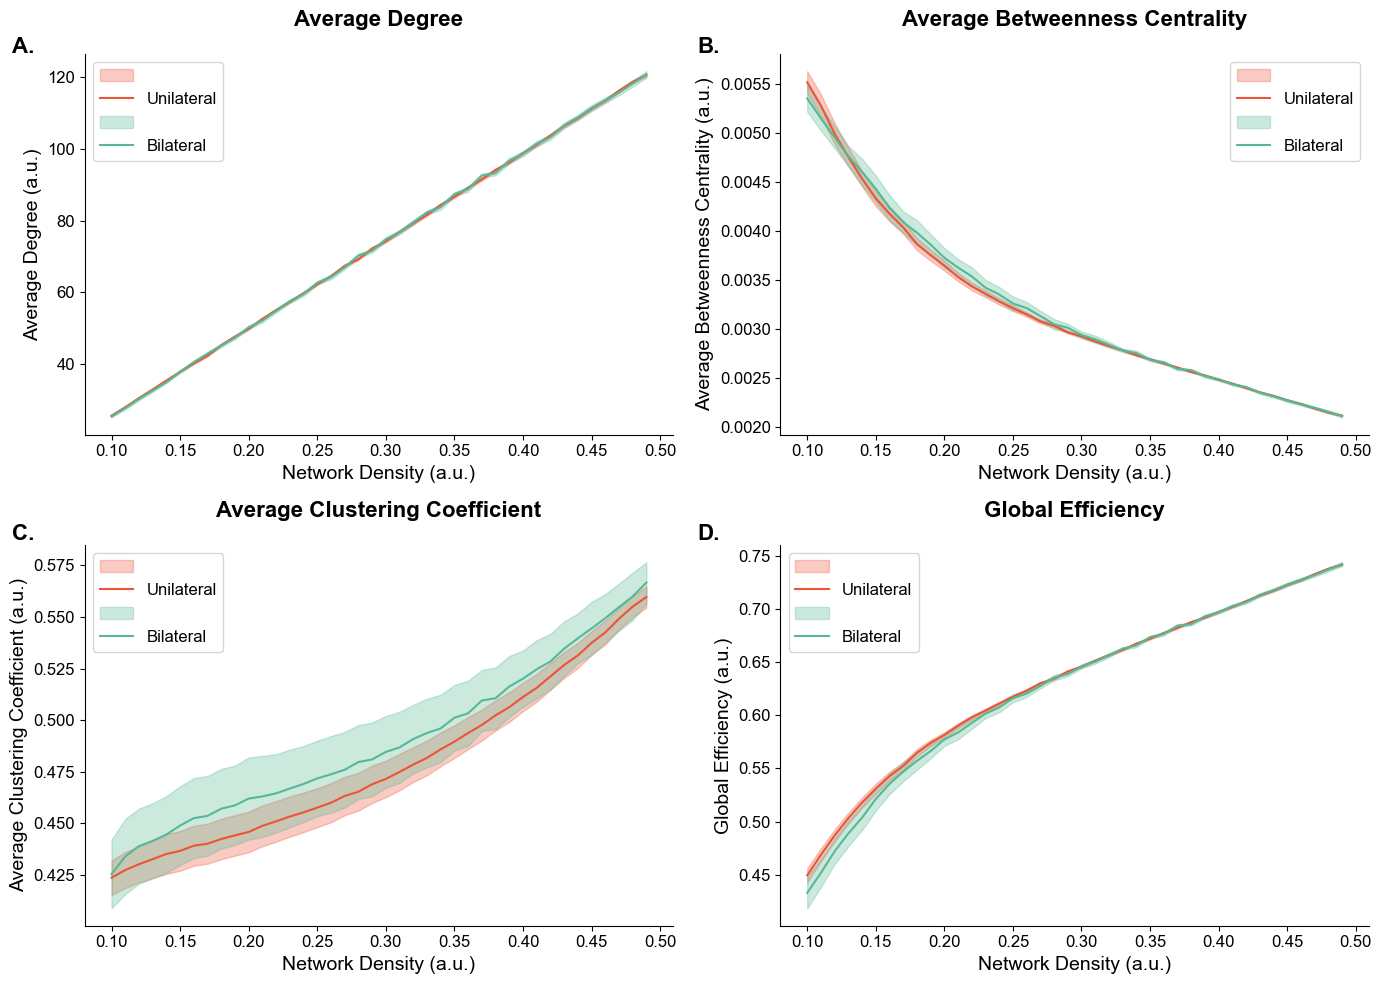

In [7]:


plt.figure(figsize=(14,10))
plt.subplot(221)
#plt.text(-0.1,2,'A')
plot_metrics_fill(df_epilepsy_unharm,'Average Degree - Harmonized','Bilateral')
plt.ylabel('Average Degree (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Average Degree', title_params, pad=20)

plt.subplot(222)
plot_metrics_fill(df_epilepsy_unharm,'Average Betweeness - Harmonized','Bilateral')
plt.ylabel('Average Betweenness Centrality (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Average Betweenness Centrality', title_params, pad=20)

plt.subplot(223)
plot_metrics_fill(df_epilepsy_unharm,'Average Clustering - Harmonized','Bilateral')
plt.ylabel('Average Clustering Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Average Clustering Coefficient', title_params, pad=20)

plt.subplot(224)
plot_metrics_fill(df_epilepsy_unharm,'Global Efficiency - Harmonized','Bilateral')
plt.ylabel('Global Efficiency (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Global Efficiency', title_params, pad=20)

plt.tight_layout()
plt.text(-0.48,1.225,'A.',title_params)
plt.text(0.02,1.225,'B.',title_params)
plt.text(0.02,0.765,'D.',title_params)
plt.text(-0.48,0.765,'C.',title_params)


#### Computing the statistics for each metric

In [8]:
print('Global Efficiency')
get_suprathreshold_cluster_stat(df_epilepsy_unharm,'Global Efficiency - Harmonized','Bilateral')

Global Efficiency
Significant:  5 > 3 , p-value:  0.029970029970029972


array([0.03854044, 0.02004461, 0.02712477, 0.02114368, 0.01440748,
       0.08657016, 0.13134178, 0.23765071, 0.07258817, 0.02828884,
       0.17053111, 0.02942383, 0.04112696, 0.18248111, 0.07310993,
       0.43408872, 0.04979245, 0.05439302, 0.43686066, 0.01353795,
       0.79218197, 0.34900686, 0.90559242, 0.16144013, 0.07273141,
       0.0740875 , 0.23180678, 0.01723372, 0.02038259, 0.20191436,
       0.62371273, 0.42809208, 0.27331029, 0.59513884, 0.6231516 ,
       0.7323509 , 0.7034119 , 0.37593579, 0.38645045, 0.68700907])

In [9]:
print('Average Clustering')

get_suprathreshold_cluster_stat(df_epilepsy_unharm,'Average Clustering - Harmonized','Bilateral')

Average Clustering
Not significant:  0 < 14 , p-value:  0.12287712287712288


array([0.85410748, 0.51779222, 0.39191304, 0.39911577, 0.39469903,
       0.26802716, 0.23287359, 0.22862467, 0.19380101, 0.19847136,
       0.15603622, 0.21175399, 0.22771472, 0.22460886, 0.21106962,
       0.1919238 , 0.20620118, 0.23529614, 0.17118392, 0.24992993,
       0.19854589, 0.24057603, 0.20387005, 0.21406284, 0.28136561,
       0.20690339, 0.28616375, 0.17150373, 0.32744769, 0.23218281,
       0.26407743, 0.24886058, 0.33704898, 0.2818643 , 0.23745861,
       0.29978147, 0.30726254, 0.3572677 , 0.42126786, 0.23253734])

In [10]:
print('Average Betweenness')

get_suprathreshold_cluster_stat(df_epilepsy_unharm,'Average Betweeness - Harmonized','Bilateral')

Average Betweenness
Not significant:  2 < 5 , p-value:  0.09490509490509491


array([0.17916415, 0.27052458, 0.76239284, 0.93490122, 0.43747166,
       0.27680645, 0.44916923, 0.46239631, 0.1112979 , 0.09534519,
       0.16593499, 0.05777265, 0.03170873, 0.13243084, 0.06740101,
       0.17821249, 0.02276543, 0.02544848, 0.51349823, 0.01003897,
       0.36194282, 0.08942781, 0.31425573, 0.82819691, 0.01645936,
       0.35683875, 0.10869674, 0.06716834, 0.01118625, 0.30442266,
       0.50675223, 0.44942738, 0.2403957 , 0.61380142, 0.64080274,
       0.73528284, 0.68201523, 0.38844466, 0.39374987, 0.66872465])

#### Cohen's D between BiTLE and UTLE

In [11]:
def plot_metrics_cohend(df_network_metrics_density, metric, by, save=False):
    # function to calculate Cohen's d for independent samples
    def cohend(u1,u2,var1,var2,n1,n2):

        s1 = var1
        s2 = var2
        # calculate the pooled standard deviation
        s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
        # calculate the means of the samples
        return (u1 - u2) / s

    groups = list(set(list(df_network_metrics_density[by].values)))

    m1 = np.mean(df_network_metrics_density[df_network_metrics_density[by] == groups[0]][metric].values,
                            axis=0)
    var1 = np.var(df_network_metrics_density[df_network_metrics_density[by] == groups[0]][metric].values,
                          axis=0, ddof=1)
    n1 = np.array(df_network_metrics_density[df_network_metrics_density[by] == groups[0]][metric]).shape[0]

    m2 = np.mean(df_network_metrics_density[df_network_metrics_density[by] == groups[1]][metric].values,
                 axis=0)
    var2 = np.var(df_network_metrics_density[df_network_metrics_density[by] == groups[1]][metric].values,
                  axis=0, ddof=1)
    n2 = np.array(df_network_metrics_density[df_network_metrics_density[by] == groups[1]][metric]).shape[0]

    cohend_all = cohend(m1,m2,var1,var2,n1,n2)
    densities = np.arange(0.1, 0.5, 0.01)

    plt.plot(densities, np.abs(cohend_all), color='#E6AF2E')

    plt.ylabel('Cohen\'s D', weight='bold', size=12)
    plt.xlabel('Density (a.u.)',weight='bold', size=12)
    plt.title(metric, weight='bold', size=12)

    sns.despine()

Text(-0.45, 0.7, 'C.')

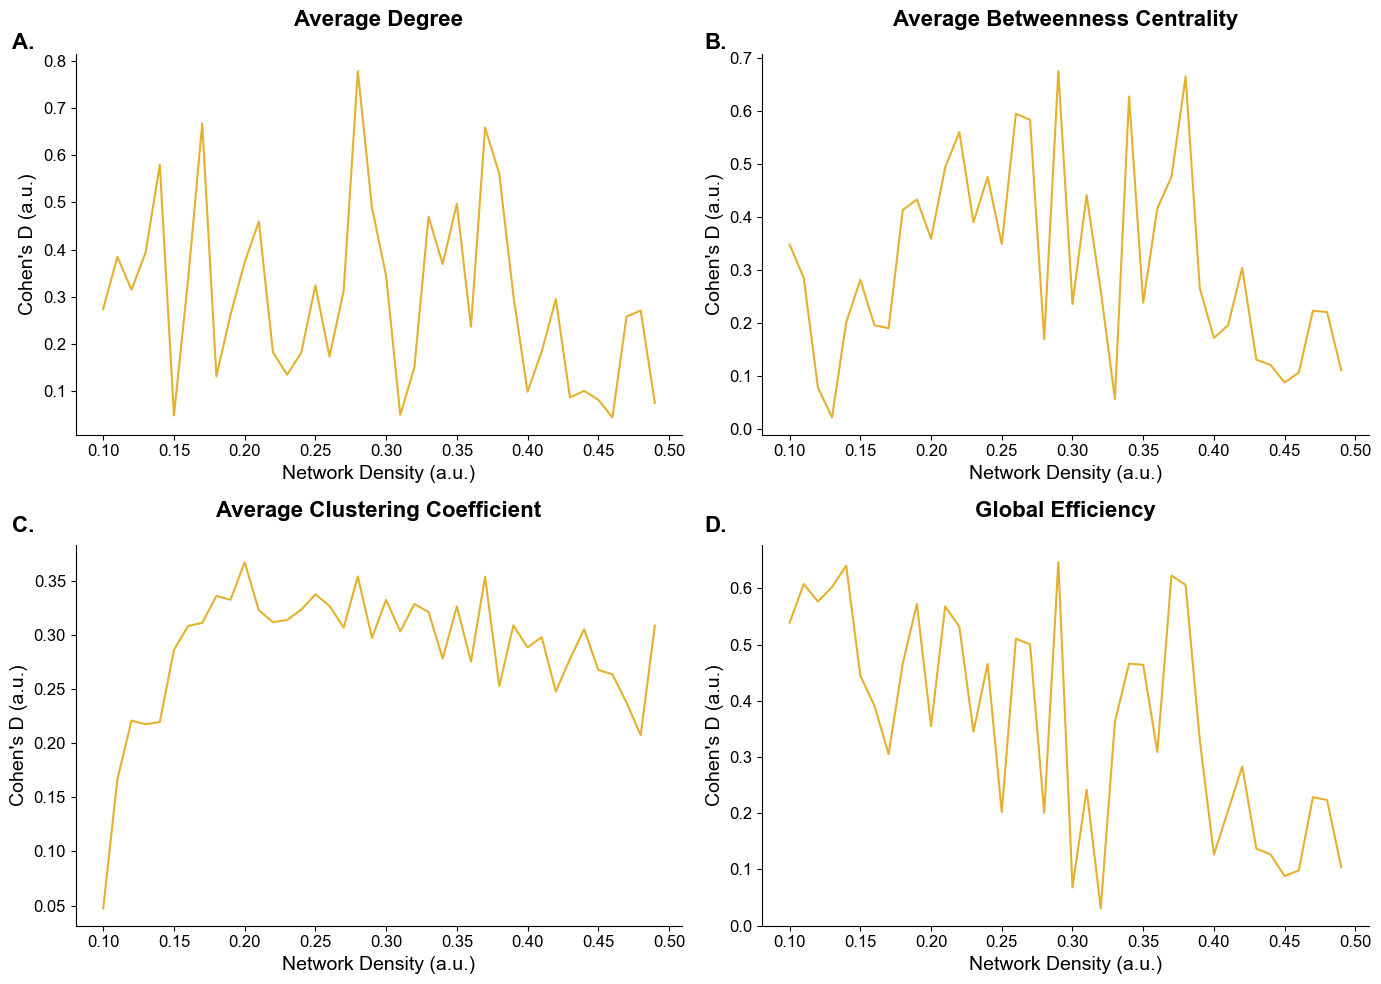

In [12]:
plt.figure(figsize=(14,10))
plt.subplot(221)
#plt.text(-0.1,2,'A')
plot_metrics_cohend(df_epilepsy_unharm,'Average Degree - Harmonized','Bilateral')
plt.ylabel('Cohen\'s D (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Average Degree', title_params, pad=20)

plt.subplot(222)
plot_metrics_cohend(df_epilepsy_unharm,'Average Betweeness - Harmonized','Bilateral')
plt.ylabel('Cohen\'s D (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Average Betweenness Centrality', title_params, pad=20)

plt.subplot(223)
plot_metrics_cohend(df_epilepsy_unharm,'Average Clustering - Harmonized','Bilateral')
plt.ylabel('Cohen\'s D (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Average Clustering Coefficient', title_params, pad=20)

plt.subplot(224)
plot_metrics_cohend(df_epilepsy_unharm,'Global Efficiency - Harmonized','Bilateral')
plt.ylabel('Cohen\'s D (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Global Efficiency', title_params, pad=20)

plt.tight_layout()
plt.text(-0.45,1.56,'A.',title_params)
plt.text(0.04,1.56,'B.',title_params)
plt.text(0.04,0.7,'D.',title_params)
plt.text(-0.45,0.7,'C.',title_params)

## Part 2: Participation Coefficient

Computing the participation coefficient

In [13]:
# Load the community structure
community_df = pd.read_excel('../data/bna_communities.xlsx')
community_df['Label'] = community_df['Label']-1




In [14]:
# Compute the participation coefficient in all the community definitions

def get_mean_participation(binary_fc,community_assignments):
    participation = bct.participation_coef(binary_fc,community_assignments)
    return np.mean(participation)

#### Average participation across all communities and nodes

In [15]:
densities=np.arange(0.1,0.5,0.01)
mean_participation = []
mean_participation_yeo7 = []
mean_participation_yeo17 = []
community_assignments_bna = community_df['Community ID LR'].values
community_assignments_yeo7 = community_df['Community ID Yeo 7 LR'].values
community_assignments_yeo17 = community_df['Community ID Yeo 17 LR'].values

In [16]:
df_epilepsy = df_epilepsy_unharm

for i in tqdm(range(len(df_epilepsy))):
    participation_single_list = []
    participation_single_list7 = []
    participation_single_list17 = []
    for j in range(len(densities)):
        pc = get_mean_participation(match_density(df_epilepsy.iloc[i]['fcon'],densities[j]),community_assignments_bna)
        participation_single_list.append(pc)

        # For Yeo communities, need to get rid of the subcortical structures since they are not accounted for
        pc7 = get_mean_participation(match_density(df_epilepsy.iloc[i]['fcon'][:210,:210],densities[j]),community_assignments_yeo7[:210])
        participation_single_list7.append(pc7)

        pc17 = get_mean_participation(match_density(df_epilepsy.iloc[i]['fcon'][:210,:210],densities[j]),community_assignments_yeo17[:210])
        participation_single_list17.append(pc17)

    mean_participation.append(np.array(participation_single_list))
    mean_participation_yeo7.append(np.array(participation_single_list7))
    mean_participation_yeo17.append(np.array(participation_single_list17))

df_epilepsy['PC BNA'] = mean_participation
df_epilepsy['PC Yeo7'] = mean_participation_yeo7
df_epilepsy['PC Yeo17'] = mean_participation_yeo17

100%|██████████| 94/94 [01:41<00:00,  1.08s/it]


In [47]:
df_epilepsy_unharm['PC BNA - Harmonized'] = listify(harmonize_batch_only(np.vstack(df_epilepsy_unharm['PC BNA']), df_epilepsy_unharm['version'].values, df_epilepsy_unharm['Bilateral'].values))
df_epilepsy_unharm['PC Yeo7 - Harmonized'] = listify(harmonize_batch_only(np.vstack(df_epilepsy_unharm['PC Yeo7']), df_epilepsy_unharm['version'].values, df_epilepsy_unharm['Bilateral'].values))
df_epilepsy_unharm['PC Yeo17 - Harmonized'] = listify(harmonize_batch_only(np.vstack(df_epilepsy_unharm['PC Yeo17']), df_epilepsy_unharm['version'].values, df_epilepsy_unharm['Bilateral'].values))


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0

Group 0: False
Group 1: True
Significant:  33 > 10 , p-value:  0.015984015984015984


array([0.04528228, 0.05264753, 0.06028817, 0.01529335, 0.01305351,
       0.02554828, 0.0347162 , 0.03854681, 0.03573205, 0.04313951,
       0.02447725, 0.02381624, 0.01955908, 0.0105472 , 0.02279103,
       0.00557787, 0.02071103, 0.0056298 , 0.01975464, 0.00855748,
       0.01059315, 0.02059463, 0.0111301 , 0.00692734, 0.01206855,
       0.01109539, 0.01881579, 0.01160254, 0.01716763, 0.0170081 ,
       0.0185948 , 0.02586082, 0.02578836, 0.03358804, 0.01884586,
       0.01153143, 0.0603479 , 0.02442445, 0.12269192, 0.02494421])

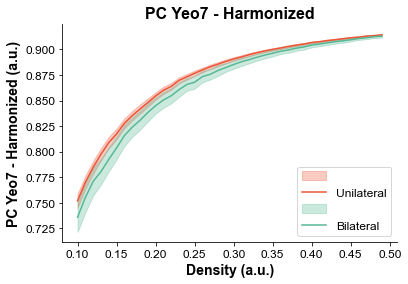

In [48]:
plt.figure()
plot_metrics_fill(df_epilepsy_unharm,'PC Yeo7 - Harmonized','Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy_unharm,'PC Yeo7 - Harmonized','Bilateral')

Group 0: False
Group 1: True
Not significant:  4 < 11 , p-value:  0.07592407592407592


array([0.07407692, 0.10005492, 0.09171976, 0.02757225, 0.02846479,
       0.05154596, 0.06423031, 0.07622246, 0.06196233, 0.06034365,
       0.04501945, 0.04577626, 0.03747497, 0.03056254, 0.08091806,
       0.02702871, 0.07445314, 0.03047553, 0.08233838, 0.0593299 ,
       0.10396897, 0.16540474, 0.13747323, 0.11014817, 0.1729747 ,
       0.18037521, 0.23859414, 0.1517567 , 0.20411408, 0.21638144,
       0.25680324, 0.32819822, 0.34758224, 0.43206042, 0.29728196,
       0.2030003 , 0.51327472, 0.35671154, 0.81850265, 0.39551898])

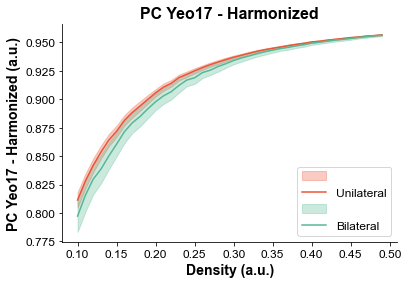

In [49]:

plt.figure()
plot_metrics_fill(df_epilepsy_unharm,'PC Yeo17 - Harmonized','Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy_unharm,'PC Yeo17 - Harmonized','Bilateral')


Group 0: False
Group 1: True
Not significant:  0 < 9 , p-value:  0.15584415584415584


array([0.25386348, 0.18268039, 0.17033223, 0.11220743, 0.06827908,
       0.23767413, 0.34972708, 0.48798251, 0.29804095, 0.21778283,
       0.32999927, 0.19414047, 0.25162125, 0.36890683, 0.3859758 ,
       0.52778909, 0.33127919, 0.40291004, 0.84818708, 0.45920584,
       0.80503144, 0.7346267 , 0.91237095, 0.86100248, 0.7755995 ,
       0.72616372, 0.90645391, 0.62975486, 0.84069643, 0.70971261,
       0.86150293, 0.62663724, 0.97923775, 0.6561642 , 0.68809461,
       0.58789803, 0.59788595, 0.65483019, 0.59565152, 0.47361248])

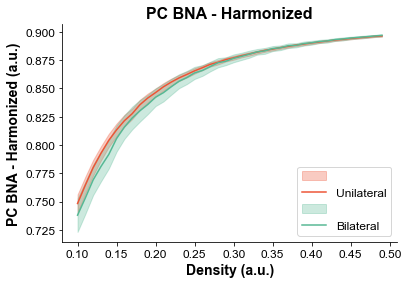

In [50]:

plt.figure()
plot_metrics_fill(df_epilepsy_unharm,'PC BNA - Harmonized','Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy_unharm,'PC BNA - Harmonized','Bilateral')

#### Participation Coefficient Across Subregions

100%|██████████| 94/94 [01:26<00:00,  1.08it/s]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 7 , p-value:  0.14685314685314685
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fa

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  4 < 9 , p-value:  0.07192807192807193


100%|██████████| 94/94 [01:44<00:00,  1.11s/it]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 8 , p-value:  0.17182817182817184
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fa

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  0 < 10 , p-value:  0.1918081918081918


100%|██████████| 94/94 [01:47<00:00,  1.15s/it]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 5 , p-value:  0.15684315684315683
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fa

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  0 < 7 , p-value:  0.16783216783216784


100%|██████████| 94/94 [01:14<00:00,  1.26it/s]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 9 , p-value:  0.1848151848151848
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fal

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  0 < 12 , p-value:  0.18181818181818182


100%|██████████| 94/94 [01:15<00:00,  1.25it/s]


Un-Harmonized
Group 0: False
Group 1: True
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
Significant:  40 > 8 , p-value:  0.000999000999000999
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False  True False  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  Tru

  0%|          | 0/94 [00:00<?, ?it/s]

Significant:  34 > 13 , p-value:  0.006993006993006993


100%|██████████| 94/94 [01:46<00:00,  1.13s/it]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  8 < 14 , p-value:  0.06493506493506493
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False F

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  0 < 7 , p-value:  0.18281718281718282


100%|██████████| 94/94 [01:21<00:00,  1.15it/s]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 7 , p-value:  0.19480519480519481
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fa

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  0 < 6 , p-value:  0.17882117882117882


100%|██████████| 94/94 [01:23<00:00,  1.12it/s]


Un-Harmonized
Group 0: False
Group 1: True
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
Significant:  40 > 10 , p-value:  0.000999000999000999
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  Tr

  0%|          | 0/94 [00:00<?, ?it/s]

Significant:  40 > 8 , p-value:  0.000999000999000999


100%|██████████| 94/94 [01:50<00:00,  1.18s/it]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 7 , p-value:  0.16483516483516483
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fa

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  0 < 6 , p-value:  0.15684315684315683


100%|██████████| 94/94 [01:41<00:00,  1.08s/it]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False  True  True  True  True  True  True  True
  True False  True False  True  True  True  True  True  True  True  True
  True  True  True  True]
Significant:  24 > 7 , p-value:  0.014985014985014986
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fals

  0%|          | 0/94 [00:00<?, ?it/s]

Significant:  12 > 11 , p-value:  0.04595404595404595


100%|██████████| 94/94 [04:01<00:00,  2.56s/it]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 9 , p-value:  0.18581418581418582
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fa

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  0 < 8 , p-value:  0.18181818181818182


100%|██████████| 94/94 [01:39<00:00,  1.06s/it]


Un-Harmonized
Group 0: False
Group 1: True
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False]
Significant:  39 > 9 , p-value:  0.003996003996003996
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True False False False False False False Fals

  0%|          | 0/94 [00:00<?, ?it/s]

Significant:  27 > 6 , p-value:  0.007992007992007992


100%|██████████| 94/94 [01:48<00:00,  1.15s/it]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  3 < 9 , p-value:  0.0939060939060939
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fal

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  3 < 9 , p-value:  0.1068931068931069


100%|██████████| 94/94 [03:40<00:00,  2.35s/it]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 11 , p-value:  0.17182817182817184
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False F

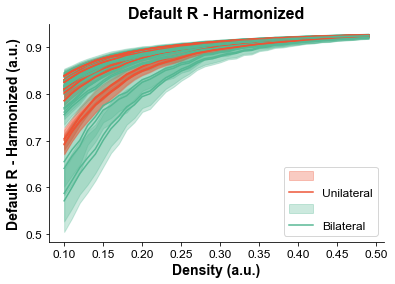

In [51]:
def get_nodal_participation(binary_fc,community_assignments):
    participation = bct.participation_coef(binary_fc,community_assignments)
    return participation
    
community_values_yeo7 = [1,2,3,4,5,6,7,101,102,103,104,105,106,107]
community_names_yeo7 = ['Visual L','Somatomotor L','Dorsal Attention L','Ventral Attention L','Limbic L','Frontoparietal L','Default L', 'Visual R','Somatomotor R','Dorsal Attention R','Ventral Attention R','Limbic R','Frontoparietal R','Default R']

df_participation = df_epilepsy_unharm.copy()

for i in range(len(community_values_yeo7)):
    participation_list = []
    for j in tqdm(range(len(df_epilepsy))):
        participation_single_list = []
        for k in range(len(densities)):
            pc = get_nodal_participation(match_density(df_epilepsy.iloc[j]['fcon'],densities[k]),community_assignments_yeo7)
            pc_mean = np.mean(pc[community_values_yeo7[i]==community_assignments_yeo7])
            participation_single_list.append(pc_mean)
        participation_list.append(np.array(participation_single_list))
    
    # Unharmonized
    print('Un-Harmonized')
    df_participation[community_names_yeo7[i]] = participation_list
    plot_metrics_fill(df_participation,community_names_yeo7[i],'Bilateral')
    print(get_fdr(df_participation,community_names_yeo7[i],'Bilateral'))
    get_suprathreshold_cluster_stat(df_participation,community_names_yeo7[i],'Bilateral')

    # Harmonized
    print('Harmonized')
    df_participation[community_names_yeo7[i]+' - Harmonized'] = listify(harmonize_batch_only(np.vstack(df_participation[community_names_yeo7[i]]), df_participation['version'].values, df_participation['Bilateral'].values))
    plot_metrics_fill(df_participation,community_names_yeo7[i]+' - Harmonized','Bilateral')
    print(get_fdr(df_participation,community_names_yeo7[i]+' - Harmonized','Bilateral'))
    get_suprathreshold_cluster_stat(df_participation,community_names_yeo7[i]+' - Harmonized','Bilateral')   

100%|██████████| 94/94 [01:18<00:00,  1.20it/s]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 12 , p-value:  0.16183816183816183
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False F

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  0 < 11 , p-value:  0.17382617382617382


100%|██████████| 94/94 [01:17<00:00,  1.22it/s]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 10 , p-value:  0.18581418581418582
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False F

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  1 < 11 , p-value:  0.13086913086913088


100%|██████████| 94/94 [01:18<00:00,  1.20it/s]


Un-Harmonized
Group 0: False
Group 1: True
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Significant:  18 > 11 , p-value:  0.025974025974025976
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False  True  True False False  True  True  True  True
 False False False False False False False False False False False False
 False False False False False False False False False Fal

  0%|          | 0/94 [00:00<?, ?it/s]

Significant:  14 > 10 , p-value:  0.03296703296703297


100%|██████████| 94/94 [01:43<00:00,  1.10s/it]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  7 < 11 , p-value:  0.06993006993006994
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False F

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  0 < 12 , p-value:  0.17082917082917082


100%|██████████| 94/94 [01:27<00:00,  1.07it/s]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 14 , p-value:  0.1958041958041958
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fa

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  0 < 10 , p-value:  0.16583416583416583


100%|██████████| 94/94 [01:18<00:00,  1.19it/s]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 10 , p-value:  0.15784215784215785
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False F

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  0 < 10 , p-value:  0.16683316683316685


100%|██████████| 94/94 [01:20<00:00,  1.17it/s]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 8 , p-value:  0.16183816183816183
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fa

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  0 < 9 , p-value:  0.17882117882117882


100%|██████████| 94/94 [01:28<00:00,  1.06it/s]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 14 , p-value:  0.19480519480519481
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False F

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  0 < 12 , p-value:  0.18181818181818182


100%|██████████| 94/94 [01:49<00:00,  1.16s/it]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 12 , p-value:  0.19080919080919082
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False F

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  0 < 9 , p-value:  0.1878121878121878


100%|██████████| 94/94 [02:18<00:00,  1.48s/it]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 9 , p-value:  0.16983016983016982
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fa

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  0 < 10 , p-value:  0.17582417582417584


100%|██████████| 94/94 [02:41<00:00,  1.72s/it]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 15 , p-value:  0.18081918081918083
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False F

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  1 < 15 , p-value:  0.13386613386613386


100%|██████████| 94/94 [01:39<00:00,  1.05s/it]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 13 , p-value:  0.16583416583416583
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False F

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  1 < 9 , p-value:  0.11888111888111888


100%|██████████| 94/94 [01:39<00:00,  1.06s/it]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 12 , p-value:  0.15884115884115885
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False F

  0%|          | 0/94 [00:00<?, ?it/s]

Not significant:  0 < 9 , p-value:  0.16083916083916083


100%|██████████| 94/94 [01:43<00:00,  1.10s/it]


Un-Harmonized
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Not significant:  0 < 9 , p-value:  0.15884115884115885
Harmonized
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Group 0: False
Group 1: True
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fa

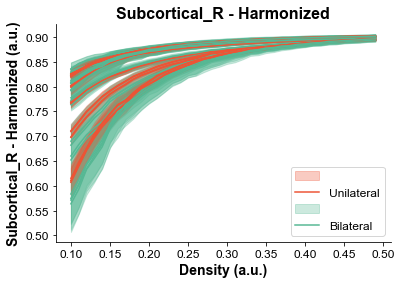

In [52]:
community_values_bna = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
community_names_bna = ['Frontal_L','Frontal_R','Temporal_L','Temporal_R','Parietal_L','Parietal_R','Insular_L','Insular_R','Limbic_L','Limbic_R','Occipital_L','Occipital_R','Subcortical_L','Subcortical_R']

for i in range(len(community_values_bna)):
    participation_list = []
    for j in tqdm(range(len(df_epilepsy))):
        participation_single_list = []
        for k in range(len(densities)):
            pc = get_nodal_participation(match_density(df_epilepsy.iloc[j]['fcon'],densities[k]),community_assignments_bna)
            pc_mean = np.mean(pc[community_values_bna[i]==community_assignments_bna])
            participation_single_list.append(pc_mean)
        participation_list.append(np.array(participation_single_list))
     # Unharmonized
    print('Un-Harmonized')
    df_participation[community_names_bna[i]] = participation_list
    plot_metrics_fill(df_participation,community_names_bna[i],'Bilateral')
    print(get_fdr(df_participation,community_names_bna[i],'Bilateral'))
    get_suprathreshold_cluster_stat(df_participation,community_names_bna[i],'Bilateral')

    # Harmonized
    print('Harmonized')
    df_participation[community_names_bna[i]+' - Harmonized'] = listify(harmonize_batch_only(np.vstack(df_participation[community_names_bna[i]]), df_participation['version'].values, df_participation['Bilateral'].values))
    plot_metrics_fill(df_participation,community_names_bna[i]+' - Harmonized','Bilateral')
    print(get_fdr(df_participation,community_names_bna[i]+' - Harmonized','Bilateral'))
    get_suprathreshold_cluster_stat(df_participation,community_names_bna[i]+' - Harmonized','Bilateral')   

#### Making participation coefficient figure

Group 0: False
Group 1: True
Group 0: False
Group 1: True
Group 0: False
Group 1: True
Group 0: False
Group 1: True
Group 0: False
Group 1: True
Group 0: False
Group 1: True
PC BNA - Harmonized
Not significant:  0 < 8 , p-value:  0.16283716283716285


BNA Temporal_L - Harmonized
Significant:  14 > 10 , p-value:  0.03396603396603397


BNA Temporal_R - Harmonized
Not significant:  0 < 10 , p-value:  0.16483516483516483


PC Yeo7 - Harmonized
Significant:  33 > 8 , p-value:  0.01098901098901099


PC Limbic L - Harmonized
Significant:  34 > 10 , p-value:  0.00999000999000999


PC Limbic R - Harmonized
Significant:  27 > 15 , p-value:  0.01098901098901099




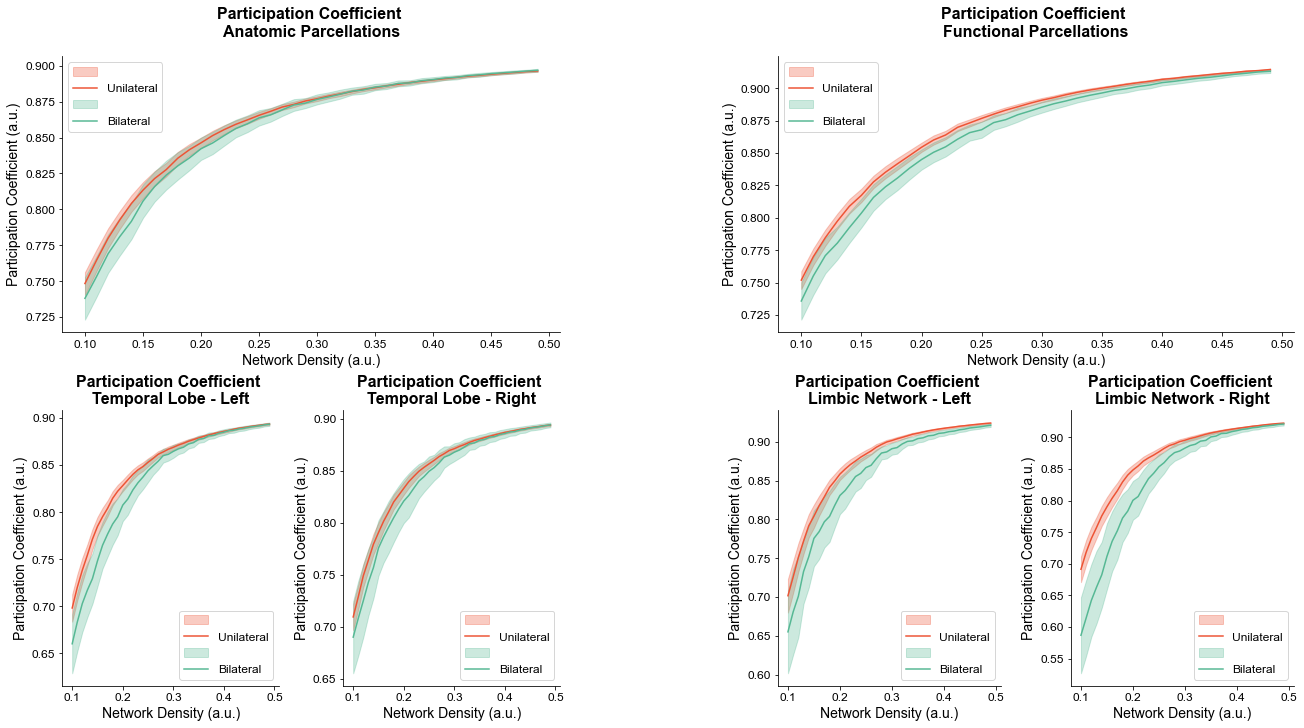

In [54]:
# Combined participation figure
fig3 = plt.figure(constrained_layout=True, figsize=(18,10))
gs = fig3.add_gridspec(2, 10)

f3_ax1 = fig3.add_subplot(gs[0, :4])
plot_metrics_fill(df_epilepsy_unharm,'PC BNA - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Participation Coefficient \nAnatomic Parcellations', title_params, pad=20)

f3_ax3 = fig3.add_subplot(gs[1, 0:2])
plot_metrics_fill(df_participation,'Temporal_L - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Participation Coefficient \nTemporal Lobe - Left', title_params)

f3_ax3 = fig3.add_subplot(gs[1, 2:4])
plot_metrics_fill(df_participation,'Temporal_R - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Participation Coefficient \nTemporal Lobe - Right', title_params)

f3_ax2 = fig3.add_subplot(gs[0, 6:])
plot_metrics_fill(df_epilepsy_unharm,'PC Yeo7 - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Participation Coefficient \nFunctional Parcellations', title_params, pad=20)

f3_ax3 = fig3.add_subplot(gs[1, 6:8])
plot_metrics_fill(df_participation,'Limbic L - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Participation Coefficient \nLimbic Network - Left', title_params)


f3_ax3 = fig3.add_subplot(gs[1, 8:])
plot_metrics_fill(df_participation,'Limbic R - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Participation Coefficient \nLimbic Network - Right', title_params)

# Stats
print('PC BNA - Harmonized')
get_suprathreshold_cluster_stat(df_epilepsy_unharm,'PC BNA - Harmonized','Bilateral')
print('\n')

print('BNA Temporal_L - Harmonized')
get_suprathreshold_cluster_stat(df_participation,'Temporal_L - Harmonized','Bilateral')
print('\n')

print('BNA Temporal_R - Harmonized')
get_suprathreshold_cluster_stat(df_participation,'Temporal_R - Harmonized','Bilateral')
print('\n')

print('PC Yeo7 - Harmonized')
get_suprathreshold_cluster_stat(df_epilepsy_unharm,'PC Yeo7 - Harmonized','Bilateral')
print('\n')

print('PC Limbic L - Harmonized')
get_suprathreshold_cluster_stat(df_participation,'Limbic L - Harmonized','Bilateral')
print('\n')

print('PC Limbic R - Harmonized')
get_suprathreshold_cluster_stat(df_participation,'Limbic R - Harmonized','Bilateral')
print('\n')


#### Participation coefficient statistics

In [175]:
get_suprathreshold_cluster_stat(df_participation,'PC Yeo7 - Harmonized','Bilateral')


Significant:  33 > 12 , p-value:  0.016983016983016984


array([0.04528228, 0.05264753, 0.06028817, 0.01529335, 0.01305351,
       0.02554828, 0.0347162 , 0.03854681, 0.03573205, 0.04313951,
       0.02447725, 0.02381624, 0.01955908, 0.0105472 , 0.02279103,
       0.00557787, 0.02071103, 0.0056298 , 0.01975464, 0.00855748,
       0.01059315, 0.02059463, 0.0111301 , 0.00692734, 0.01206855,
       0.01109539, 0.01881579, 0.01160254, 0.01716763, 0.0170081 ,
       0.0185948 , 0.02586082, 0.02578836, 0.03358804, 0.01884586,
       0.01153143, 0.0603479 , 0.02442445, 0.12269192, 0.02494421])

In [173]:
get_suprathreshold_cluster_stat(df_participation,'Temporal_L - Harmonized','Bilateral')


Significant:  14 > 10 , p-value:  0.03696303696303696


array([0.02676097, 0.02491595, 0.0246207 , 0.00896755, 0.00170755,
       0.00404988, 0.01083618, 0.01166736, 0.00537265, 0.00200631,
       0.007076  , 0.00616208, 0.01570367, 0.02321865, 0.05697913,
       0.09863413, 0.08699629, 0.07700876, 0.29176454, 0.12645211,
       0.20420821, 0.17889225, 0.16400175, 0.26278474, 0.19338225,
       0.53797299, 0.29020725, 0.68080885, 0.34138466, 0.65956037,
       0.62329275, 0.87657197, 0.46864146, 0.58211093, 0.56802771,
       0.67554967, 0.60276541, 0.64376969, 0.70034098, 0.9039066 ])

In [58]:
get_suprathreshold_cluster_stat(df_participation,'Limbic R - Harmonized','Bilateral')


Significant:  27 > 13 , p-value:  0.007992007992007992


array([1.22018267e-04, 8.40290865e-05, 9.28350279e-05, 6.89929238e-05,
       2.56848916e-05, 2.59550869e-04, 4.88636938e-04, 5.08966332e-04,
       3.00395597e-04, 4.94865877e-05, 8.70116379e-05, 5.38163868e-05,
       1.07942321e-04, 5.28554078e-04, 1.25468675e-03, 3.63864067e-03,
       8.08966780e-04, 2.53205889e-03, 1.21611882e-02, 3.35923920e-03,
       1.11263611e-02, 1.14393220e-02, 1.29707191e-02, 2.51307136e-02,
       7.55125819e-03, 3.64802714e-02, 1.98637418e-02, 1.10762680e-01,
       3.66619991e-02, 8.54842131e-02, 8.95664324e-02, 1.36708834e-01,
       9.68752668e-02, 1.02693779e-01, 8.60267080e-02, 1.21760611e-01,
       8.45789410e-02, 8.48623297e-02, 1.36264863e-01, 2.10158348e-01])

In [56]:
get_suprathreshold_cluster_stat(df_participation,'Visual R - Harmonized','Bilateral')


Significant:  40 > 7 , p-value:  0.000999000999000999


array([1.21305935e-04, 2.53896686e-04, 1.04008194e-04, 6.56800941e-05,
       2.36969268e-05, 1.79059966e-04, 1.06773985e-03, 1.18511184e-03,
       4.17770386e-04, 6.91643129e-04, 1.27010054e-03, 4.07379994e-04,
       9.27820368e-04, 6.30372991e-04, 6.62373718e-04, 7.36091785e-04,
       3.46615312e-04, 4.32054548e-04, 1.86772851e-03, 2.66506211e-04,
       1.24110164e-03, 4.03440731e-04, 6.95058967e-04, 5.59620019e-04,
       2.83082913e-04, 8.92818222e-04, 5.17194963e-04, 7.10342258e-04,
       1.23074910e-04, 3.29723339e-04, 2.21414453e-04, 2.49115877e-04,
       6.14659077e-05, 3.57377622e-04, 2.58551216e-04, 4.06979433e-04,
       1.51416368e-04, 1.03215303e-04, 8.79826465e-05, 2.73603721e-04])

Computing the participation across communities in the anatomic parcellations

## Part 3: Community Detection

Functions for identifying communities

In [18]:

def match_density(fcon, density, print_thresh=False):
    fcon = np.abs(fcon)
    def calc_density(binary):
        density = np.sum(binary)/(binary.shape[0]*(binary.shape[0]-1))
        return density
    density_list = []
    thresh = np.arange(0,0.99,0.01)
    for i in range(len(thresh)):
        binary = (fcon>np.arctanh(thresh[i])).astype(int)
        density_list.append(calc_density(binary))
    density_list = np.array(density_list)
    thresh_idx = np.argmin(np.abs(density_list-density))
    if print_thresh==True:
        print(thresh[thresh_idx])
    return (fcon>np.arctanh(thresh[thresh_idx])).astype(int)

def get_modularity_communities(binary_fc):
    G = nx.convert_matrix.from_numpy_matrix(binary_fc)
    c = list(greedy_modularity_communities(G))
    return len(c)

def get_modularity_communities_di(fc):
    c = bct.community_louvain(fc, gamma=1)
    return c[0]

def get_modularity_communities_di_gamma(fc):
    gamma = np.arange(0.5,3,0.1)
    c_count = []
    for i in range(len(gamma)):
        c_count.append(np.max(bct.community_louvain(fc, gamma=gamma[i])[0]))
    return np.array(c_count)

# def get_num_communities(fcon):
#     modularity_community_count = []
#     densities = np.arange(0.1,0.5,0.01)
#     for i in range(len(densities)):
#         modularity_community_count.append(get_modularity_communities(match_density(fcon, densities[i])))
#     return np.array(modularity_community_count)

def get_num_communities(fcon):
    modularity_community_count = []
    def num_communities(binary_fc, gamma=1):
        return np.max(bct.community_louvain(binary_fc, gamma=gamma)[0])
    densities = np.arange(0.1,0.5,0.01)
    for i in range(len(densities)):
        modularity_community_count.append(num_communities(match_density(fcon, densities[i])))
    return np.array(modularity_community_count)

# nodal_clustering_list = []
# for i in range(len(fcon_list_list)):
#     nodal_clustering_list.append(get_nodal_clustering(match_density(fcon_list_list[i], 0.15)))

communities_identified_list = []
communities_identified_di = []
community_assignments_di = []
for i in tqdm(range(len(df_epilepsy))):
    communities_identified_list.append(get_num_communities(df_epilepsy.iloc[i]['fcon']))
    communities_identified_di.append(get_modularity_communities_di_gamma(np.abs(df_epilepsy.iloc[i]['fcon'])))
    community_assignments_di.append(get_modularity_communities_di(np.abs(df_epilepsy.iloc[i]['fcon'])))

df_epilepsy['Communities Identified Bin'] = communities_identified_list
df_epilepsy['Communities Identified Di'] = communities_identified_di
df_epilepsy['Community Assignments Di'] = community_assignments_di

100%|██████████| 94/94 [03:58<00:00,  2.54s/it]


In [19]:
df_epilepsy['Communities Identified Bin - Harmonized'] = listify(harmonize_batch_only(np.vstack(df_epilepsy['Communities Identified Bin']), df_epilepsy['version'].values, df_epilepsy['Bilateral'].values))
df_epilepsy['Communities Identified Di - Harmonized'] = listify(harmonize_batch_only(np.vstack(df_epilepsy['Communities Identified Di']), df_epilepsy['version'].values, df_epilepsy['Bilateral'].values))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


/var/folders/cd/2tvrfhlx5cnbjft2fv0kn5gr0000gn/T/ipykernel_60697/386766891.py:69: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_orig, p_orig = scipy.stats.ttest_ind(a, b, axis=0)
/var/folders/cd/2tvrfhlx5cnbjft2fv0kn5gr0000gn/T/ipykernel_60697/386766891.py:83: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_shuffled, p_shuffled = scipy.stats.ttest_ind(a_shuffled, b_shuffled, axis=0)


Significant:  6 > 4 , p-value:  0.03296703296703297


array([0.11015298, 0.11015298, 0.11015298, 0.26410651, 0.16330432,
       0.17714358, 0.11861967, 0.05584594, 0.1591266 , 0.89708422,
       0.83249853, 0.74924062, 0.97234386, 0.66211549, 0.3610518 ,
       0.16803226, 0.04597498, 0.0688174 , 0.08125116, 0.01235272,
       0.02106208, 0.0091633 , 0.01203063, 0.00466955, 0.00276272])

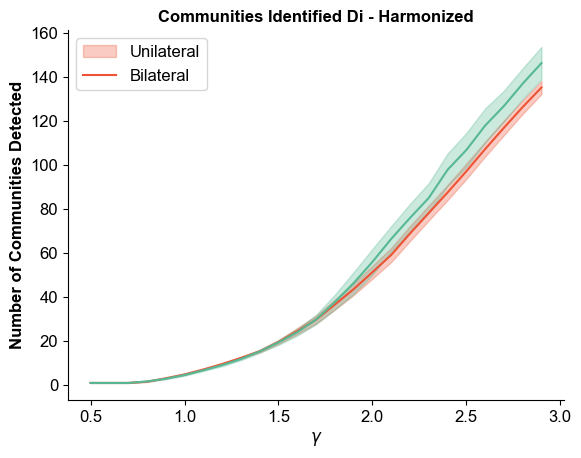

In [25]:
plot_communities_fill(df_epilepsy, 'Communities Identified Di - Harmonized', 'Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy,'Communities Identified Di - Harmonized','Bilateral')


Significant:  5 > 4 , p-value:  0.025974025974025976


array([0.00811452, 0.00252946, 0.01122372, 0.02386666, 0.00941388,
       0.12559618, 0.06385151, 0.79478898, 0.50587035, 0.45877204,
       0.81918411, 0.21490584, 0.40397914, 0.98556565, 0.82104186,
       0.24192708, 0.39092325, 0.04594024, 0.24174004, 0.66588159,
       0.00458286, 0.08097204, 0.02032399, 0.02943547, 0.18340281,
       0.31480363, 0.0386332 , 0.00627897, 0.00788683, 0.12147615,
       0.8099223 , 0.03779045, 0.05283103, 0.27706167, 0.1394851 ,
       0.05900408, 0.0849074 , 0.02750794, 0.08480834, 0.03383586])

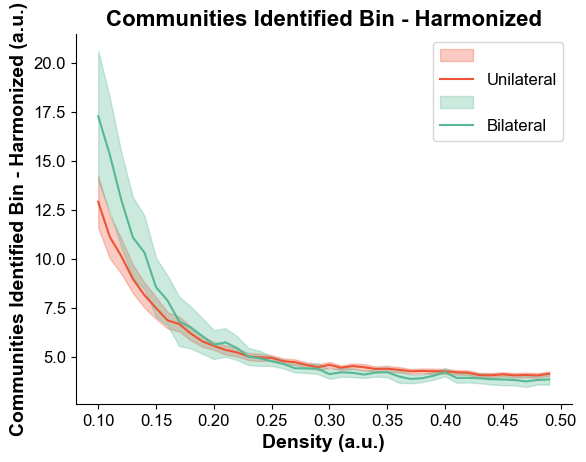

In [26]:
plot_metrics_fill(df_epilepsy,'Communities Identified Bin - Harmonized','Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy,'Communities Identified Bin - Harmonized','Bilateral')


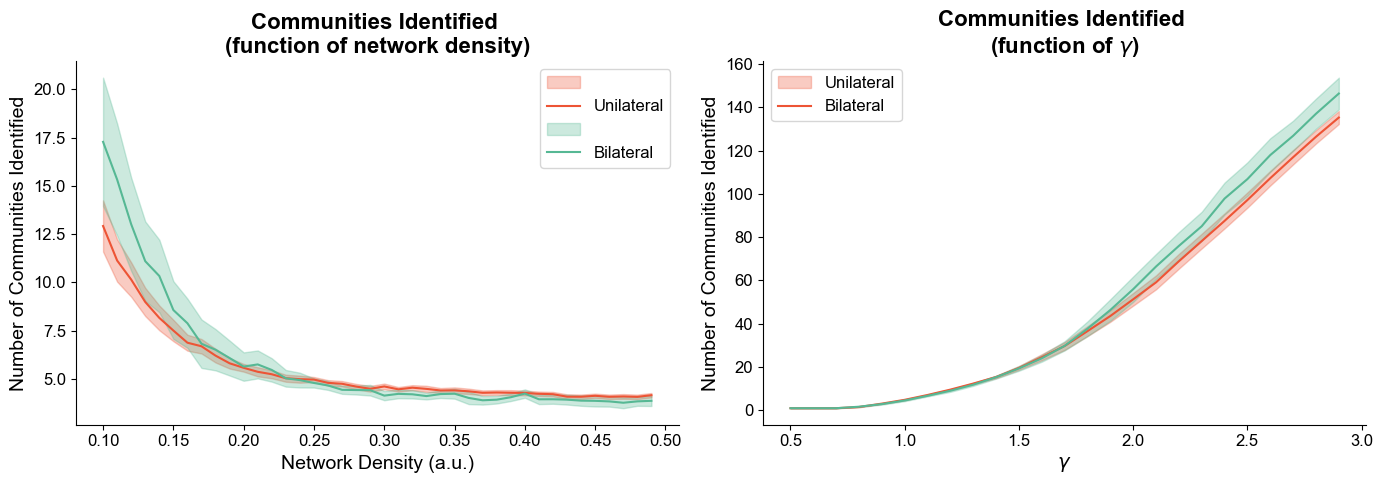

In [27]:
# Combined plot
plt.figure(figsize=(14,5))
plt.subplot(121)
plot_metrics_fill(df_epilepsy,'Communities Identified Bin - Harmonized','Bilateral')
plt.title('Communities Identified \n(function of network density)', title_params)
plt.ylabel('Number of Communities Identified', label_params)
plt.xlabel('Network Density (a.u.)', label_params)

plt.subplot(122)
plot_communities_fill(df_epilepsy, 'Communities Identified Di - Harmonized', 'Bilateral')
plt.title('Communities Identified \n(function of $\gamma$)', title_params)
plt.ylabel('Number of Communities Identified', label_params)
plt.xlabel('$\gamma$', label_params)
plt.tight_layout()

## Part 4: Integration-Segregation Axis

Gathering the harmonized global efficiency and clustering coefficient from each subject in order to compute the integration-segregation axis

In [29]:
df_epilepsy = df_epilepsy_unharm

ge_bl = np.vstack(df_epilepsy[df_epilepsy['Bilateral']==True]['Global Efficiency - Harmonized'].values)
cc_bl = np.vstack(df_epilepsy[df_epilepsy['Bilateral']==True]['Average Clustering - Harmonized'].values)

ge_uni = np.vstack(df_epilepsy[df_epilepsy['Bilateral']==False]['Global Efficiency - Harmonized'].values)
cc_uni = np.vstack(df_epilepsy[df_epilepsy['Bilateral']==False]['Average Clustering - Harmonized'].values)

# Load additional information such as bilateral lesional status and ieeg
additional_demographics = pd.read_excel('../data/additional_demographics.xlsx')
df_epilepsy = pd.merge(df_epilepsy, additional_demographics, on='Subject')

Computing the integration-segregation axis

In [30]:
# Perform PCA 
colors = ["#f03232","#00a2d0","#feae00","#acacac"]
sns.set_palette(sns.color_palette(colors))


from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
X_bl_all = np.hstack([ge_bl, cc_bl])
X_uni_all = np.hstack([ge_uni, cc_uni])


X_all = np.vstack([X_bl_all, X_uni_all])
y = [1]*len(X_bl_all) + [0]*len(X_uni_all)
pca = PCA()

# Estimate the integration-segregation axis with all subjects
X_all_pca = pca.fit_transform(X_all)



### Visualizing subjects with different clinical characteristics in the integration-segregation axis

#### BiTLE with confirmed iEEG

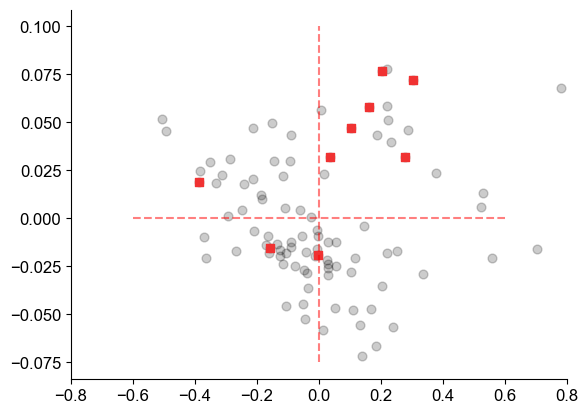

In [35]:

# Only BiTLE with confirmed IEEG
plt.figure()
ge_ieeg_bl = np.vstack(df_epilepsy[ ((df_epilepsy['IEEG']=='IEEG') & (df_epilepsy['Bilateral']==True)) ]['Global Efficiency - Harmonized'].values)
cc_ieeg_bl = np.vstack(df_epilepsy[((df_epilepsy['IEEG']=='IEEG') & (df_epilepsy['Bilateral']==True)) ]['Average Clustering - Harmonized'].values)

ge_ieeg_uni = np.vstack(df_epilepsy[(df_epilepsy['Bilateral']!=True) & (df_epilepsy['IEEG']=='IEEG')]['Global Efficiency - Harmonized'].values)
cc_ieeg_uni = np.vstack(df_epilepsy[(df_epilepsy['Bilateral']!=True) & (df_epilepsy['IEEG']=='IEEG')]['Average Clustering - Harmonized'].values)


X_ieeg_bl = np.hstack([ge_ieeg_bl, cc_ieeg_bl])
X_ieeg_uni = np.hstack([ge_ieeg_uni, cc_ieeg_uni])

X_ieeg_uni_pca = pca.transform(X_ieeg_uni)
X_ieeg_bl_pca = pca.transform(X_ieeg_bl)

plt.scatter(X_all_pca[:,0], X_all_pca[:,1], color='k', s=40, alpha=0.2)
#plt.scatter(X_uni_pca[:,0], X_uni_pca[:,1])
plt.scatter(X_ieeg_bl_pca[:,0], X_ieeg_bl_pca[:,1], marker='s')
#plt.scatter(X_c_pca[:,0], X_c_pca[:,1], color='k')
plt.xlim([-0.8,0.8])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.6, xmax=0.6, linestyles='--', color='r', alpha=0.5)

#### Subjects with bilateral lesions

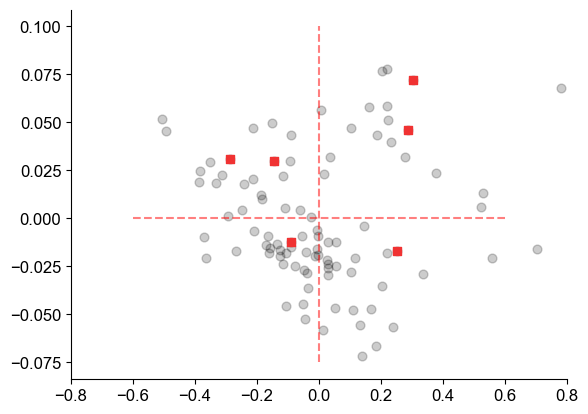

In [36]:

# Subjects with Bilateral lesions
plt.figure()
ge_bl_mts = np.vstack(df_epilepsy[  (df_epilepsy['Lesion_Bilateral']=='B')  ]['Global Efficiency - Harmonized'].values)
cc_bl_mts = np.vstack(df_epilepsy[ (df_epilepsy['Lesion_Bilateral']=='B') ]['Average Clustering - Harmonized'].values)

X_bl_mts = np.hstack([ge_bl_mts, cc_bl_mts])

X_bl_mts_pca = pca.transform(X_bl_mts)

plt.scatter(X_all_pca[:,0], X_all_pca[:,1], color='k', s=40, alpha=0.2)
#plt.scatter(X_uni_pca[:,0], X_uni_pca[:,1])
plt.scatter(X_bl_mts_pca[:,0], X_bl_mts_pca[:,1], marker='s')
#plt.scatter(X_c_pca[:,0], X_c_pca[:,1], color='k')
plt.xlim([-0.8,0.8])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.6, xmax=0.6, linestyles='--', color='r', alpha=0.5)

#### Subjects with Bilateral lesions or Bilateral IEEG seizure onset


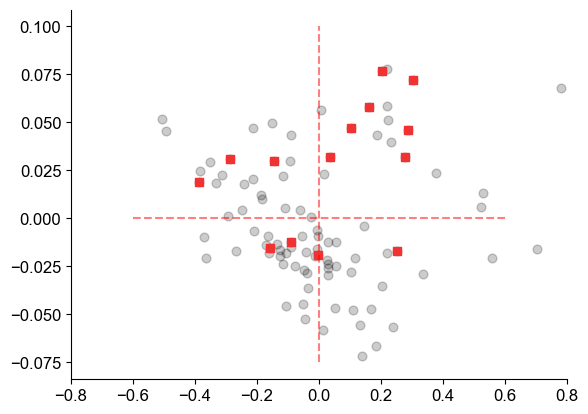

In [37]:
plt.figure()
ge_ieeg_bl_mts = np.vstack(df_epilepsy[  (df_epilepsy['Lesion_Bilateral']=='B') | ((df_epilepsy['IEEG']=='IEEG') & (df_epilepsy['Bilateral']==True)) ]['Global Efficiency - Harmonized'].values)
cc_ieeg_bl_mts = np.vstack(df_epilepsy[ (df_epilepsy['Lesion_Bilateral']=='B') | ((df_epilepsy['IEEG']=='IEEG') & (df_epilepsy['Bilateral']==True)) ]['Average Clustering - Harmonized'].values)


X_ieeg_bl_mts = np.hstack([ge_ieeg_bl_mts, cc_ieeg_bl_mts])

X_ieeg_bl_mts_pca = pca.transform(X_ieeg_bl_mts)

plt.scatter(X_all_pca[:,0], X_all_pca[:,1], color='k', s=40, alpha=0.2)
#plt.scatter(X_uni_pca[:,0], X_uni_pca[:,1])
plt.scatter(X_ieeg_bl_mts_pca[:,0], X_ieeg_bl_mts_pca[:,1], marker='s')
#plt.scatter(X_c_pca[:,0], X_c_pca[:,1], color='k')
plt.xlim([-0.8,0.8])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.6, xmax=0.6, linestyles='--', color='r', alpha=0.5)

#### Subjects with unilateral MTS

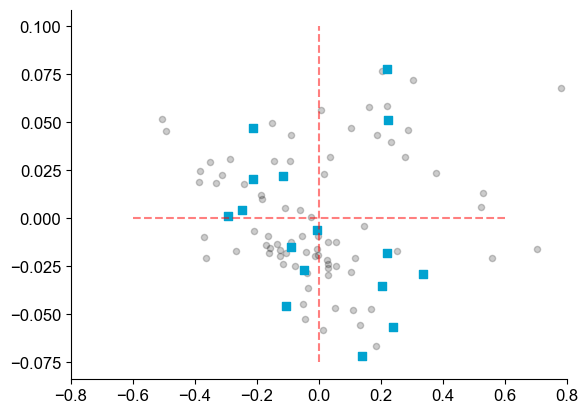

In [38]:

plt.figure()

ge_uni_mts = np.vstack(df_epilepsy[(df_epilepsy['Bilateral']!=True) & (df_epilepsy['MTS']=='Y')]['Global Efficiency - Harmonized'].values)
cc_uni_mts = np.vstack(df_epilepsy[(df_epilepsy['Bilateral']!=True) & (df_epilepsy['MTS']=='Y')]['Average Clustering - Harmonized'].values)

X_uni_mts = np.hstack([ge_uni_mts, cc_uni_mts])

X_uni_mts_pca = pca.transform(X_uni_mts)

plt.scatter(X_all_pca[:,0], X_all_pca[:,1], color='k', s=20, alpha=0.2)
#plt.scatter(X_uni_pca[:,0], X_uni_pca[:,1])
#plt.scatter(X_bl_pca[:,0], X_bl_pca[:,1], marker='s')
plt.scatter(X_uni_mts_pca[:,0], X_uni_mts_pca[:,1], marker='s', color="#00a2d0")
#plt.scatter(X_c_pca[:,0], X_c_pca[:,1], color='k')
sns.despine()
plt.xlim([-0.8,0.8])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.6, xmax=0.6, linestyles='--', color='r', alpha=0.5)

#### Subjects with unilateral TLE based on iEEG


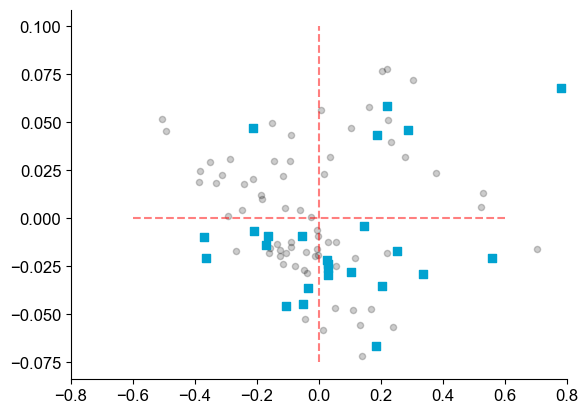

In [39]:
plt.scatter(X_all_pca[:,0], X_all_pca[:,1], color='k', s=20, alpha=0.2)
#plt.scatter(X_uni_pca[:,0], X_uni_pca[:,1])
#plt.scatter(X_bl_pca[:,0], X_bl_pca[:,1], marker='s')
plt.scatter(X_ieeg_uni_pca[:,0], X_ieeg_uni_pca[:,1], marker='s', color="#00a2d0")
#plt.scatter(X_c_pca[:,0], X_c_pca[:,1], color='k')
sns.despine()
plt.xlim([-0.8,0.8])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.6, xmax=0.6, linestyles='--', color='r', alpha=0.5)

#### Good and poor surgical outcomes

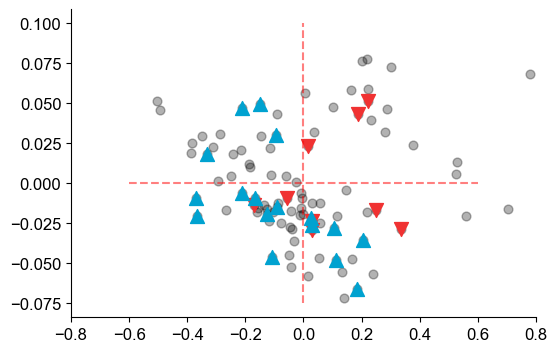

In [40]:
outcomes = pd.read_excel('../data/surgical_outcomes.xlsx')
outcomes = pd.merge(df_epilepsy, outcomes, on='Subject')
outcomes_bl = np.vstack(outcomes[(outcomes['Bilateral']==True)]['Good_outcome'].values.astype(object))
outcomes_uni = np.vstack(outcomes[(outcomes['Bilateral']==False)]['Good_outcome'].values.astype(object))
outcomes_bl[:] = np.nan
np.sum(np.vstack((outcomes_bl, outcomes_uni))=='Yes')
outcomes_uni = outcomes_uni.reshape(-1)
plt.figure(figsize=(6,4))


X_uni_all_pca = pca.transform(X_uni_all)
X_bl_all_pca = pca.transform(X_bl_all)


plt.scatter(X_all_pca[:,0], X_all_pca[:,1],color='k', alpha=0.3, s=40)
plt.scatter(X_uni_all_pca[outcomes_uni=='No',0], X_uni_all_pca[outcomes_uni=='No',1],marker='v', s=100)
plt.scatter(X_uni_all_pca[outcomes_uni=='Yes',0], X_uni_all_pca[outcomes_uni=='Yes',1], marker='^', s=100)
#plt.scatter(np.mean(X_uni_pca[outcomes_uni=='No',0]),np.mean(X_uni_pca[outcomes_uni=='No',1]))
#plt.scatter(np.mean(X_uni_pca[outcomes_uni=='Yes',0]),np.mean(X_uni_pca[outcomes_uni=='Yes',1]))

sns.despine()
plt.xlim([-0.8,0.8])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.6, xmax=0.6, linestyles='--', color='r', alpha=0.5)

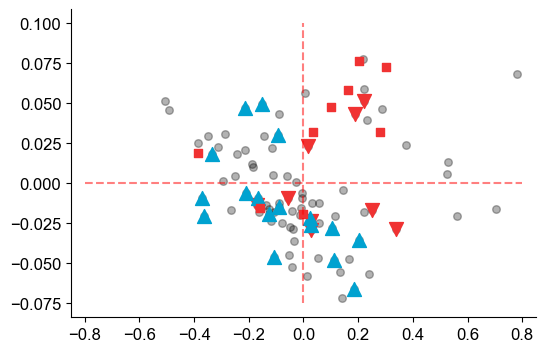

In [41]:

plt.figure(figsize=(6,4))

plt.scatter(X_all_pca[:,0], X_all_pca[:,1],color='k', alpha=0.3, s=30)
plt.scatter(X_uni_all_pca[outcomes_uni=='No',0], X_uni_all_pca[outcomes_uni=='No',1],marker='v', s=100)
plt.scatter(X_uni_all_pca[outcomes_uni=='Yes',0], X_uni_all_pca[outcomes_uni=='Yes',1],marker='^', s=100)

#plt.scatter(np.mean(X_uni_pca[outcomes_uni=='No',0]),np.mean(X_uni_pca[outcomes_uni=='No',1]))
#plt.scatter(np.mean(X_uni_pca[outcomes_uni=='Yes',0]),np.mean(X_uni_pca[outcomes_uni=='Yes',1]))
plt.scatter(X_ieeg_bl_pca[:,0], X_ieeg_bl_pca[:,1], marker='s', color='#f03232')
#plt.scatter(X_uni_mts_pca[:,0], X_uni_mts_pca[:,1], marker='s', color='k')
#plt.scatter(X_c_pca[:,0], X_c_pca[:,1], marker='s', color='k')

sns.despine()
plt.xlim([-0.85,0.85])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.8, xmax=0.8, linestyles='--', color='r', alpha=0.5)

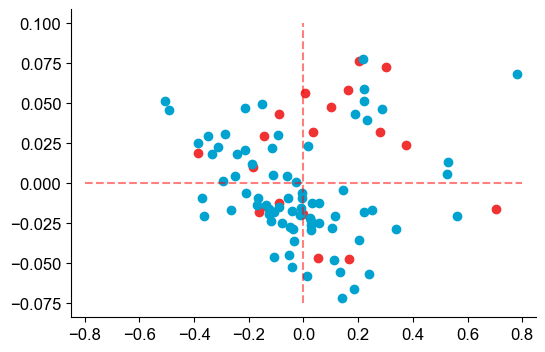

In [42]:
# Original all bilateral and unilateral subjects
plt.figure(figsize=(6,4))

#plt.scatter(X_all_pca[:,0], X_all_pca[:,1],color='k', alpha=0.3, s=30)
plt.scatter(X_bl_all_pca[:,0], X_bl_all_pca[:,1])
plt.scatter(X_uni_all_pca[:,0], X_uni_all_pca[:,1])

sns.despine()
plt.xlim([-0.85,0.85])
sns.despine()
plt.hlines(y=0, xmin=-0.8, xmax=0.8, linestyles='--', color='r', alpha=0.5)
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)


Text(0, 0.5, 'PC2 (a.u.)')

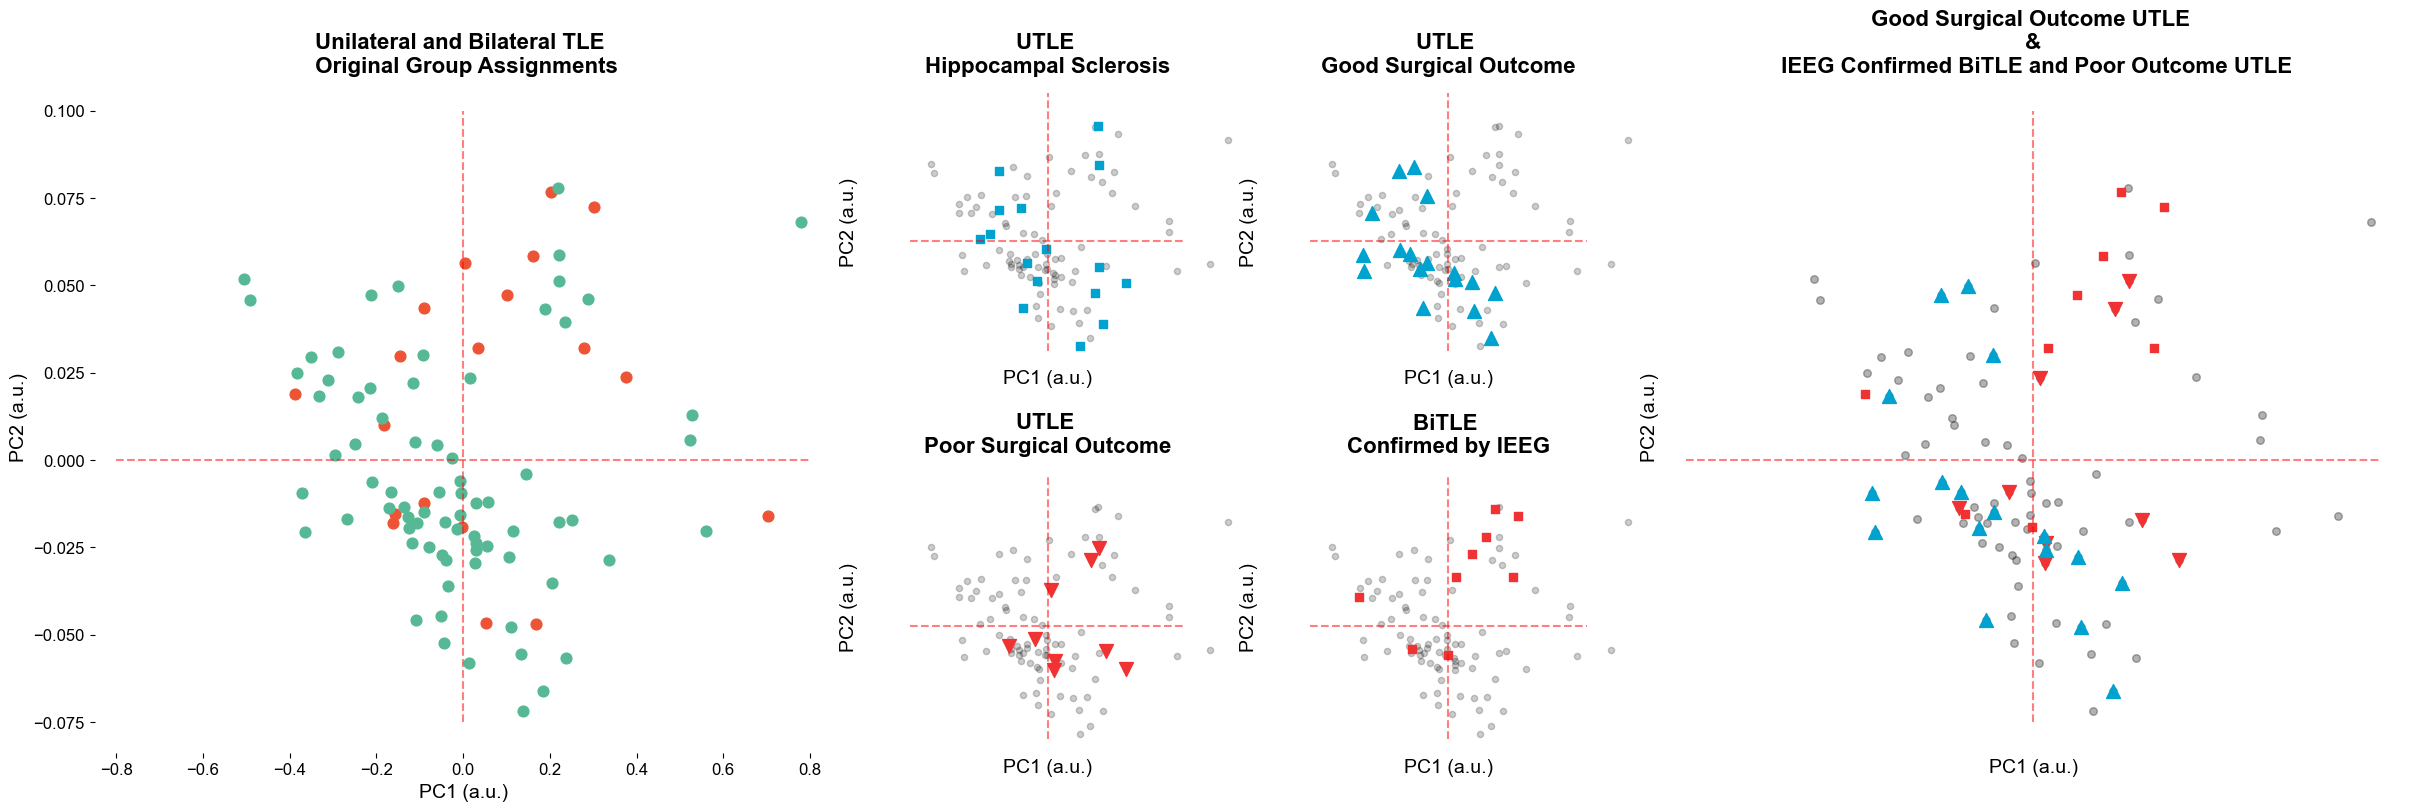

In [45]:
# Combined Figure
fig3 = plt.figure(constrained_layout=True, figsize=(24,8))
gs = fig3.add_gridspec(4, 12)

# Change colors for the first plot
colors=['#ED5435','#56B894']
sns.set_palette(colors)

# A. Original UTLE and BiTLE group assignments
f3_ax1 = fig3.add_subplot(gs[:4, :4])

plt.scatter(X_bl_all_pca[:,0], X_bl_all_pca[:,1], s=60)
plt.scatter(X_uni_all_pca[:,0], X_uni_all_pca[:,1], s=60)
plt.xlim([-0.85,0.85])
sns.despine()
plt.hlines(y=0, xmin=-0.8, xmax=0.8, linestyles='--', color='r', alpha=0.5)
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.title('Unilateral and Bilateral TLE \n Original Group Assignments', title_params)
plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('PC2 (a.u.)', label_params)

# Change colors for the rest of the plots
colors = ["#f03232","#00a2d0","#feae00","#acacac"]
sns.set_palette(sns.color_palette(colors))

# B. Unilateral MTS
f3_ax1 = fig3.add_subplot(gs[:2, 4:6])
plt.scatter(X_all_pca[:,0], X_all_pca[:,1], color='k', s=20, alpha=0.2)
plt.scatter(X_uni_mts_pca[:,0], X_uni_mts_pca[:,1], marker='s', color="#00a2d0")
sns.despine()
plt.xlim([-0.8,0.8])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.6, xmax=0.6, linestyles='--', color='r', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.title('UTLE \nHippocampal Sclerosis', title_params)
plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('PC2 (a.u.)', label_params)

# C. Unilateral, good outcome
f3_ax1 = fig3.add_subplot(gs[:2, 6:8])
plt.scatter(X_all_pca[:,0], X_all_pca[:,1], color='k', s=20, alpha=0.2)
plt.scatter(X_uni_all_pca[outcomes_uni=='Yes',0], X_uni_all_pca[outcomes_uni=='Yes',1], marker='^', s=100, color="#00a2d0")
sns.despine()
plt.xlim([-0.8,0.8])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.6, xmax=0.6, linestyles='--', color='r', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.title('UTLE \nGood Surgical Outcome', title_params)
plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('PC2 (a.u.)', label_params)

# F. IEEG BiTLE, poor outcome and good outcome
f3_ax1 = fig3.add_subplot(gs[:4, 8:12])

plt.scatter(X_all_pca[:,0], X_all_pca[:,1],color='k', alpha=0.3, s=30)
plt.scatter(X_uni_all_pca[outcomes_uni=='No',0], X_uni_all_pca[outcomes_uni=='No',1],marker='v', s=100)
plt.scatter(X_uni_all_pca[outcomes_uni=='Yes',0], X_uni_all_pca[outcomes_uni=='Yes',1],marker='^', s=100)
plt.scatter(X_ieeg_bl_pca[:,0], X_ieeg_bl_pca[:,1], marker='s', color='#f03232')
sns.despine()
plt.xlim([-0.85,0.85])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.8, xmax=0.8, linestyles='--', color='r', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.title('Good Surgical Outcome UTLE \n&\n IEEG Confirmed BiTLE and Poor Outcome UTLE', title_params)
plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('PC2 (a.u.)', label_params)

# E. BiTLE with IEEG
f3_ax1 = fig3.add_subplot(gs[2:, 6:8])

plt.scatter(X_all_pca[:,0], X_all_pca[:,1], color='k', s=20, alpha=0.2)
#plt.scatter(X_uni_pca[:,0], X_uni_pca[:,1])
plt.scatter(X_ieeg_bl_pca[:,0], X_ieeg_bl_pca[:,1], marker='s')
#plt.scatter(X_c_pca[:,0], X_c_pca[:,1], color='k')
plt.xlim([-0.8,0.8])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.6, xmax=0.6, linestyles='--', color='r', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.title('BiTLE \nConfirmed by IEEG', title_params)
plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('PC2 (a.u.)', label_params)


# D. Unilateral, poor outcome
f3_ax1 = fig3.add_subplot(gs[2:, 4:6])

plt.scatter(X_all_pca[:,0], X_all_pca[:,1], color='k', s=20, alpha=0.2)
#plt.scatter(X_uni_pca[:,0], X_uni_pca[:,1])
plt.scatter(X_uni_all_pca[outcomes_uni=='No',0], X_uni_all_pca[outcomes_uni=='No',1], marker='v', s=100)
#plt.scatter(X_c_pca[:,0], X_c_pca[:,1], color='k')
plt.xlim([-0.8,0.8])
sns.despine(left = True, bottom=True)
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.6, xmax=0.6, linestyles='--', color='r', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.title('UTLE \nPoor Surgical Outcome', title_params)
plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('PC2 (a.u.)', label_params)

#### Visualizing the mean value of each principal component for all groups

Text(0, 0.5, 'PC2 (a.u.)')

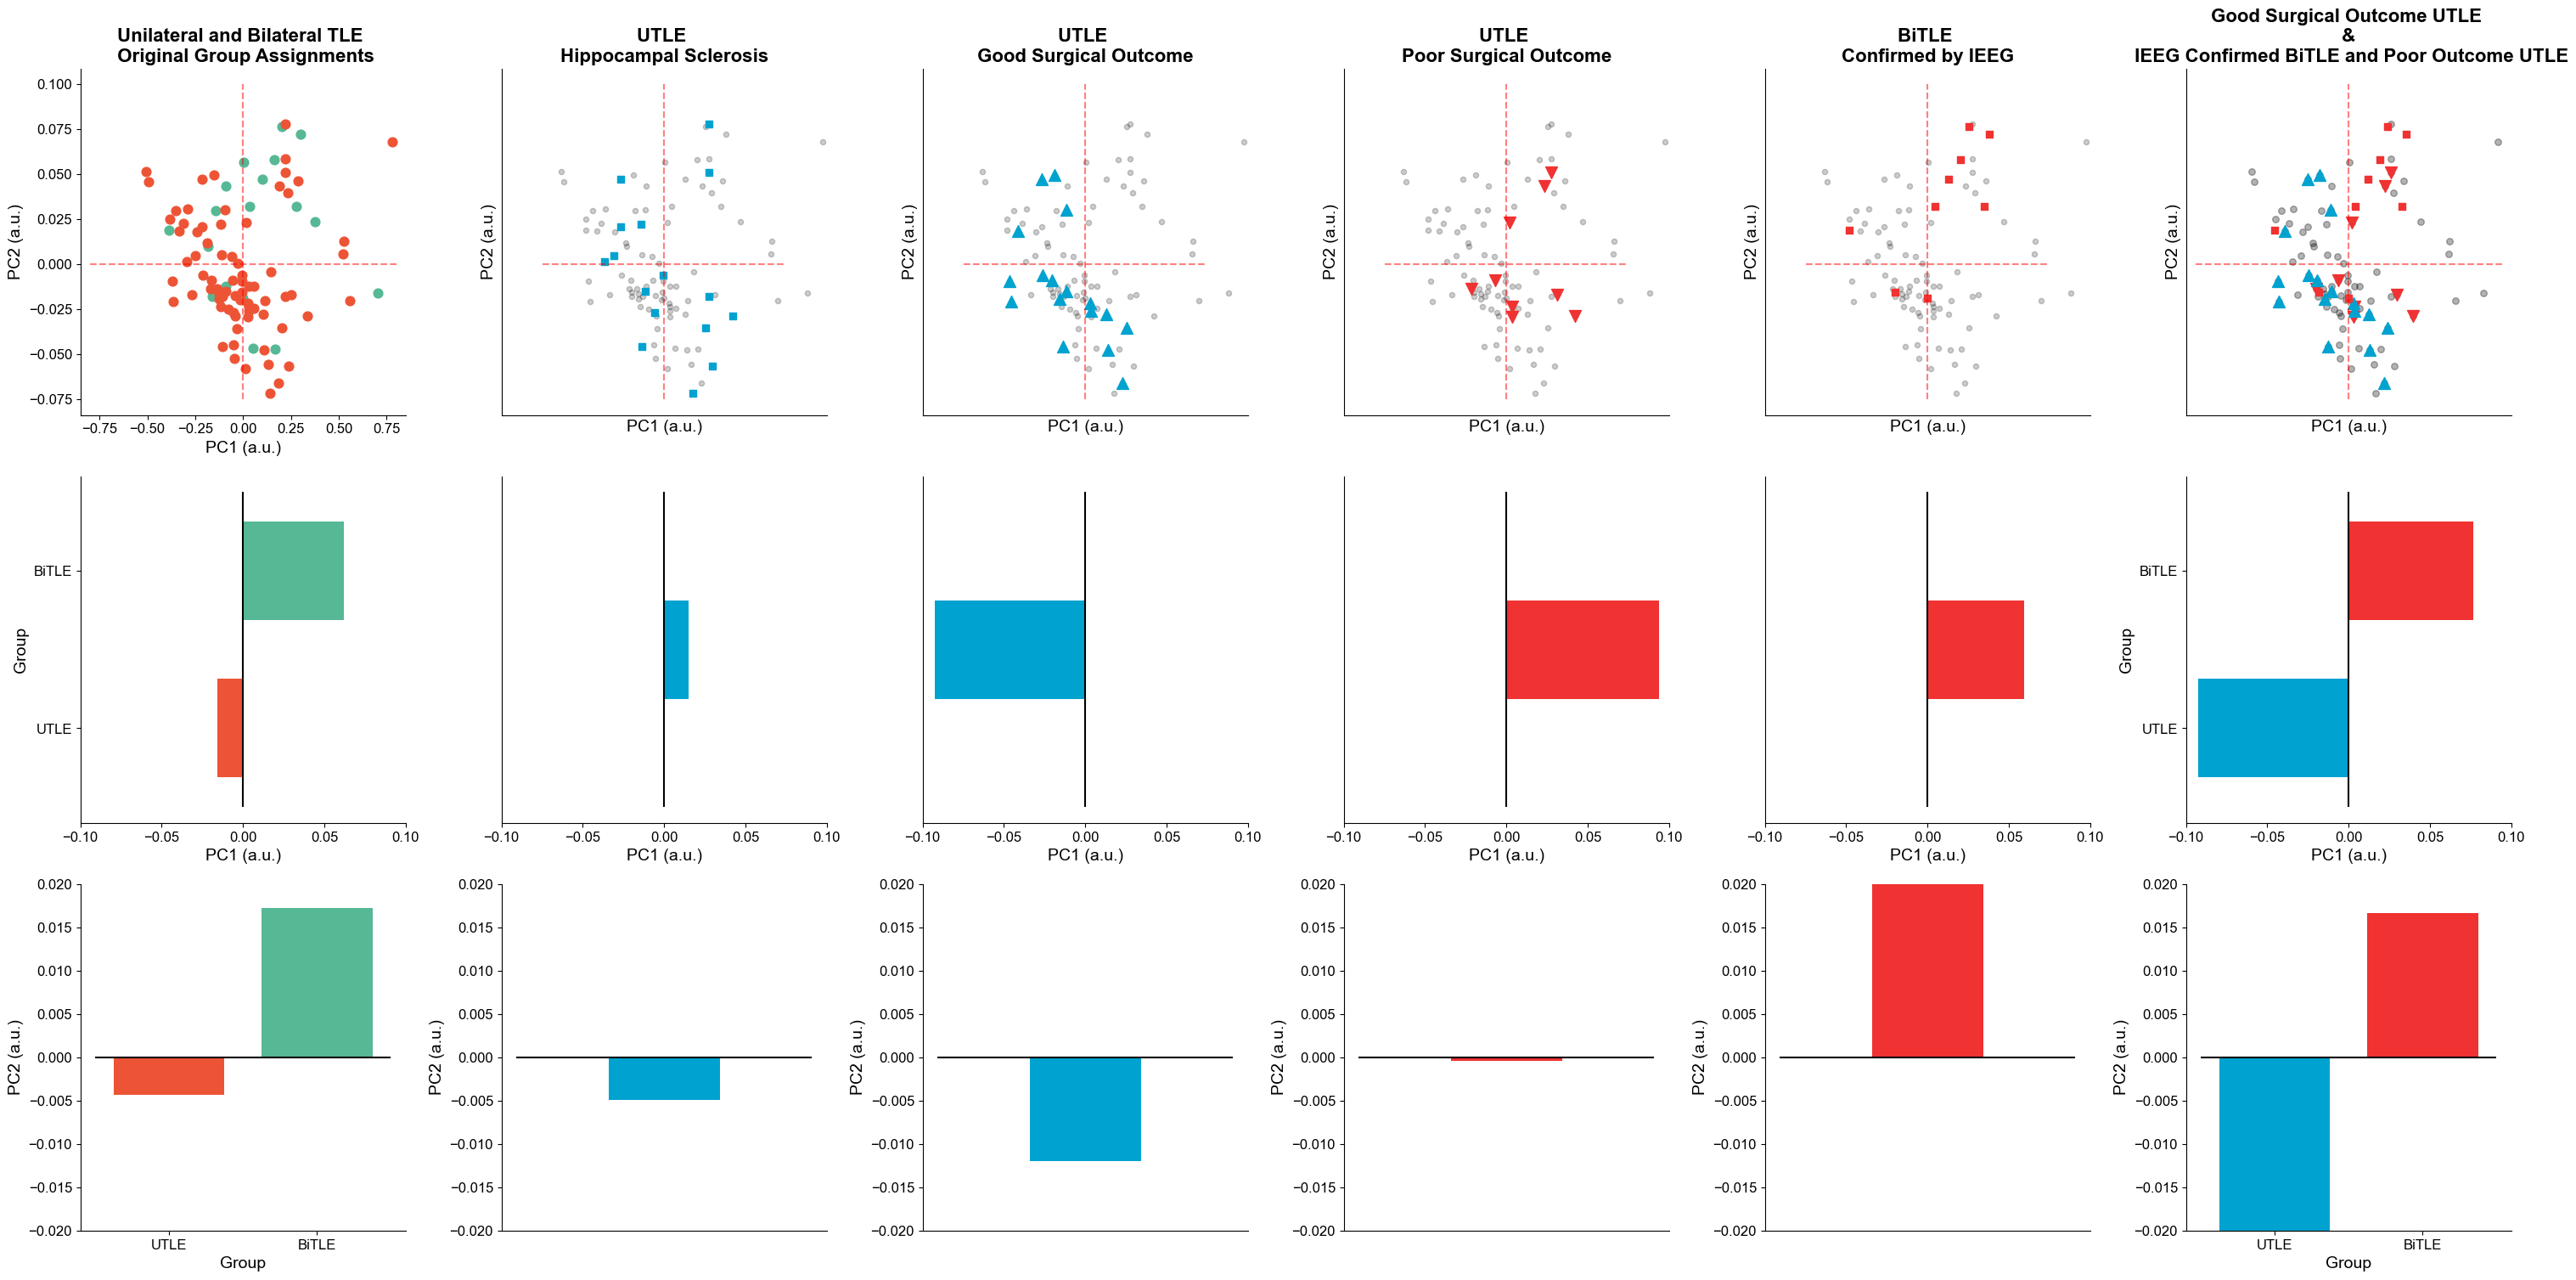

In [47]:
# Plot the mean values of the PCs in the same format as above
plt.figure(figsize=(30,15))

colors=['#56B894','#ED5435']
sns.set_palette(colors)

xmin = -0.1
xmax = 0.1
ymin = -0.02
ymax = 0.02


## First Row
plt.subplot(3,6,12+1)
plt.bar(x = 0.4, height=np.mean(X_bl_all_pca[:,1]), width=0.3)
plt.bar(x = 0, height=np.mean(X_uni_all_pca[:,1]), width=0.3)
plt.hlines(y=0, xmin=-0.2, xmax=0.6, color='k')
plt.xticks([0,0.4],['UTLE','BiTLE'])
plt.ylabel('PC2 (a.u.)', label_params)
plt.xlabel('Group', label_params)
plt.ylim([ymin,ymax])
sns.despine()

plt.subplot(3,6,6+1)
plt.barh(y=0.4, width=np.mean(X_bl_all_pca[:,0]), height=0.25)
plt.barh(y=0, width=np.mean(X_uni_all_pca[:,0]), height=0.25)
#plt.hlines(y=0, xmin=-0.2, xmax=0.6, color='k')
plt.yticks([0,0.4],['UTLE','BiTLE'])
plt.xlim([xmin,xmax])
plt.vlines(x=0, ymin=-0.2, ymax=0.6, color='k')
plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('Group', label_params)
sns.despine()

plt.subplot(3,6,1)
plt.scatter(X_bl_all_pca[:,0], X_bl_all_pca[:,1], s=60)
plt.scatter(X_uni_all_pca[:,0], X_uni_all_pca[:,1], s=60)
plt.xlim([-0.85,0.85])
sns.despine()
plt.hlines(y=0, xmin=-0.8, xmax=0.8, linestyles='--', color='r', alpha=0.5)
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.title('Unilateral and Bilateral TLE \n Original Group Assignments', title_params)
plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('PC2 (a.u.)', label_params)

## Second Row
plt.subplot(3,6,12+2)
plt.bar(x = 0.2, height=np.mean(X_uni_mts_pca[:,1]), width=0.3, color="#00a2d0")
#plt.bar(x = 0, height=np.mean(X_uni_all_pca[:,1]), width=0.3)
plt.hlines(y=0, xmin=-0.2, xmax=0.6, color='k')
plt.xticks([])
plt.ylabel('PC2 (a.u.)', label_params)
#plt.xlabel('Group', label_params)
plt.ylim([ymin,ymax])
sns.despine()

plt.subplot(3,6,6+2)
plt.barh(y=0.2, width=np.mean(X_uni_mts_pca[:,0]), height=0.125, color="#00a2d0")
#plt.barh(y=0, width=np.mean(X_uni_all_pca[:,0]), height=0.25)
#plt.hlines(y=0, xmin=-0.2, xmax=0.6, color='k')
plt.yticks([])

plt.vlines(x=0, ymin=0, ymax=0.4, color='k')

plt.xlabel('PC1 (a.u.)', label_params)
#plt.ylabel('Group', label_params)
plt.xlim([-0.1,0.1])
sns.despine()
plt.tight_layout()

plt.subplot(3,6,2)
plt.scatter(X_all_pca[:,0], X_all_pca[:,1], color='k', s=20, alpha=0.2)
plt.scatter(X_uni_mts_pca[:,0], X_uni_mts_pca[:,1], marker='s', color="#00a2d0")
sns.despine()
plt.xlim([-0.8,0.8])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.6, xmax=0.6, linestyles='--', color='r', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.title('UTLE \nHippocampal Sclerosis', title_params)
plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('PC2 (a.u.)', label_params)

## Third Row
plt.subplot(3,6,12+3)
plt.bar(x = 0.2, height=np.mean(X_uni_all_pca[outcomes_uni=='Yes',1]), width=0.3, color="#00a2d0")
#plt.bar(x = 0, height=np.mean(X_uni_all_pca[:,1]), width=0.3)
plt.hlines(y=0, xmin=-0.2, xmax=0.6, color='k')
plt.xticks([])
plt.ylabel('PC2 (a.u.)', label_params)
#plt.xlabel('Group', label_params)
plt.ylim([ymin,ymax])
sns.despine()

plt.subplot(3,6,6+3)
plt.barh(y=0.2, width=np.mean(X_uni_all_pca[outcomes_uni=='Yes',0]), height=0.125, color="#00a2d0")
#plt.barh(y=0, width=np.mean(X_uni_all_pca[:,0]), height=0.25)
#plt.hlines(y=0, xmin=-0.2, xmax=0.6, color='k')
plt.yticks([])

plt.vlines(x=0, ymin=0, ymax=0.4, color='k')

plt.xlabel('PC1 (a.u.)', label_params)
#plt.ylabel('Group', label_params)
plt.xlim([xmin, xmax])
sns.despine()
plt.tight_layout()

plt.subplot(3,6,3)
plt.scatter(X_all_pca[:,0], X_all_pca[:,1], color='k', s=20, alpha=0.2)
plt.scatter(X_uni_all_pca[outcomes_uni=='Yes',0], X_uni_all_pca[outcomes_uni=='Yes',1], marker='^', s=100, color="#00a2d0")
sns.despine()
plt.xlim([-0.8,0.8])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.6, xmax=0.6, linestyles='--', color='r', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.title('UTLE \nGood Surgical Outcome', title_params)
plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('PC2 (a.u.)', label_params)
plt.tight_layout()

# Change colors for the rest of the plots
colors = ["#f03232","#00a2d0","#feae00","#acacac"]
sns.set_palette(sns.color_palette(colors))

## Fourth Row
plt.subplot(3,6,12+4)
plt.bar(x = 0.2, height=np.mean(X_uni_all_pca[outcomes_uni=='No',1]), width=0.3, color='#f03232')
#plt.bar(x = 0, height=np.mean(X_uni_all_pca[:,1]), width=0.3)
plt.hlines(y=0, xmin=-0.2, xmax=0.6, color='k')
plt.xticks([])
plt.ylabel('PC2 (a.u.)', label_params)
#plt.xlabel('Group', label_params)
plt.ylim([ymin,ymax])
sns.despine()

plt.subplot(3,6,6+4)
plt.barh(y=0.2, width=np.mean(X_uni_all_pca[outcomes_uni=='No',0]), height=0.125, color='#f03232')
#plt.barh(y=0, width=np.mean(X_uni_all_pca[:,0]), height=0.25)
#plt.hlines(y=0, xmin=-0.2, xmax=0.6, color='k')
plt.yticks([])

plt.vlines(x=0, ymin=0, ymax=0.4, color='k')

plt.xlabel('PC1 (a.u.)', label_params)
#plt.ylabel('Group', label_params)
plt.xlim([xmin, xmax])
sns.despine()
plt.tight_layout()

plt.subplot(3,6,4)
plt.scatter(X_all_pca[:,0], X_all_pca[:,1], color='k', s=20, alpha=0.2)
#plt.scatter(X_uni_pca[:,0], X_uni_pca[:,1])
plt.scatter(X_uni_all_pca[outcomes_uni=='No',0], X_uni_all_pca[outcomes_uni=='No',1], marker='v', s=100)
#plt.scatter(X_c_pca[:,0], X_c_pca[:,1], color='k')
plt.xlim([-0.8,0.8])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.6, xmax=0.6, linestyles='--', color='r', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.title('UTLE \nPoor Surgical Outcome', title_params)
plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('PC2 (a.u.)', label_params)

plt.tight_layout()

## Fifth Row
plt.subplot(3,6,12+5)
plt.bar(x = 0.2, height=np.mean(X_ieeg_bl_pca[:,1]), width=0.3, color='#f03232')
#plt.bar(x = 0, height=np.mean(X_uni_all_pca[:,1]), width=0.3)
plt.hlines(y=0, xmin=-0.2, xmax=0.6, color='k')
plt.xticks([])
plt.ylabel('PC2 (a.u.)', label_params)
#plt.xlabel('Group', label_params)
plt.ylim([ymin,ymax])
sns.despine()

plt.subplot(3,6,6+5)
plt.barh(y=0.2, width=np.mean(X_ieeg_bl_pca[:,0]), height=0.125, color='#f03232')
#plt.barh(y=0, width=np.mean(X_uni_all_pca[:,0]), height=0.25)
#plt.hlines(y=0, xmin=-0.2, xmax=0.6, color='k')
plt.yticks([])

plt.vlines(x=0, ymin=0, ymax=0.4, color='k')

plt.xlabel('PC1 (a.u.)', label_params)
#plt.ylabel('Group', label_params)
plt.xlim([xmin, xmax])
sns.despine()
plt.tight_layout()

plt.subplot(3,6,5)
plt.scatter(X_all_pca[:,0], X_all_pca[:,1], color='k', s=20, alpha=0.2)
#plt.scatter(X_uni_pca[:,0], X_uni_pca[:,1])
plt.scatter(X_ieeg_bl_pca[:,0], X_ieeg_bl_pca[:,1], marker='s')
#plt.scatter(X_c_pca[:,0], X_c_pca[:,1], color='k')
plt.xlim([-0.8,0.8])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.6, xmax=0.6, linestyles='--', color='r', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.title('BiTLE \nConfirmed by IEEG', title_params)
plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('PC2 (a.u.)', label_params)

## Sixth Row
plt.subplot(3,6,12+6)
plt.bar(x = 0.4, height=np.mean(np.hstack([X_ieeg_bl_pca[:,1], X_uni_all_pca[outcomes_uni=='No',1]])), width=0.3, color='#f03232')
plt.bar(x = 0, height=np.mean(X_uni_all_pca[outcomes_uni=='Yes',0]), width=0.3, color="#00a2d0")
plt.hlines(y=0, xmin=-0.2, xmax=0.6, color='k')
plt.xticks([0,0.4],['UTLE','BiTLE'])
plt.ylabel('PC2 (a.u.)', label_params)
plt.xlabel('Group', label_params)
plt.ylim([ymin,ymax])
sns.despine()

plt.subplot(3,6,6+6)
plt.barh(y=0.4, width=np.mean(np.hstack([X_ieeg_bl_pca[:,0], X_uni_all_pca[outcomes_uni=='No',0]])), height=0.25, color='#f03232')
plt.barh(y=0, width=np.mean(X_uni_all_pca[outcomes_uni=='Yes',0]), height=0.25, color="#00a2d0")
#plt.hlines(y=0, xmin=-0.2, xmax=0.6, color='k')
plt.yticks([0,0.4],['UTLE','BiTLE'])

plt.vlines(x=0, ymin=-0.2, ymax=0.6, color='k')

plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('Group', label_params)
plt.xlim([xmin, xmax])
sns.despine()
plt.tight_layout()

plt.subplot(3,6,6)
plt.scatter(X_all_pca[:,0], X_all_pca[:,1],color='k', alpha=0.3, s=30)
plt.scatter(X_uni_all_pca[outcomes_uni=='No',0], X_uni_all_pca[outcomes_uni=='No',1],marker='v', s=100)
plt.scatter(X_uni_all_pca[outcomes_uni=='Yes',0], X_uni_all_pca[outcomes_uni=='Yes',1],marker='^', s=100)
plt.scatter(X_ieeg_bl_pca[:,0], X_ieeg_bl_pca[:,1], marker='s', color='#f03232')
sns.despine()
plt.xlim([-0.85,0.85])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.8, xmax=0.8, linestyles='--', color='r', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.title('Good Surgical Outcome UTLE \n&\n IEEG Confirmed BiTLE and Poor Outcome UTLE', title_params)
plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('PC2 (a.u.)', label_params)

In [48]:
# Compute the t-tests across all the PCs

print('UTLE v. BiTLE')
print('PC1: ', stats.ttest_ind(X_bl_all_pca[:,0],X_uni_all_pca[:,0]))
print('PC2: ', stats.ttest_ind(X_bl_all_pca[:,1],X_uni_all_pca[:,1]))
print('Cohen\'s D, PC1: ', cohend(X_bl_all_pca[:,0],X_uni_all_pca[:,0]))
print('Cohen\'s D, PC2: ', cohend(X_bl_all_pca[:,1],X_uni_all_pca[:,1]))

print('\n')

print('UTLE-HS (one-sample t-test)')
print('PC1: ', stats.ttest_1samp(X_uni_mts_pca[:,0], popmean=0))
print('PC2: ', stats.ttest_1samp(X_uni_mts_pca[:,1],popmean=1))
print('\n')

print('UTLE-Good Outcome (one-sample t-test)')
print('PC1: ', stats.ttest_1samp(X_uni_all_pca[outcomes_uni=='Yes',0], popmean=0))
print('PC2: ', stats.ttest_1samp(X_uni_all_pca[outcomes_uni=='Yes',0],popmean=1))
print('\n')

print('UTLE-Poor Outcome (one-sample t-test)')
print('PC1: ', stats.ttest_1samp(X_uni_all_pca[outcomes_uni=='No',0], popmean=0))
print('PC2: ', stats.ttest_1samp(X_uni_all_pca[outcomes_uni=='No',0],popmean=1))
print('\n')

print('BiTLE w/ IEEG (one-sample t-test)')
print('PC1: ', stats.ttest_1samp(X_ieeg_bl_pca[:,0], popmean=0))
print('PC2: ', stats.ttest_1samp(X_ieeg_bl_pca[:,1],popmean=1))
print('\n')

print('BiTLE w/ IEEG + Poor Outcome vs. UTLE')
print('PC1: ', stats.ttest_ind(np.hstack([X_ieeg_bl_pca[:,0], X_uni_all_pca[outcomes_uni=='No',0]]), X_uni_all_pca[outcomes_uni=='Yes',0]))
print('PC2: ', stats.ttest_ind(np.hstack([X_ieeg_bl_pca[:,1], X_uni_all_pca[outcomes_uni=='No',1]]), X_uni_all_pca[outcomes_uni=='Yes',1]))
print('Cohen\'s D, PC1: ', cohend(np.hstack([X_ieeg_bl_pca[:,0], X_uni_all_pca[outcomes_uni=='No',0]]), X_uni_all_pca[outcomes_uni=='Yes',0]))
print('Cohen\'s D, PC2: ', cohend(np.hstack([X_ieeg_bl_pca[:,1], X_uni_all_pca[outcomes_uni=='No',1]]), X_uni_all_pca[outcomes_uni=='Yes',1]))


print('BiTLE w/ IEEG vs. Poor Outcome')
print('PC1: ', stats.ttest_ind(X_ieeg_bl_pca[:,0], X_uni_all_pca[outcomes_uni=='No',0]))
print('PC2: ', stats.ttest_ind(X_ieeg_bl_pca[:,1], X_uni_all_pca[outcomes_uni=='No',1]))

print('BiTLE w/ IEEG vs. Good Outcome')
print('PC1: ', stats.ttest_ind(X_ieeg_bl_pca[:,0], X_uni_all_pca[outcomes_uni=='Yes',0]))
print('PC2: ', stats.ttest_ind(X_ieeg_bl_pca[:,1], X_uni_all_pca[outcomes_uni=='Yes',1]))

print('Poor Outcome vs. Good Outcome')
print('PC1: ', stats.ttest_ind(X_uni_all_pca[outcomes_uni=='No',0], X_uni_all_pca[outcomes_uni=='Yes',0]))
print('PC2: ', stats.ttest_ind(X_uni_all_pca[outcomes_uni=='No',1], X_uni_all_pca[outcomes_uni=='Yes',1]))
#print('Cohen\'s D, PC1: ', cohend(np.hstack([X_ieeg_bl_pca[:,0], X_uni_all_pca[outcomes_uni=='No',0]]), X_uni_all_pca[outcomes_uni=='Yes',0]))
#print('Cohen\'s D, PC2: ', cohend(np.hstack([X_ieeg_bl_pca[:,1], X_uni_all_pca[outcomes_uni=='No',1]]), X_uni_all_pca[outcomes_uni=='Yes',1]))



UTLE v. BiTLE
PC1:  Ttest_indResult(statistic=1.247658224109352, pvalue=0.21532267289462734)
PC2:  Ttest_indResult(statistic=2.4691223325506804, pvalue=0.015390167897749364)
Cohen's D, PC1:  0.3239458247556978
Cohen's D, PC2:  0.6415499463253648


UTLE-HS (one-sample t-test)
PC1:  TtestResult(statistic=0.29096436249423324, pvalue=0.7750631551958379, df=15)
PC2:  TtestResult(statistic=-97.87274313426548, pvalue=1.8307237302792757e-22, df=15)


UTLE-Good Outcome (one-sample t-test)
PC1:  TtestResult(statistic=-2.1065731794698688, pvalue=0.05129224688840937, df=16)
PC2:  TtestResult(statistic=-24.93984446248166, pvalue=3.107507384791551e-14, df=16)


UTLE-Poor Outcome (one-sample t-test)
PC1:  TtestResult(statistic=1.712544129892803, pvalue=0.12515239388977417, df=8)
PC2:  TtestResult(statistic=-16.542505309940577, pvalue=1.8003052329022797e-07, df=8)


BiTLE w/ IEEG (one-sample t-test)
PC1:  TtestResult(statistic=0.8058465794824644, pvalue=0.44362298440027326, df=8)
PC2:  TtestResult(sta

#### Weightings of the integration-segregation axis

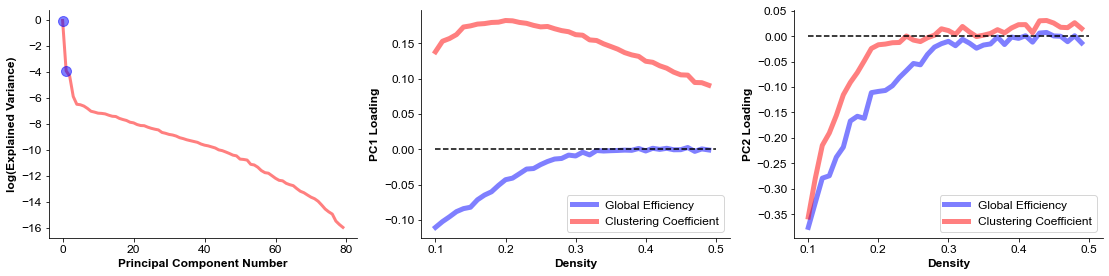

In [114]:
# Supplementary figure 1

plt.figure(figsize=(15,4))
plt.subplot(132)
plt.plot(densities,pca.components_[0,:40], linewidth=5, color='b', alpha=0.5)
plt.plot(densities,pca.components_[0,40:], linewidth=5, color='r', alpha=0.5)
plt.legend(['Global Efficiency','Clustering Coefficient'])
plt.ylabel('PC1 Loading',weight='bold', size=12)
plt.xlabel('Density',weight='bold', size=12)
plt.hlines(y=0, xmin=0.1, xmax=0.50, linestyles='--', color='k')
sns.despine()

plt.subplot(133)
plt.plot(densities,pca.components_[1,:40], linewidth=5, color='b', alpha=0.5)
plt.plot(densities,pca.components_[1,40:], linewidth=5, color='r', alpha=0.5)
plt.legend(['Global Efficiency','Clustering Coefficient'])
plt.ylabel('PC2 Loading',weight='bold', size=12)
plt.xlabel('Density',weight='bold', size=12)
plt.hlines(y=0, xmin=0.1, xmax=0.50, linestyles='--', color='k')
plt.tight_layout()
sns.despine()

plt.subplot(131)
plt.plot(np.log(pca.explained_variance_ratio_), linewidth=3, alpha=0.5, color='r')
sns.despine()
plt.xlabel('Principal Component Number',weight='bold', size=12)
plt.ylabel('log(Explained Variance)',weight='bold', size=12)
plt.plot(0,np.log(pca.explained_variance_ratio_)[0], marker='o', color='b', alpha=0.5, markersize=10)
plt.plot(1,np.log(pca.explained_variance_ratio_)[1], marker='o', color='b', alpha=0.5, markersize=10)


#### Sensitivity and Specificity of Different Quadrants in the Integration-Segregation Axis

In [129]:
def print_sensitivity_specificity(tp,fn,fp,tn):
    a = tp
    b = fn
    c = fp
    d = tn

    print('Sensitivity: ', a/(a+b), ', Specificity: ', d/(c+d))

In [130]:
# In the original UTLE and BiTLE group assignments

print('Right Upper Quadrant')
a = np.sum((X_bl_all_pca[:,0]>0) & (X_bl_all_pca[:,1]>0))
b = np.sum((X_bl_all_pca[:,0]<0) & (X_bl_all_pca[:,1]>0)) + np.sum((X_bl_all_pca[:,0]<0) & (X_bl_all_pca[:,1]<0)) + np.sum((X_bl_all_pca[:,0]>0) & (X_bl_all_pca[:,1]<0))
c = np.sum((X_uni_all_pca[:,0]>0) & (X_uni_all_pca[:,1]>0))
d = np.sum((X_uni_all_pca[:,0]<0) & (X_uni_all_pca[:,1]>0)) + np.sum((X_uni_all_pca[:,0]<0) & (X_uni_all_pca[:,1]<0)) + np.sum((X_uni_all_pca[:,0]>0) & (X_uni_all_pca[:,1]<0))
print('True Positives:',a)


print('False Negatives',b)

print('False Positives:',c)

print('True Negatives',d)

print_sensitivity_specificity(a,b,c,d)
print('\n')

print('Left Upper Quadrant')
a = np.sum((X_bl_all_pca[:,0]<0) & (X_bl_all_pca[:,1]>0))
b = np.sum((X_bl_all_pca[:,0]>0) & (X_bl_all_pca[:,1]>0)) + np.sum((X_bl_all_pca[:,0]<0) & (X_bl_all_pca[:,1]<0)) + np.sum((X_bl_all_pca[:,0]>0) & (X_bl_all_pca[:,1]<0))
c = np.sum((X_uni_all_pca[:,0]<0) & (X_uni_all_pca[:,1]>0))
d = np.sum((X_uni_all_pca[:,0]>0) & (X_uni_all_pca[:,1]>0)) + np.sum((X_uni_all_pca[:,0]<0) & (X_uni_all_pca[:,1]<0)) + np.sum((X_uni_all_pca[:,0]>0) & (X_uni_all_pca[:,1]<0))
print('True Positives:',a)

print('False Negatives',b)

print('False Positives:',c)

print('True Negatives',d)
print_sensitivity_specificity(a,b,c,d)
print('\n')

print('Left Lower Quadrant')
a = np.sum((X_bl_all_pca[:,0]<0) & (X_bl_all_pca[:,1]<0))
b = np.sum((X_bl_all_pca[:,0]<0) & (X_bl_all_pca[:,1]>0)) + np.sum((X_bl_all_pca[:,0]>0) & (X_bl_all_pca[:,1]>0)) + np.sum((X_bl_all_pca[:,0]>0) & (X_bl_all_pca[:,1]<0))
c = np.sum((X_uni_all_pca[:,0]<0) & (X_uni_all_pca[:,1]<0))
d = np.sum((X_uni_all_pca[:,0]<0) & (X_uni_all_pca[:,1]>0)) + np.sum((X_uni_all_pca[:,0]>0) & (X_uni_all_pca[:,1]>0)) + np.sum((X_uni_all_pca[:,0]>0) & (X_uni_all_pca[:,1]<0))
print('True Positives:',a)

print('False Negatives',b)

print('False Positives:',c)

print('True Negatives',d)
print_sensitivity_specificity(a,b,c,d)

print('\n')


print('Right Lower Quadrant')
a = np.sum((X_bl_all_pca[:,0]>0) & (X_bl_all_pca[:,1]<0))
b = np.sum((X_bl_all_pca[:,0]<0) & (X_bl_all_pca[:,1]>0)) + np.sum((X_bl_all_pca[:,0]>0) & (X_bl_all_pca[:,1]>0)) + np.sum((X_bl_all_pca[:,0]<0) & (X_bl_all_pca[:,1]<0))
c = np.sum((X_uni_all_pca[:,0]>0) & (X_uni_all_pca[:,1]<0))
d = np.sum((X_uni_all_pca[:,0]<0) & (X_uni_all_pca[:,1]>0)) + np.sum((X_uni_all_pca[:,0]>0) & (X_uni_all_pca[:,1]>0)) + np.sum((X_uni_all_pca[:,0]<0) & (X_uni_all_pca[:,1]<0))
print('True Positives:',a)

print('False Negatives',b)

print('False Positives:',c)

print('True Negatives',d)

print_sensitivity_specificity(a,b,c,d)


print('\n')

Right Upper Quadrant
True Positives: 8
False Negatives 11
False Positives: 10
True Negatives 65
Sensitivity:  0.42105263157894735 , Specificity:  0.8666666666666667


Left Upper Quadrant
True Positives: 4
False Negatives 15
False Positives: 19
True Negatives 56
Sensitivity:  0.21052631578947367 , Specificity:  0.7466666666666667


Left Lower Quadrant
True Positives: 4
False Negatives 15
False Positives: 25
True Negatives 50
Sensitivity:  0.21052631578947367 , Specificity:  0.6666666666666666


Right Lower Quadrant
True Positives: 3
False Negatives 16
False Positives: 21
True Negatives 54
Sensitivity:  0.15789473684210525 , Specificity:  0.72




In [131]:
X_bl_unibo_pred = np.vstack([X_uni_all_pca[outcomes_uni=='No',:], X_ieeg_bl_pca])
X_uni_pred = X_uni_all_pca[outcomes_uni=='Yes',:]

In [132]:
# Sensitivity and Specificity per Quadrant

print('Right Upper Quadrant')
a = np.sum((X_bl_unibo_pred[:,0]>0) & (X_bl_unibo_pred[:,1]>0))
b = np.sum((X_bl_unibo_pred[:,0]<0) & (X_bl_unibo_pred[:,1]>0)) + np.sum((X_bl_unibo_pred[:,0]<0) & (X_bl_unibo_pred[:,1]<0)) + np.sum((X_bl_unibo_pred[:,0]>0) & (X_bl_unibo_pred[:,1]<0))
c = np.sum((X_uni_pred[:,0]>0) & (X_uni_pred[:,1]>0))
d = np.sum((X_uni_pred[:,0]<0) & (X_uni_pred[:,1]>0)) + np.sum((X_uni_pred[:,0]<0) & (X_uni_pred[:,1]<0)) + np.sum((X_uni_pred[:,0]>0) & (X_uni_pred[:,1]<0))
print('True Positives:',a)

print('False Negatives',b)

print('False Positives:',c)

print('True Negatives',d)

print_sensitivity_specificity(a,b,c,d)
print('\n')

print('Left Upper Quadrant')
a = np.sum((X_bl_unibo_pred[:,0]<0) & (X_bl_unibo_pred[:,1]>0))
b = np.sum((X_bl_unibo_pred[:,0]>0) & (X_bl_unibo_pred[:,1]>0)) + np.sum((X_bl_unibo_pred[:,0]<0) & (X_bl_unibo_pred[:,1]<0)) + np.sum((X_bl_unibo_pred[:,0]>0) & (X_bl_unibo_pred[:,1]<0))
c = np.sum((X_uni_pred[:,0]<0) & (X_uni_pred[:,1]>0))
d = np.sum((X_uni_pred[:,0]>0) & (X_uni_pred[:,1]>0)) + np.sum((X_uni_pred[:,0]<0) & (X_uni_pred[:,1]<0)) + np.sum((X_uni_pred[:,0]>0) & (X_uni_pred[:,1]<0))
print('True Positives:', a)

print('False Negatives',b)

print('False Positives:',c)

print('True Negatives',d)
print_sensitivity_specificity(a,b,c,d)
print('\n')

print('Left Lower Quadrant')
a = np.sum((X_bl_unibo_pred[:,0]<0) & (X_bl_unibo_pred[:,1]<0))
b = np.sum((X_bl_unibo_pred[:,0]<0) & (X_bl_unibo_pred[:,1]>0)) + np.sum((X_bl_unibo_pred[:,0]>0) & (X_bl_unibo_pred[:,1]>0)) + np.sum((X_bl_unibo_pred[:,0]>0) & (X_bl_unibo_pred[:,1]<0))
c = np.sum((X_uni_pred[:,0]<0) & (X_uni_pred[:,1]<0))
d = np.sum((X_uni_pred[:,0]<0) & (X_uni_pred[:,1]>0)) + np.sum((X_uni_pred[:,0]>0) & (X_uni_pred[:,1]>0)) + np.sum((X_uni_pred[:,0]>0) & (X_uni_pred[:,1]<0))
print('True Positives:',a)

print('False Negatives',b)

print('False Positives:',c)

print('True Negatives',d)
print_sensitivity_specificity(a,b,c,d)

print('\n')


print('Right Lower Quadrant')
a = np.sum((X_bl_unibo_pred[:,0]>0) & (X_bl_unibo_pred[:,1]<0))
b = np.sum((X_bl_unibo_pred[:,0]<0) & (X_bl_unibo_pred[:,1]>0)) + np.sum((X_bl_unibo_pred[:,0]>0) & (X_bl_unibo_pred[:,1]>0)) + np.sum((X_bl_unibo_pred[:,0]<0) & (X_bl_unibo_pred[:,1]<0))
c = np.sum((X_uni_pred[:,0]>0) & (X_uni_pred[:,1]<0))
d = np.sum((X_uni_pred[:,0]<0) & (X_uni_pred[:,1]>0)) + np.sum((X_uni_pred[:,0]>0) & (X_uni_pred[:,1]>0)) + np.sum((X_uni_pred[:,0]<0) & (X_uni_pred[:,1]<0))
print('True Positives:',a)

print('False Negatives', b)

print('False Positives:',c)

print('True Negatives', d)
print_sensitivity_specificity(a,b,c,d)
print('\n')


Right Upper Quadrant
True Positives: 9
False Negatives 9
False Positives: 0
True Negatives 17
Sensitivity:  0.5 , Specificity:  1.0


Left Upper Quadrant
True Positives: 1
False Negatives 17
False Positives: 4
True Negatives 13
Sensitivity:  0.05555555555555555 , Specificity:  0.7647058823529411


Left Lower Quadrant
True Positives: 4
False Negatives 14
False Positives: 7
True Negatives 10
Sensitivity:  0.2222222222222222 , Specificity:  0.5882352941176471


Right Lower Quadrant
True Positives: 4
False Negatives 14
False Positives: 6
True Negatives 11
Sensitivity:  0.2222222222222222 , Specificity:  0.6470588235294118




## Supplementary Analysis Figures: Original analysis, but with updated group assignments

The updated group assignments consists of:
- Patients with a distributed network are those that either have a poor-outcome unilateral TLE or those patients with intracranial EEG, which where deemed to have bilateral seizure onset
- Patients with unilateral TLE, and a focal network, are those that had good outcomes after unilateral surgery

In [134]:
# This code block allows to pick different versions of the protocols for subsequent analyses

skip = True

if skip==False:
    version = 1

    df_epilepsy_blv2 = pd.concat([df_epilepsy[ ((df_epilepsy['IEEG']=='IEEG') & (df_epilepsy['Bilateral']==True) & (df_epilepsy['version']==version)) ], outcomes[(outcomes['Good_outcome']=='No') & (outcomes['version']==version)]])
    df_epilepsy_blv2['Bilateral_v2'] = True
    df_epilepsy_univ2 = outcomes[(outcomes['Good_outcome']=='Yes') & (outcomes['version']==version)]
    df_epilepsy_univ2['Bilateral_v2'] = False


In [135]:
# df_epilepsy_blv2 = df_epilepsy[ ((df_epilepsy['IEEG']=='IEEG') & (df_epilepsy['Bilateral']==True)) ]
# df_epilepsy_blv2['Bilateral_v2'] = True
# df_epilepsy_univ2 = outcomes[(outcomes['Good_outcome']=='No')]
# df_epilepsy_univ2['Bilateral_v2'] = False


In [136]:
# Pick sub-groups for subsequent analyses

df_epilepsy_blv2 = pd.concat([df_epilepsy[ ((df_epilepsy['IEEG']=='IEEG') & (df_epilepsy['Bilateral']==True)) ], outcomes[(outcomes['Good_outcome']=='No')]])
df_epilepsy_blv2['Bilateral_v2'] = True
df_epilepsy_univ2 = outcomes[(outcomes['Good_outcome']=='Yes')]
df_epilepsy_univ2['Bilateral_v2'] = False


<ipython-input-136-a19c31b20de7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epilepsy_univ2['Bilateral_v2'] = False


Significant:  38 > 12 , p-value:  0.013986013986013986


array([0.23646775, 0.0541371 , 0.01498008, 0.01225089, 0.00674801,
       0.00305843, 0.00252647, 0.00229826, 0.00324644, 0.00306782,
       0.00209797, 0.00304948, 0.00353069, 0.00280504, 0.00269041,
       0.00223047, 0.00366343, 0.0039393 , 0.00320799, 0.00370486,
       0.00238631, 0.00364509, 0.00262247, 0.00343039, 0.00496307,
       0.00250616, 0.00566243, 0.00208681, 0.00710447, 0.00272157,
       0.00698715, 0.00567207, 0.0081665 , 0.00429551, 0.00313109,
       0.01649771, 0.00205176, 0.00540738, 0.00760451, 0.00379164])

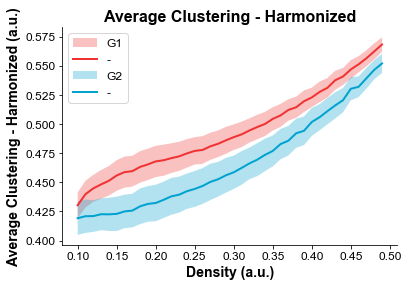

In [137]:
df_epilepsy_v2 = pd.concat([df_epilepsy_blv2, df_epilepsy_univ2])
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Average Clustering - Harmonized','Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy_v2,'Average Clustering - Harmonized','Bilateral_v2')


Significant:  15 > 4 , p-value:  0.005994005994005994


array([1.40751997e-04, 1.52332361e-04, 1.95201084e-04, 2.28608396e-04,
       1.10032817e-04, 3.76633306e-04, 4.13177931e-04, 3.68548360e-03,
       1.33851667e-03, 9.85779419e-05, 4.12204121e-04, 9.00633971e-05,
       7.98603006e-05, 4.60757320e-03, 4.57980461e-04, 5.58719663e-02,
       1.74568071e-04, 3.23628107e-03, 6.27704299e-02, 2.57046586e-02,
       5.09047087e-01, 2.48735004e-01, 5.72903673e-01, 9.46002659e-01,
       5.26616996e-01, 1.21332106e-01, 3.34520240e-01, 6.77217496e-02,
       3.87584669e-02, 3.14861695e-02, 9.81532080e-02, 9.98369678e-01,
       3.39569455e-01, 3.61222504e-01, 8.95465386e-01, 1.02721002e-01,
       4.04735450e-01, 6.85540116e-01, 3.36265137e-01, 9.78922318e-01])

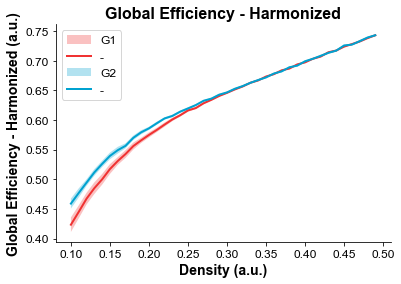

In [138]:
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Global Efficiency - Harmonized','Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy_v2,'Global Efficiency - Harmonized','Bilateral_v2')


Significant:  19 > 5 , p-value:  0.000999000999000999


array([7.06571467e-01, 9.00984103e-01, 5.24694243e-01, 4.08275431e-02,
       1.11706551e-02, 2.68208034e-03, 3.68853360e-03, 5.21674263e-03,
       2.00023337e-03, 9.18952993e-04, 4.98253822e-04, 7.85183242e-05,
       9.86674704e-05, 1.57205090e-03, 1.95684084e-04, 2.96859397e-03,
       6.48928820e-05, 2.97839322e-04, 1.44372201e-03, 3.15677321e-04,
       2.88713242e-02, 1.15883006e-02, 9.23656982e-02, 2.73912039e-01,
       1.42241819e-01, 4.26836901e-01, 1.47766732e-01, 1.53889917e-01,
       2.31045175e-02, 4.64714381e-02, 7.50067252e-02, 9.41048061e-01,
       3.17162365e-01, 3.74896159e-01, 9.15533229e-01, 9.78865436e-02,
       4.10304182e-01, 6.79901944e-01, 3.40748196e-01, 9.72228966e-01])

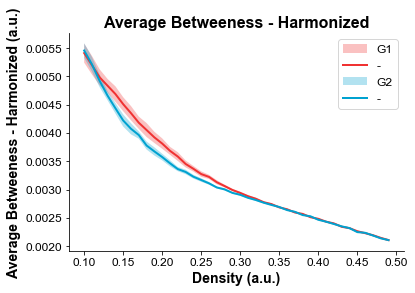

In [144]:
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Average Betweeness - Harmonized','Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy_v2,'Average Betweeness - Harmonized','Bilateral_v2')


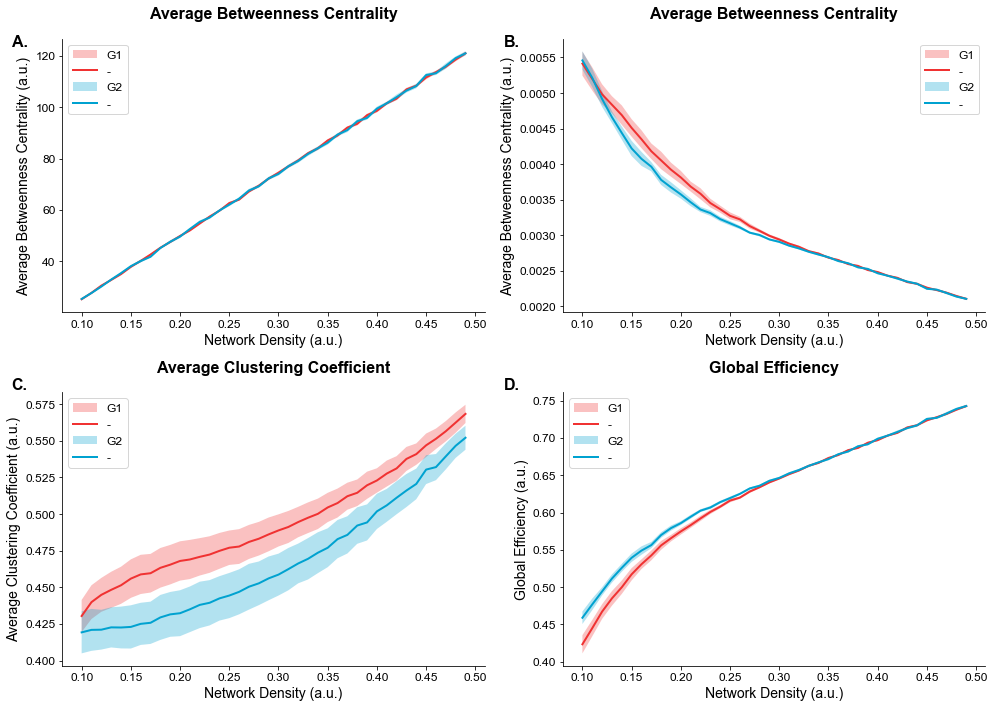

In [140]:
plt.figure(figsize=(14,10))
plt.subplot(221)
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Average Degree - Harmonized','Bilateral')
plt.ylabel('Average Betweenness Centrality (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Average Betweenness Centrality', title_params, pad=20)

plt.subplot(222)
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Average Betweeness - Harmonized','Bilateral')
plt.ylabel('Average Betweenness Centrality (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Average Betweenness Centrality', title_params, pad=20)

plt.subplot(223)
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Average Clustering - Harmonized','Bilateral')
plt.ylabel('Average Clustering Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Average Clustering Coefficient', title_params, pad=20)

plt.subplot(224)
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Global Efficiency - Harmonized','Bilateral')
plt.ylabel('Global Efficiency (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Global Efficiency', title_params, pad=20)

plt.tight_layout()
plt.text(-0.48,1.225,'A.',title_params)
plt.text(0.02,1.225,'B.',title_params)
plt.text(0.02,0.765,'D.',title_params)
plt.text(-0.48,0.765,'C.',title_params)

plt.savefig('/Users/allucas/Documents/research/CNT/P7_ML_fMRI/reports/final_version_v3/Epilepsia_submission/revision_v1/figures/supplementary/network_metrics_new_groups.pdf')

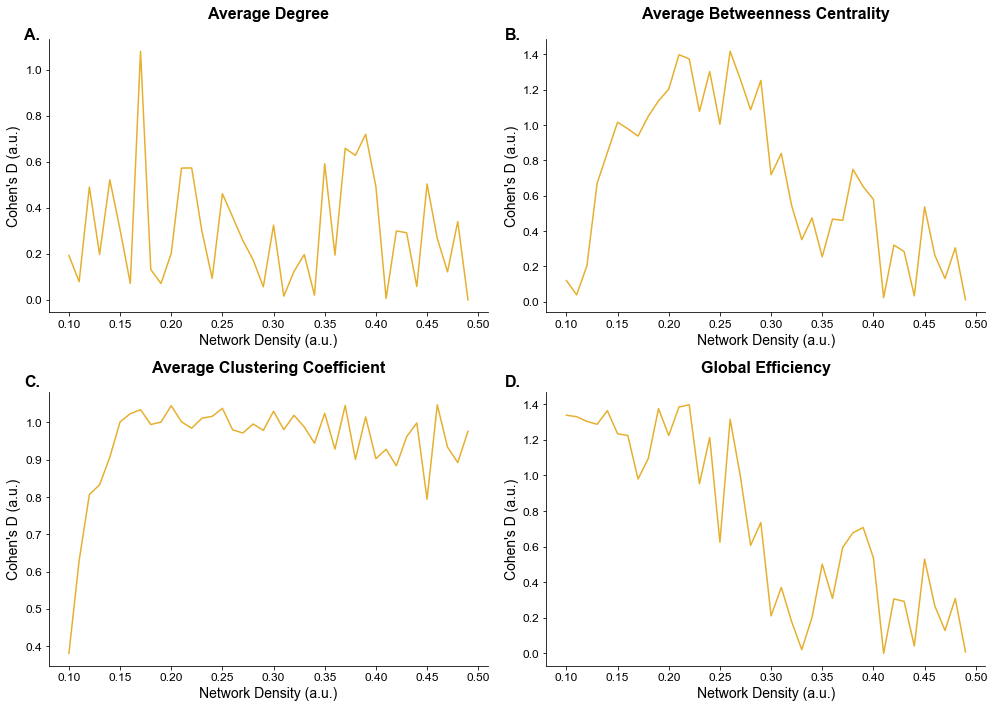

In [369]:
plt.figure(figsize=(14,10))
plt.subplot(221)
#plt.text(-0.1,2,'A')
plot_metrics_cohend(df_epilepsy_v2,'Average Degree - Harmonized','Bilateral_v2')
plt.ylabel('Cohen\'s D (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Average Degree', title_params, pad=20)

plt.subplot(222)
plot_metrics_cohend(df_epilepsy_v2,'Average Betweeness - Harmonized','Bilateral_v2')
plt.ylabel('Cohen\'s D (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Average Betweenness Centrality', title_params, pad=20)

plt.subplot(223)
plot_metrics_cohend(df_epilepsy_v2,'Average Clustering - Harmonized','Bilateral_v2')
plt.ylabel('Cohen\'s D (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Average Clustering Coefficient', title_params, pad=20)

plt.subplot(224)
plot_metrics_cohend(df_epilepsy_v2,'Global Efficiency - Harmonized','Bilateral_v2')
plt.ylabel('Cohen\'s D (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Global Efficiency', title_params, pad=20)

plt.tight_layout()
plt.text(-0.43,3.45,'A.',title_params)
plt.text(0.04,3.45,'B.',title_params)
plt.text(0.04,1.5,'D.',title_params)
plt.text(-0.43,1.5,'C.',title_params)

plt.savefig('/Users/allucas/Documents/research/CNT/P7_ML_fMRI/reports/final_version_v3/Epilepsia_submission/revision_v1/figures/supplementary/cohens_d_network_metrics.pdf')

Significant:  15 > 6 , p-value:  0.02197802197802198


array([0.00278983, 0.00356127, 0.00340564, 0.00251328, 0.00148957,
       0.00389594, 0.00658123, 0.017641  , 0.01298954, 0.00598533,
       0.0080228 , 0.00963471, 0.01036069, 0.0330678 , 0.02361447,
       0.07020204, 0.02173101, 0.04408429, 0.08620091, 0.06671145,
       0.14842059, 0.13149261, 0.20581724, 0.19587452, 0.14151673,
       0.33929616, 0.13014738, 0.41870831, 0.11317688, 0.45028077,
       0.14781273, 0.2936789 , 0.18040792, 0.32618779, 0.26821373,
       0.17897303, 0.39439697, 0.30903726, 0.22508196, 0.26607401])

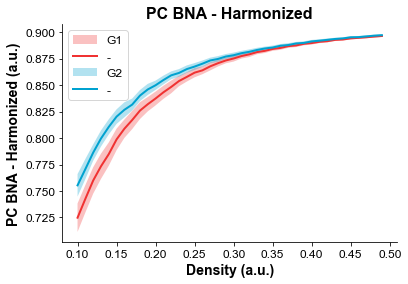

In [146]:
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'PC BNA - Harmonized','Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy_v2,'PC BNA - Harmonized','Bilateral_v2')


Significant:  40 > 5 , p-value:  0.000999000999000999


array([6.94366153e-04, 6.09502793e-04, 2.59464119e-04, 6.62114045e-05,
       7.61708879e-05, 1.00429102e-04, 7.88388805e-05, 2.64862197e-04,
       1.03870171e-04, 1.75639577e-04, 2.14024459e-04, 3.38762862e-05,
       2.29225856e-04, 1.57390123e-04, 1.37522450e-04, 9.92054221e-05,
       2.05090165e-04, 9.74488661e-05, 2.01614219e-04, 1.89766300e-04,
       2.17274954e-04, 4.89548777e-04, 8.60006937e-04, 3.44041657e-04,
       1.45400848e-03, 8.89638925e-04, 8.09469690e-04, 8.04442417e-04,
       7.57443969e-04, 7.93761435e-04, 2.27469760e-03, 9.20295265e-04,
       2.23724471e-03, 1.41571148e-03, 4.60134139e-04, 6.35032760e-04,
       1.51952488e-03, 1.68072317e-03, 3.95821321e-03, 4.90059806e-04])

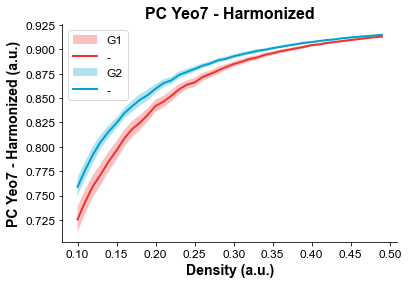

In [147]:
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'PC Yeo7 - Harmonized','Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy_v2,'PC Yeo7 - Harmonized','Bilateral_v2')


Significant:  40 > 8 , p-value:  0.000999000999000999


array([9.13660783e-04, 8.96659518e-04, 4.76668996e-04, 1.45888445e-04,
       2.25405393e-04, 2.59484445e-04, 2.05065340e-04, 5.07813948e-04,
       2.45955806e-04, 2.18334195e-04, 2.72845712e-04, 3.74343628e-05,
       1.51280632e-04, 1.25264269e-04, 9.49341007e-05, 1.20068207e-04,
       2.71261763e-04, 1.05428317e-04, 2.70691734e-04, 3.06662094e-04,
       4.05419595e-04, 8.51794348e-04, 1.40390450e-03, 5.20744814e-04,
       4.55908074e-03, 2.46681789e-03, 2.60473628e-03, 2.24551327e-03,
       2.73339597e-03, 2.28947535e-03, 1.05616112e-02, 4.08486435e-03,
       1.11999599e-02, 8.09097073e-03, 2.86672672e-03, 5.08687634e-03,
       8.56755787e-03, 2.79207812e-02, 3.25420604e-02, 1.48289354e-02])

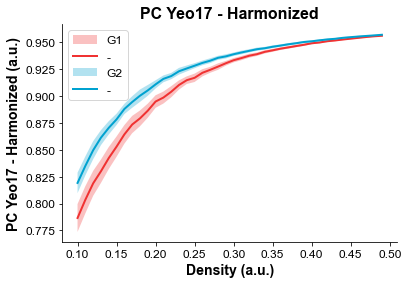

In [148]:
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'PC Yeo17 - Harmonized','Bilateral_v2')
get_suprathreshold_cluster_stat(df_epilepsy_v2,'PC Yeo17 - Harmonized','Bilateral_v2')


In [149]:
df_participation_v2 = pd.merge(df_participation, df_epilepsy_v2[['Subject','Bilateral_v2']], on='Subject')

Frontal_L
Not significant:  0 < 7 , p-value:  0.18181818181818182


Frontal_R
Not significant:  0 < 12 , p-value:  0.22377622377622378


Temporal_L
Significant:  12 > 9 , p-value:  0.03796203796203796


Temporal_R
Not significant:  0 < 11 , p-value:  0.11788211788211789


Parietal_L
Not significant:  0 < 12 , p-value:  0.23676323676323677


Parietal_R
Not significant:  0 < 13 , p-value:  0.1928071928071928


Insular_L
Not significant:  0 < 12 , p-value:  0.22677322677322678


Insular_R
Not significant:  0 < 12 , p-value:  0.21678321678321677


Limbic_L
Not significant:  0 < 12 , p-value:  0.22077922077922077


Limbic_R
Not significant:  3 < 11 , p-value:  0.12887112887112886


Occipital_L
Not significant:  0 < 12 , p-value:  0.16283716283716285


Occipital_R
Not significant:  0 < 13 , p-value:  0.14585414585414586


Subcortical_L
Significant:  40 > 10 , p-value:  0.000999000999000999


Subcortical_R
Significant:  22 > 8 , p-value:  0.011988011988011988




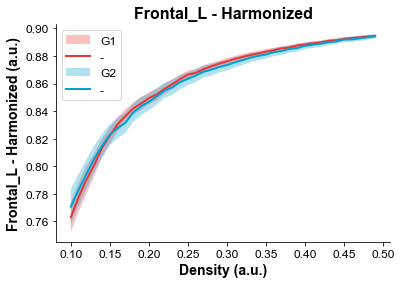

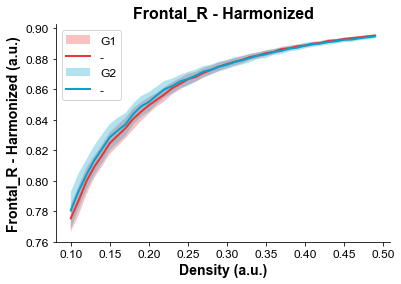

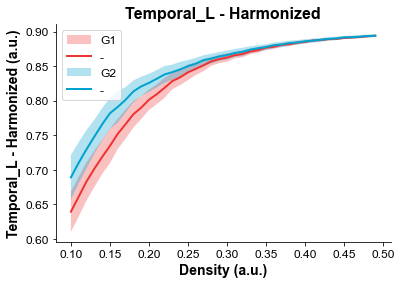

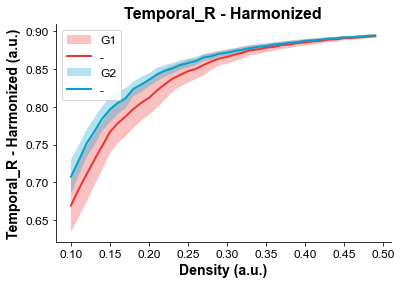

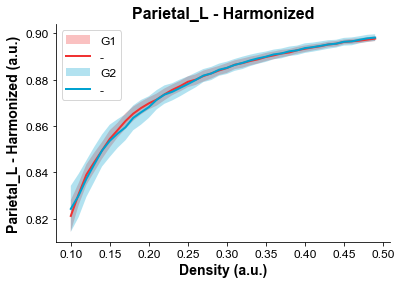

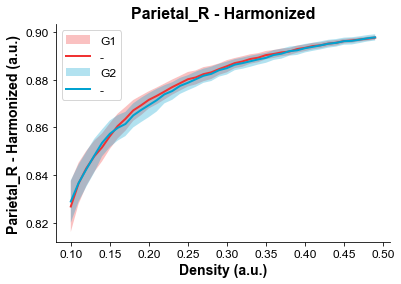

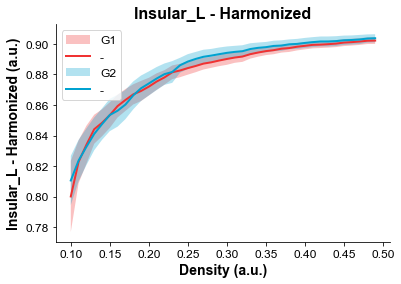

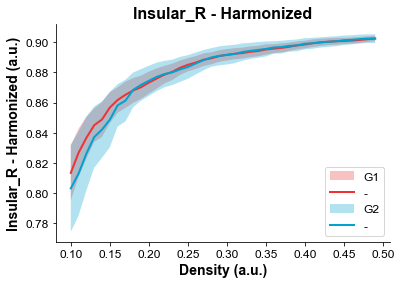

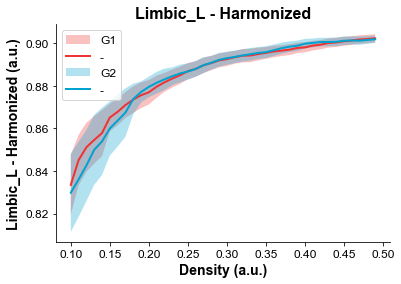

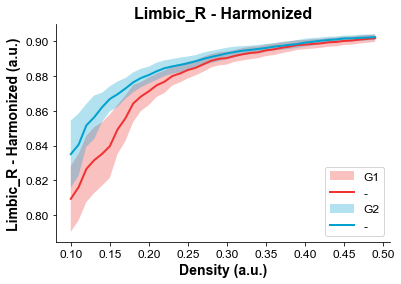

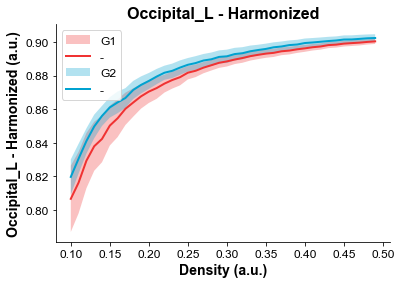

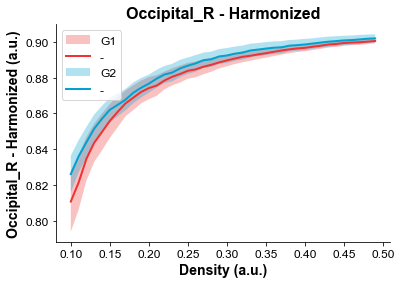

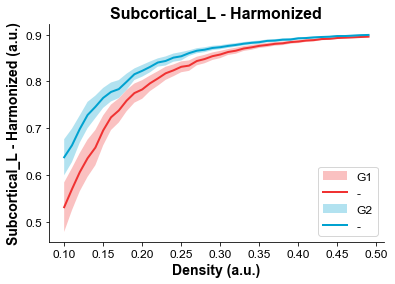

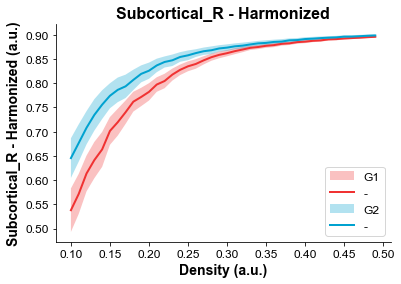

In [150]:
for i in range(len(community_values_bna)):
    plt.figure()
    plot_metrics(df_participation_v2[(df_participation_v2['Bilateral_v2']==True)], df_participation_v2[(df_participation_v2['Bilateral_v2']==False)],community_names_bna[i]+' - Harmonized','Bilateral')
    print(community_names_bna[i])
    get_suprathreshold_cluster_stat(df_participation_v2,community_names_bna[i]+' - Harmonized','Bilateral_v2')
    print('\n')

Visual L
Significant:  26 > 6 , p-value:  0.013986013986013986


Somatomotor L
Not significant:  0 < 9 , p-value:  0.18081918081918083


Dorsal Attention L
Not significant:  5 < 7 , p-value:  0.058941058941058944


Ventral Attention L
Not significant:  0 < 10 , p-value:  0.18681318681318682


Limbic L
Significant:  40 > 10 , p-value:  0.000999000999000999


Frontoparietal L
Not significant:  6 < 12 , p-value:  0.06793206793206794


Default L
Significant:  10 > 8 , p-value:  0.04295704295704296


Visual R
Significant:  20 > 8 , p-value:  0.023976023976023976


Somatomotor R
Not significant:  0 < 5 , p-value:  0.1798201798201798


Dorsal Attention R
Not significant:  2 < 8 , p-value:  0.10789210789210789


Ventral Attention R
Not significant:  1 < 10 , p-value:  0.12887112887112886


Limbic R
Significant:  27 > 10 , p-value:  0.00999000999000999


Frontoparietal R
Not significant:  0 < 5 , p-value:  0.12187812187812187


Default R
Not significant:  0 < 9 , p-value:  0.16483516483516483



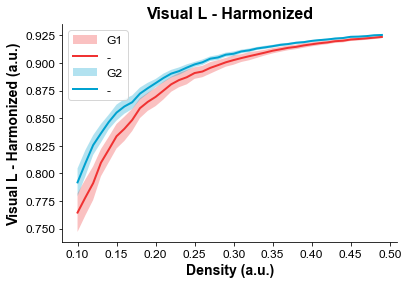

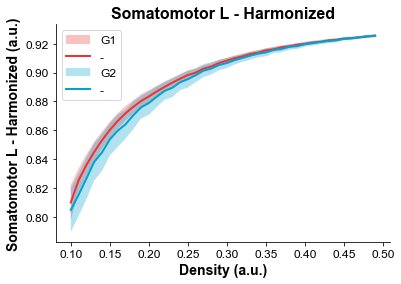

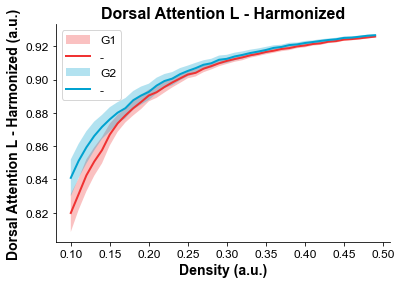

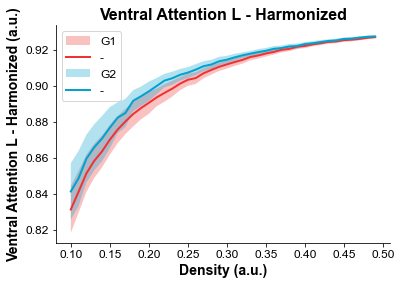

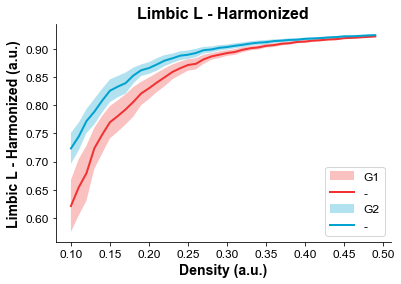

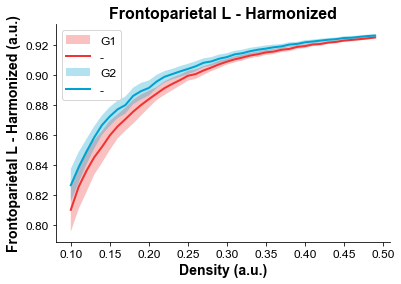

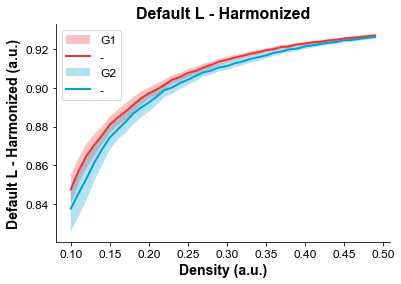

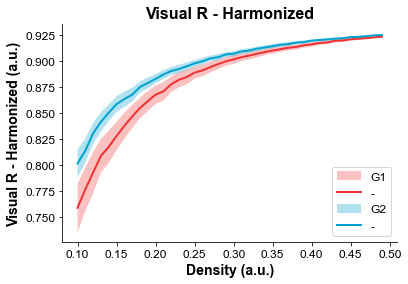

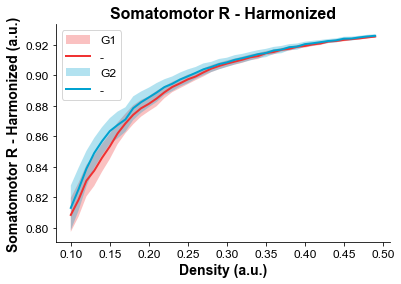

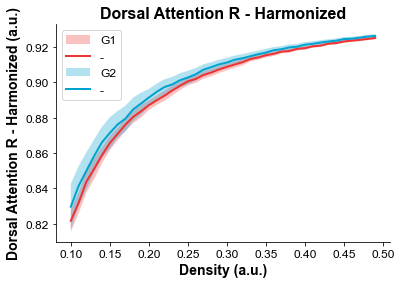

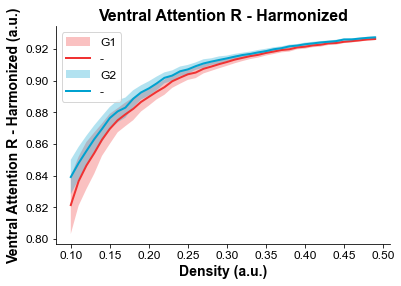

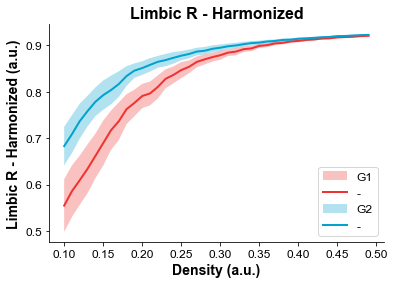

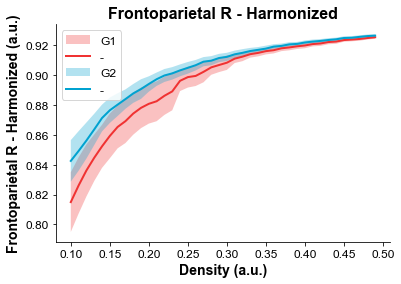

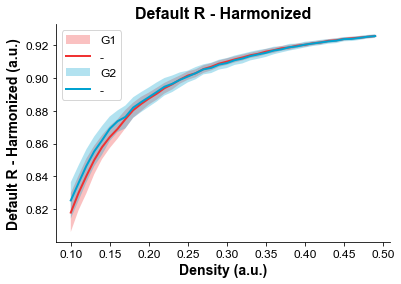

In [151]:
for i in range(len(community_values_yeo7)):
    plt.figure()
    plot_metrics(df_participation_v2[(df_participation_v2['Bilateral_v2']==True)], df_participation_v2[(df_participation_v2['Bilateral_v2']==False)],community_names_yeo7[i]+' - Harmonized','Bilateral')
    print(community_names_yeo7[i])
    get_suprathreshold_cluster_stat(df_participation_v2,community_names_yeo7[i]+' - Harmonized','Bilateral_v2')
    print('\n')

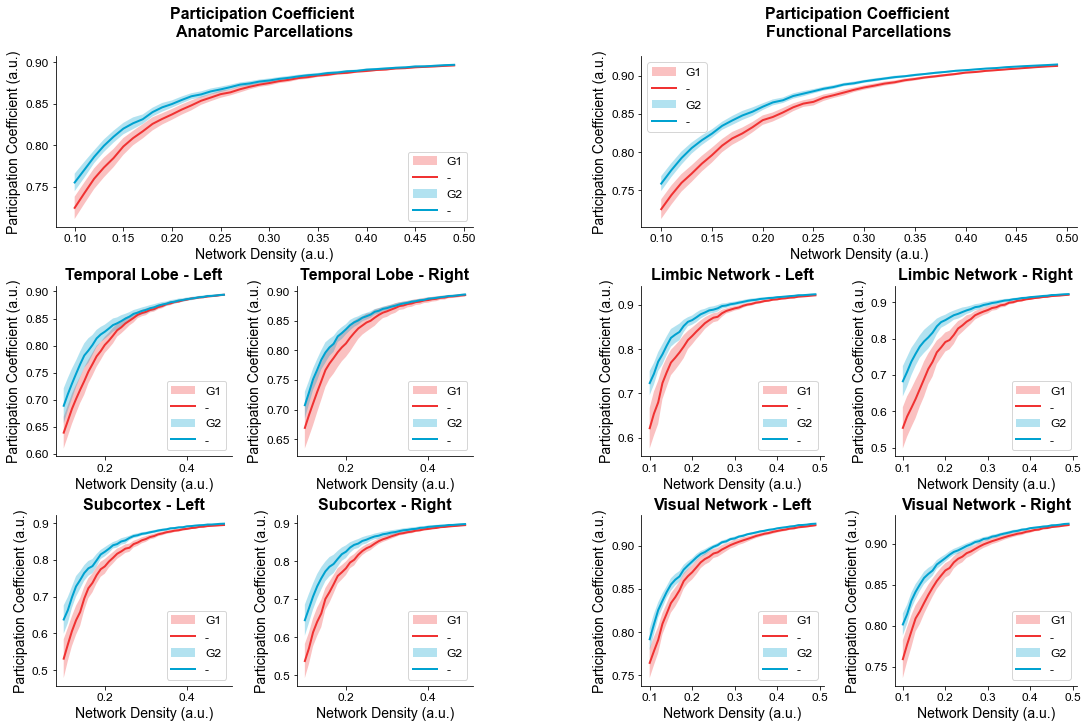

In [152]:
# Combined figure
fig3 = plt.figure(constrained_layout=True, figsize=(15,10))
gs = fig3.add_gridspec(3, 10)

f3_ax1 = fig3.add_subplot(gs[0, :4])
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'PC BNA - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Participation Coefficient \nAnatomic Parcellations', title_params, pad=20)

f3_ax3 = fig3.add_subplot(gs[1, 0:2])
plot_metrics(df_participation_v2[(df_participation_v2['Bilateral_v2']==True)], df_participation_v2[(df_participation_v2['Bilateral_v2']==False)],'Temporal_L - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Temporal Lobe - Left', title_params)

f3_ax3 = fig3.add_subplot(gs[1, 2:4])
plot_metrics(df_participation_v2[(df_participation_v2['Bilateral_v2']==True)], df_participation_v2[(df_participation_v2['Bilateral_v2']==False)],'Temporal_R - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Temporal Lobe - Right', title_params)


f3_ax3 = fig3.add_subplot(gs[2, 0:2])
plot_metrics(df_participation_v2[(df_participation_v2['Bilateral_v2']==True)], df_participation_v2[(df_participation_v2['Bilateral_v2']==False)],'Subcortical_L - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Subcortex - Left', title_params)

f3_ax3 = fig3.add_subplot(gs[2, 2:4])
plot_metrics(df_participation_v2[(df_participation_v2['Bilateral_v2']==True)], df_participation_v2[(df_participation_v2['Bilateral_v2']==False)],'Subcortical_R - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Subcortex - Right', title_params)


f3_ax2 = fig3.add_subplot(gs[0, 6:])
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'PC Yeo7 - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Participation Coefficient \nFunctional Parcellations', title_params, pad=20)

f3_ax3 = fig3.add_subplot(gs[1, 6:8])
plot_metrics(df_participation_v2[(df_participation_v2['Bilateral_v2']==True)], df_participation_v2[(df_participation_v2['Bilateral_v2']==False)],'Limbic L - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Limbic Network - Left', title_params)


f3_ax3 = fig3.add_subplot(gs[1, 8:])
plot_metrics(df_participation_v2[(df_participation_v2['Bilateral_v2']==True)], df_participation_v2[(df_participation_v2['Bilateral_v2']==False)],'Limbic R - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Limbic Network - Right', title_params)

f3_ax3 = fig3.add_subplot(gs[2, 6:8])
plot_metrics(df_participation_v2[(df_participation_v2['Bilateral_v2']==True)], df_participation_v2[(df_participation_v2['Bilateral_v2']==False)],'Visual L - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Visual Network - Left', title_params)

f3_ax3 = fig3.add_subplot(gs[2, 8:])
plot_metrics(df_participation_v2[(df_participation_v2['Bilateral_v2']==True)], df_participation_v2[(df_participation_v2['Bilateral_v2']==False)],'Visual R - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Visual Network - Right', title_params)

plt.savefig('/Users/allucas/Documents/research/CNT/P7_ML_fMRI/reports/final_version_v3/Epilepsia_submission/revision_v1/figures/supplementary/participation_coefficient_new_groups.pdf')

Significant:  7 > 4 , p-value:  0.006993006993006993


array([4.06628221e-04, 6.45806862e-04, 1.70513327e-03, 3.31436853e-03,
       1.37891906e-04, 4.94328752e-03, 1.87486466e-02, 7.78325183e-02,
       3.40993205e-01, 8.58978178e-02, 1.80162117e-01, 1.77105390e-01,
       9.60746677e-01, 1.95005909e-01, 8.10008146e-01, 7.12566361e-01,
       4.38271338e-01, 4.84554833e-01, 1.81980008e-01, 5.09292594e-01,
       6.15359856e-01, 5.58212215e-01, 2.92117276e-01, 7.30050915e-01,
       2.58197224e-01, 3.44589629e-01, 2.00939262e-01, 1.68225642e-01,
       6.72508906e-01, 8.35459235e-02, 3.26991859e-01, 2.72944082e-01,
       4.02554983e-01, 6.09336405e-02, 7.60601021e-01, 9.73919300e-02,
       6.10871506e-02, 6.79615663e-01, 3.30397377e-02, 8.95426125e-02])

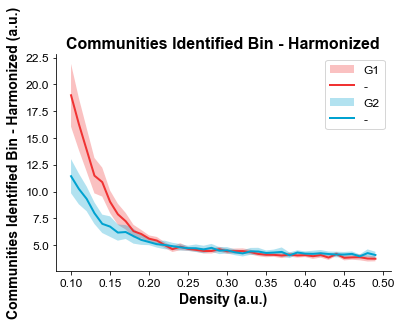

In [117]:
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Communities Identified Bin - Harmonized','Bilateral_v2')
get_suprathreshold_cluster_stat(df_epilepsy_v2,'Communities Identified Bin - Harmonized','Bilateral_v2')


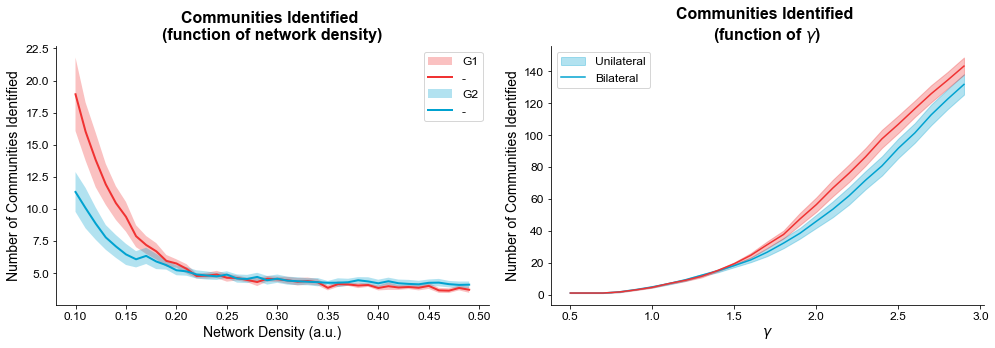

In [153]:
# Making this function again but with different colors
def plot_communities_fill(df_network_metrics_density, metric, by, save=False):
    groups = list(set(list(df_network_metrics_density[by].values)))
    if len(groups)==2:
        colors= ["#00a2d0","#f03232"]
    for i in range(len(groups)):
        mean_vals = np.mean(df_network_metrics_density[df_network_metrics_density[by]==groups[i]][metric].values, axis=0)
        std_vals = np.std(df_network_metrics_density[df_network_metrics_density[by]==groups[i]][metric].values, axis=0)
        n_subjects = np.array(df_network_metrics_density[df_network_metrics_density[by]==groups[i]][metric]).shape[0]
        conf = std_vals*(1.96)/(np.sqrt(n_subjects))
        densities = np.arange(0.5,3,0.1)
        plt.fill_between(densities, mean_vals+conf, mean_vals-conf, alpha=0.3, color=colors[i])
        plt.plot(densities, mean_vals,'-', color=colors[i])

    plt.legend(['Unilateral','Bilateral'])

    plt.ylabel('Number of Communities Detected', weight='bold', size=12)
    plt.xlabel('$\gamma$',weight='bold', size=12)
    plt.title(metric, weight='bold', size=12)
    sns.despine()

# Combined plot
plt.figure(figsize=(14,5))
plt.subplot(121)
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Communities Identified Bin - Harmonized','Bilateral_v2')
plt.title('Communities Identified \n(function of network density)', title_params)
plt.ylabel('Number of Communities Identified', label_params)
plt.xlabel('Network Density (a.u.)', label_params)

plt.subplot(122)
plot_communities_fill(df_epilepsy_v2,'Communities Identified Di - Harmonized','Bilateral_v2')
plt.title('Communities Identified \n(function of $\gamma$)', title_params)
plt.ylabel('Number of Communities Identified', label_params)
plt.xlabel('$\gamma$', label_params)
plt.tight_layout()

plt.savefig('/Users/allucas/Documents/research/CNT/P7_ML_fMRI/reports/final_version_v3/Epilepsia_submission/revision_v1/figures/supplementary/communities_found_new_groups.pdf')

#### Check that the demographics for the new sub-groups are comparable in terms of age, disease duration and gender

In [ ]:
print('Age: DENH', np.mean(df_epilepsy_v2[df_epilepsy_v2['Bilateral_v2']==True]['Age'].values),'+/-',np.std(df_epilepsy_v2[df_epilepsy_v2['Bilateral_v2']==True]['Age'].values),
', UTLE: ', np.mean(df_epilepsy_v2[df_epilepsy_v2['Bilateral_v2']==False]['Age'].values),'+/-',np.std(df_epilepsy_v2[df_epilepsy_v2['Bilateral_v2']==False]['Age'].values),
', p-value:', stats.ttest_ind(df_epilepsy_v2[df_epilepsy_v2['Bilateral_v2']==True]['Age'].values,df_epilepsy_v2[df_epilepsy_v2['Bilateral_v2']==False]['Age'].values)[1])

print('Duration: DENH', np.mean(df_epilepsy_v2[df_epilepsy_v2['Bilateral_v2']==True]['Duration'].values),'+/-',np.std(df_epilepsy_v2[df_epilepsy_v2['Bilateral_v2']==True]['Duration'].values),
', UTLE: ', np.mean(df_epilepsy_v2[df_epilepsy_v2['Bilateral_v2']==False]['Duration'].values),'+/-',np.std(df_epilepsy_v2[df_epilepsy_v2['Bilateral_v2']==False]['Duration'].values),
', p-value:', stats.ttest_ind(df_epilepsy_v2[df_epilepsy_v2['Bilateral_v2']==True]['Duration'].values,df_epilepsy_v2[df_epilepsy_v2['Bilateral_v2']==False]['Duration'].values)[1])

Age: DENH 35.44166666666666 +/- 9.736867936981698 , UTLE:  37.42941176470588 +/- 12.439584100570071 , p-value: 0.5793091287553678
Duration: DENH 18.129166666666666 +/- 12.933950130266554 , UTLE:  17.988235294117647 +/- 14.399178177240909 , p-value: 0.9746554659434059


## Sub-Analysis With Controls

In [320]:
# for plotting
def plot_metrics_control(df_network_metrics_density, df_control,metric, by, save=False):
    groups = list(set(list(df_network_metrics_density[by].values)))
    if len(groups)==2:
        colors=['#ED5435','#56B894']
    for i in range(len(groups)):
        mean_vals = np.mean(df_network_metrics_density[df_network_metrics_density[by]==groups[i]][metric].values, axis=0)
        std_vals = np.std(df_network_metrics_density[df_network_metrics_density[by]==groups[i]][metric].values, axis=0)
        n_subjects = np.array(df_network_metrics_density[df_network_metrics_density[by]==groups[i]][metric]).shape[0]
        conf = std_vals*(1.96)/(np.sqrt(n_subjects))
        densities = np.arange(0.1,0.5,0.01)
        #plt.fill_between(densities, mean_vals+conf, mean_vals-conf, alpha=0.3, color=colors[i])
        plt.plot(densities, mean_vals,'-', color=colors[i], linewidth=2)
    df_network_metrics_density = df_control
    mean_vals = np.mean(df_network_metrics_density[metric].values, axis=0)
    std_vals = np.std(df_network_metrics_density[metric].values, axis=0)
    n_subjects = np.array(df_network_metrics_density[metric]).shape[0]
    conf = std_vals*(1.96)/(np.sqrt(n_subjects))
    densities = np.arange(0.1,0.5,0.01)
    #plt.fill_between(densities, mean_vals+conf, mean_vals-conf, alpha=0.3, color='black')
    plt.plot(densities, mean_vals,'--', color='black', linewidth=2)

    plt.legend(['Unilateral','Bilateral','Control'])

    plt.ylabel(metric + ' (a.u.)', weight='bold', size=12)
    plt.xlabel('Density (a.u.)',weight='bold', size=12)
    plt.title(metric, weight='bold', size=12)
    sns.despine()

In [321]:
f = open('/Users/allucas/Documents/research/CNT/P7_ML_fMRI/code/revisions/df_control_penn_uol_unharm.p', 'rb')
df_control = pickle.load(f)

In [322]:
df_control.columns

Index(['Subject', 'SzOnset', 'Final_Loc', 'Control', 'Age', 'Duration',
       'Cohort', 'Final_Lat', 'RNS', 'fcon', 'version', 'Bilateral',
       'Average Clustering', 'Global Efficiency', 'Average Degree',
       'Average Betweeness'],
      dtype='object')

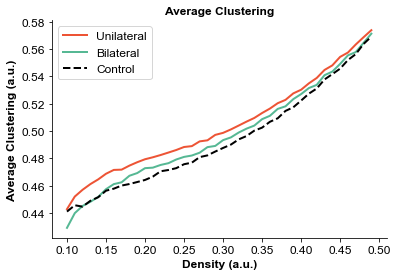

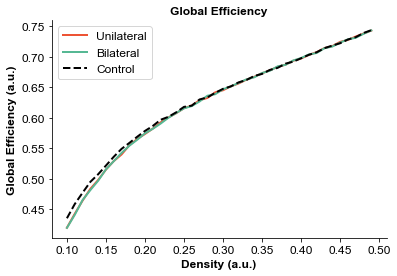

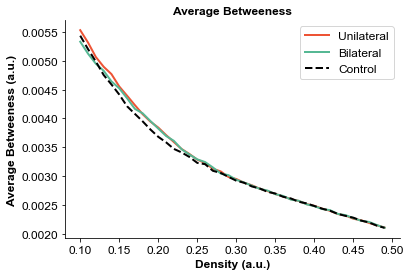

In [435]:
plot_metrics_control(df_epilepsy_v2, df_control,'Average Clustering','Bilateral_v2')
plt.figure()
plot_metrics_control(df_epilepsy_v2, df_control,'Global Efficiency','Bilateral_v2')
plt.figure()
plot_metrics_control(df_epilepsy_v2, df_control,'Average Betweeness','Bilateral_v2')


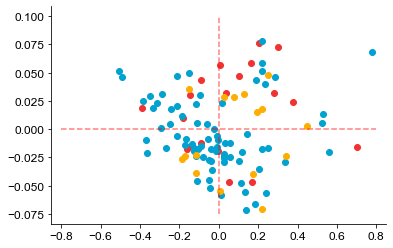

In [324]:
# Control subjects in integration-segregation axis

ge_c = np.vstack(df_control['Global Efficiency'].values)
cc_c = np.vstack(df_control['Average Clustering'].values)

X_c = np.hstack([ge_c, cc_c])

X_c_pca = pca.transform(X_c)


# Original all bilateral and unilateral subjects
plt.figure(figsize=(6,4))

#plt.scatter(X_all_pca[:,0], X_all_pca[:,1],color='k', alpha=0.3, s=30)
plt.scatter(X_bl_all_pca[:,0], X_bl_all_pca[:,1])
plt.scatter(X_uni_all_pca[:,0], X_uni_all_pca[:,1])

plt.scatter(X_c_pca[:,0], X_c_pca[:,1])


sns.despine()
plt.xlim([-0.85,0.85])
sns.despine()
plt.hlines(y=0, xmin=-0.8, xmax=0.8, linestyles='--', color='r', alpha=0.5)
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)


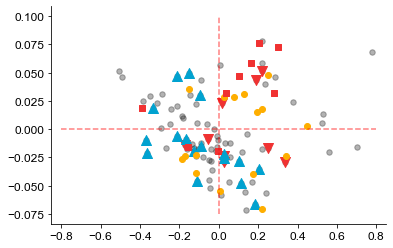

In [325]:
plt.figure(figsize=(6,4))

plt.scatter(X_all_pca[:,0], X_all_pca[:,1],color='k', alpha=0.3, s=30)
plt.scatter(X_uni_all_pca[outcomes_uni=='No',0], X_uni_all_pca[outcomes_uni=='No',1],marker='v', s=100)
plt.scatter(X_uni_all_pca[outcomes_uni=='Yes',0], X_uni_all_pca[outcomes_uni=='Yes',1],marker='^', s=100)

plt.scatter(X_c_pca[:,0], X_c_pca[:,1])


#plt.scatter(np.mean(X_uni_pca[outcomes_uni=='No',0]),np.mean(X_uni_pca[outcomes_uni=='No',1]))
#plt.scatter(np.mean(X_uni_pca[outcomes_uni=='Yes',0]),np.mean(X_uni_pca[outcomes_uni=='Yes',1]))
plt.scatter(X_ieeg_bl_pca[:,0], X_ieeg_bl_pca[:,1], marker='s', color='#f03232')
#plt.scatter(X_uni_mts_pca[:,0], X_uni_mts_pca[:,1], marker='s', color='k')
#plt.scatter(X_c_pca[:,0], X_c_pca[:,1], marker='s', color='k')

sns.despine()
plt.xlim([-0.85,0.85])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.8, xmax=0.8, linestyles='--', color='r', alpha=0.5)

UTLE v. C:  Ttest_indResult(statistic=-2.7064329489531755, pvalue=0.010958222849128252)
UTLE v. BiTLE:  Ttest_indResult(statistic=-2.6930126581845015, pvalue=0.011040066126867382)
BiTLE v. C:  Ttest_indResult(statistic=0.11743869402512735, pvalue=0.9072464532681771)


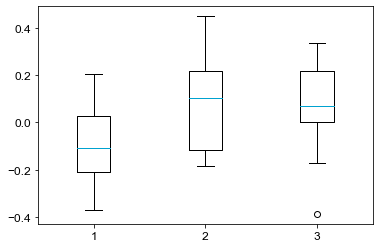

In [326]:
plt.boxplot([X_uni_all_pca[outcomes_uni=='Yes',0],X_c_pca[:,0],np.hstack([X_ieeg_bl_pca[:,0],X_uni_all_pca[outcomes_uni=='No',0]])])
print('UTLE v. C: ',stats.ttest_ind(X_uni_all_pca[outcomes_uni=='Yes',0],X_c_pca[:,0]))
print('UTLE v. BiTLE: ',stats.ttest_ind(X_uni_all_pca[outcomes_uni=='Yes',0],np.hstack([X_ieeg_bl_pca[:,0],X_uni_all_pca[outcomes_uni=='No',0]])))
print('BiTLE v. C: ',stats.ttest_ind(X_c_pca[:,0],np.hstack([X_ieeg_bl_pca[:,0],X_uni_all_pca[outcomes_uni=='No',0]])))

UTLE v. C:  Ttest_indResult(statistic=-0.5226448313619075, pvalue=0.6049369374417527)
UTLE v. BiTLE:  Ttest_indResult(statistic=-2.4557206742898305, pvalue=0.01949526238307935)
BiTLE v. C:  Ttest_indResult(statistic=-1.796515898572249, pvalue=0.0818585842533192)


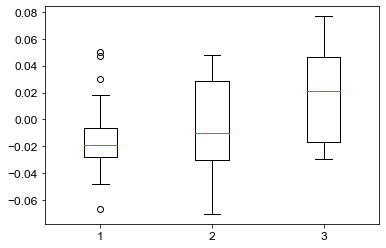

In [327]:
plt.boxplot([X_uni_all_pca[outcomes_uni=='Yes',1],X_c_pca[:,1],np.hstack([X_ieeg_bl_pca[:,1],X_uni_all_pca[outcomes_uni=='No',1]])])
print('UTLE v. C: ',stats.ttest_ind(X_uni_all_pca[outcomes_uni=='Yes',1],X_c_pca[:,1]))
print('UTLE v. BiTLE: ',stats.ttest_ind(X_uni_all_pca[outcomes_uni=='Yes',1],np.hstack([X_ieeg_bl_pca[:,1],X_uni_all_pca[outcomes_uni=='No',1]])))
print('BiTLE v. C: ',stats.ttest_ind(X_c_pca[:,1],np.hstack([X_ieeg_bl_pca[:,1],X_uni_all_pca[outcomes_uni=='No',1]])))

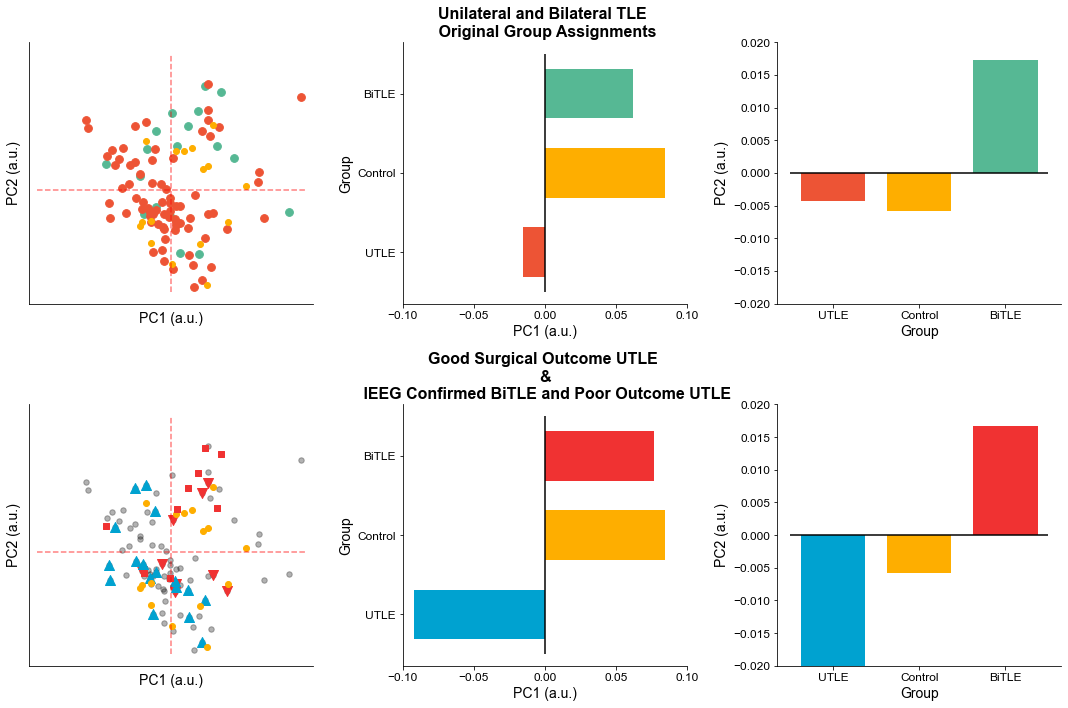

In [349]:
# Figure including controls in the integration-segregation axis


plt.figure(figsize=(15,10))

# Top row
plt.subplot(2,3,3)
plt.bar(x = 0.4, height=np.mean(X_bl_all_pca[:,1]), width=0.3, color='#56B894')
plt.bar(x=0, height=np.mean(X_c_pca[:,1]), width=0.3, color="#feae00")
plt.bar(x = -0.4, height=np.mean(X_uni_all_pca[:,1]), width=0.3, color='#ED5435')
plt.hlines(y=0, xmin=-0.6, xmax=0.6, color='k')
plt.xticks([-0.4,0,0.4],['UTLE','Control','BiTLE'])
plt.ylabel('PC2 (a.u.)', label_params)
plt.xlabel('Group', label_params)
plt.ylim([ymin,ymax])
sns.despine()

plt.subplot(2,3,2)
plt.barh(y=0.4, width=np.mean(X_bl_all_pca[:,0]), height=0.25, color='#56B894')
plt.barh(y=0, width=np.mean(X_c_pca[:,0]), height=0.25, color="#feae00")
plt.barh(y=-0.4, width=np.mean(X_uni_all_pca[:,0]), height=0.25, color='#ED5435')
#plt.hlines(y=0, xmin=-0.2, xmax=0.6, color='k')
plt.yticks([-0.4,0,0.4],['UTLE','Control','BiTLE'])

plt.vlines(x=0, ymin=-0.6, ymax=0.6, color='k')
plt.title('Unilateral and Bilateral TLE \n Original Group Assignments', title_params)

plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('Group', label_params)
plt.xlim([xmin, xmax])
sns.despine()
plt.tight_layout()

colors=['#56B894','#ED5435']
sns.set_palette(colors)

plt.subplot(2,3,1)



plt.scatter(X_bl_all_pca[:,0], X_bl_all_pca[:,1], s=60)
plt.scatter(X_uni_all_pca[:,0], X_uni_all_pca[:,1], s=60)
plt.scatter(X_c_pca[:,0], X_c_pca[:,1], color="#feae00")


sns.despine()
plt.xlim([-0.85,0.85])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.8, xmax=0.8, linestyles='--', color='r', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('PC2 (a.u.)', label_params)

# Bottom row
colors = ["#f03232","#00a2d0","#feae00","#acacac"]
sns.set_palette(sns.color_palette(colors))


plt.subplot(2,3,6)
plt.bar(x = 0.4, height=np.mean(np.hstack([X_ieeg_bl_pca[:,1], X_uni_all_pca[outcomes_uni=='No',1]])), width=0.3, color='#f03232')
plt.bar(x=0, height=np.mean(X_c_pca[:,1]), width=0.3, color="#feae00")
plt.bar(x = -0.4, height=np.mean(X_uni_all_pca[outcomes_uni=='Yes',0]), width=0.3, color="#00a2d0")
plt.hlines(y=0, xmin=-0.6, xmax=0.6, color='k')
plt.xticks([-0.4,0,0.4],['UTLE','Control','BiTLE'])
plt.ylabel('PC2 (a.u.)', label_params)
plt.xlabel('Group', label_params)
plt.ylim([ymin,ymax])
sns.despine()

plt.subplot(2,3,5)
plt.barh(y=0.4, width=np.mean(np.hstack([X_ieeg_bl_pca[:,0], X_uni_all_pca[outcomes_uni=='No',0]])), height=0.25, color='#f03232')
plt.barh(y=0, width=np.mean(X_c_pca[:,0]), height=0.25, color="#feae00")
plt.barh(y=-0.4, width=np.mean(X_uni_all_pca[outcomes_uni=='Yes',0]), height=0.25, color="#00a2d0")
#plt.hlines(y=0, xmin=-0.2, xmax=0.6, color='k')
plt.yticks([-0.4,0,0.4],['UTLE','Control','BiTLE'])

plt.vlines(x=0, ymin=-0.6, ymax=0.6, color='k')
plt.title('Good Surgical Outcome UTLE \n&\n IEEG Confirmed BiTLE and Poor Outcome UTLE', title_params)

plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('Group', label_params)
plt.xlim([xmin, xmax])
sns.despine()
plt.tight_layout()

plt.subplot(2,3,4)

plt.scatter(X_all_pca[:,0], X_all_pca[:,1],color='k', alpha=0.3, s=30)
plt.scatter(X_uni_all_pca[outcomes_uni=='No',0], X_uni_all_pca[outcomes_uni=='No',1],marker='v', s=100)
plt.scatter(X_uni_all_pca[outcomes_uni=='Yes',0], X_uni_all_pca[outcomes_uni=='Yes',1],marker='^', s=100)

plt.scatter(X_c_pca[:,0], X_c_pca[:,1])

plt.scatter(X_ieeg_bl_pca[:,0], X_ieeg_bl_pca[:,1], marker='s', color='#f03232')

sns.despine()
plt.xlim([-0.85,0.85])
sns.despine()
plt.vlines(x=0, ymin=-0.075, ymax=0.1, linestyles='--', color='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.8, xmax=0.8, linestyles='--', color='r', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.xlabel('PC1 (a.u.)', label_params)
plt.ylabel('PC2 (a.u.)', label_params)

plt.savefig('/Users/allucas/Documents/research/CNT/P7_ML_fMRI/reports/final_version_v3/Epilepsia_submission/revision_v1/figures/supplementary/is-axis_with_control.pdf')

In [355]:
# Compute the t-tests across all the PCs

print('UTLE v. BiTLE')
print('PC1: ', stats.ttest_ind(X_bl_all_pca[:,0],X_uni_all_pca[:,0]))
print('PC2: ', stats.ttest_ind(X_bl_all_pca[:,1],X_uni_all_pca[:,1]))
print('Cohen\'s D, PC1: ', cohend(X_bl_all_pca[:,0],X_uni_all_pca[:,0]))
print('Cohen\'s D, PC2: ', cohend(X_bl_all_pca[:,1],X_uni_all_pca[:,1]))
print('\n')

print('UTLE v. Control')
print('PC1: ', stats.ttest_ind(X_c_pca[:,0],X_uni_all_pca[:,0]))
print('PC2: ', stats.ttest_ind(X_c_pca[:,1],X_uni_all_pca[:,1]))
print('Cohen\'s D, PC1: ', cohend(X_c_pca[:,0],X_uni_all_pca[:,0]))
print('Cohen\'s D, PC2: ', cohend(X_c_pca[:,1],X_uni_all_pca[:,1]))
print('\n')

print('BiTLE v. Control')
print('PC1: ', stats.ttest_ind(X_c_pca[:,0],X_bl_all_pca[:,0]))
print('PC2: ', stats.ttest_ind(X_c_pca[:,1],X_bl_all_pca[:,1]))
print('Cohen\'s D, PC1: ', cohend(X_c_pca[:,0],X_bl_all_pca[:,0]))
print('Cohen\'s D, PC2: ', cohend(X_c_pca[:,1],X_bl_all_pca[:,1]))
print('\n')

print('------- Updated Groups -------')
print('BiTLE w/ IEEG + Poor Outcome vs. UTLE')
print('PC1: ', stats.ttest_ind(np.hstack([X_ieeg_bl_pca[:,0], X_uni_all_pca[outcomes_uni=='No',0]]), X_uni_all_pca[outcomes_uni=='Yes',0]))
print('PC2: ', stats.ttest_ind(np.hstack([X_ieeg_bl_pca[:,1], X_uni_all_pca[outcomes_uni=='No',1]]), X_uni_all_pca[outcomes_uni=='Yes',1]))
print('Cohen\'s D, PC1: ', cohend(np.hstack([X_ieeg_bl_pca[:,0], X_uni_all_pca[outcomes_uni=='No',0]]), X_uni_all_pca[outcomes_uni=='Yes',0]))
print('Cohen\'s D, PC2: ', cohend(np.hstack([X_ieeg_bl_pca[:,1], X_uni_all_pca[outcomes_uni=='No',1]]), X_uni_all_pca[outcomes_uni=='Yes',1]))
print('\n')

print('BiTLE w/ IEEG + Poor Outcome vs. Control')
print('PC1: ', stats.ttest_ind(np.hstack([X_ieeg_bl_pca[:,0], X_uni_all_pca[outcomes_uni=='No',0]]), X_c_pca[:,0]))
print('PC2: ', stats.ttest_ind(np.hstack([X_ieeg_bl_pca[:,1], X_uni_all_pca[outcomes_uni=='No',1]]), X_c_pca[:,1]))
print('Cohen\'s D, PC1: ', cohend(np.hstack([X_ieeg_bl_pca[:,0], X_uni_all_pca[outcomes_uni=='No',0]]), X_c_pca[:,0]))
print('Cohen\'s D, PC2: ', cohend(np.hstack([X_ieeg_bl_pca[:,1], X_uni_all_pca[outcomes_uni=='No',1]]), X_c_pca[:,1]))
print('\n')

print('UTLE vs. Control')
print('PC1: ', stats.ttest_ind(X_uni_all_pca[outcomes_uni=='Yes',0], X_c_pca[:,0]))
print('PC2: ', stats.ttest_ind(X_uni_all_pca[outcomes_uni=='Yes',1], X_c_pca[:,1]))
print('Cohen\'s D, PC1: ', cohend(X_uni_all_pca[outcomes_uni=='Yes',0], X_c_pca[:,0]))
print('Cohen\'s D, PC2: ', cohend(X_uni_all_pca[outcomes_uni=='Yes',1], X_c_pca[:,1]))
print('\n')



UTLE v. BiTLE
PC1:  Ttest_indResult(statistic=1.2476582241093515, pvalue=0.2153226728946276)
PC2:  Ttest_indResult(statistic=2.4691223325506795, pvalue=0.015390167897749385)
Cohen's D, PC1:  0.32394582475569766
Cohen's D, PC2:  0.6415499463253646


UTLE v. Control
PC1:  Ttest_indResult(statistic=1.5608634868069617, pvalue=0.12210496518694189)
PC2:  Ttest_indResult(statistic=-0.1547942713183661, pvalue=0.8773340142410724)
Cohen's D, PC1:  0.4339960689344311
Cohen's D, PC2:  -0.04312515679756556


BiTLE v. Control
PC1:  Ttest_indResult(statistic=0.2951060941068809, pvalue=0.7697615835664564)
PC2:  Ttest_indResult(statistic=-1.824573119177602, pvalue=0.07713068506230261)
Cohen's D, PC1:  0.10305735231345682
Cohen's D, PC2:  -0.6374936410077391


------- Updated Groups -------
BiTLE w/ IEEG + Poor Outcome vs. UTLE
PC1:  Ttest_indResult(statistic=2.6930126581845015, pvalue=0.011040066126867382)
PC2:  Ttest_indResult(statistic=2.4557206742898305, pvalue=0.01949526238307935)
Cohen's D, PC1:  

In [374]:
df_control['version']==1

94      True
95      True
96      True
97      True
98      True
99      True
100     True
101     True
102    False
103    False
104    False
105    False
106    False
107    False
108    False
109    False
Name: version, dtype: bool

## Plots demonstrating there are no differences between UTLE-PO and BiTLE-iEEG 

In [427]:
# Pick sub-groups for subsequent analyses

df_epilepsy_blv2 = df_epilepsy[ ((df_epilepsy['IEEG']=='IEEG') & (df_epilepsy['Bilateral']==True)) ]
df_epilepsy_blv2['Bilateral_v2'] = True
df_epilepsy_univ2 = outcomes[(outcomes['Good_outcome']=='No')]
df_epilepsy_univ2['Bilateral_v2'] = False

df_epilepsy_v2 = pd.concat([df_epilepsy_blv2, df_epilepsy_univ2])


<ipython-input-427-eb66d18e4e10>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epilepsy_blv2['Bilateral_v2'] = True
<ipython-input-427-eb66d18e4e10>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epilepsy_univ2['Bilateral_v2'] = False


In [428]:
df_epilepsy_v2['Control']

22    No
26    No
28    No
31    No
35    No
42    No
47    No
54    No
76    No
17    No
26    No
28    No
32    No
34    No
36    No
42    No
45    No
47    No
59    No
63    No
67    No
75    No
78    No
90    No
Name: Control, dtype: object

Not significant:  0 < 9 , p-value:  0.14585414585414586


array([0.18285372, 0.25790466, 0.27532607, 0.26141045, 0.28011967,
       0.35162483, 0.38472914, 0.42156577, 0.50508405, 0.47918638,
       0.54113905, 0.49429358, 0.48645362, 0.44959496, 0.48702949,
       0.45887082, 0.48154972, 0.41274129, 0.56779009, 0.42094968,
       0.53810312, 0.51709183, 0.53408423, 0.5450393 , 0.5105803 ,
       0.57142692, 0.51085484, 0.56672211, 0.5187841 , 0.58036725,
       0.59372815, 0.60281576, 0.48009477, 0.55534268, 0.47243366,
       0.45766126, 0.66261753, 0.37542789, 0.50538354, 0.57860212])

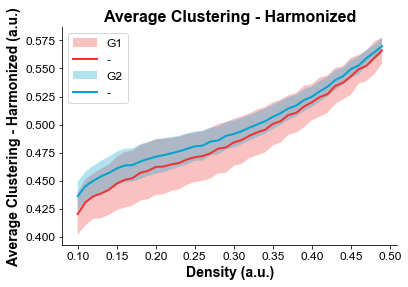

In [429]:
df_epilepsy_v2 = pd.concat([df_epilepsy_blv2, df_epilepsy_univ2])
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Average Clustering - Harmonized','Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy_v2,'Average Clustering - Harmonized','Bilateral_v2')


Not significant:  2 < 3 , p-value:  0.06893106893106893


array([0.98579111, 0.92756372, 0.89610844, 0.88561925, 0.94134583,
       0.9065757 , 0.97366646, 0.68153086, 0.97958178, 0.80820747,
       0.7782551 , 0.97359581, 0.62260861, 0.89259213, 0.83166776,
       0.97973087, 0.61129527, 0.37902168, 0.01748984, 0.01211292,
       0.31414422, 0.99520992, 0.57429315, 0.5735447 , 0.52619817,
       0.52561303, 0.54172424, 0.3455009 , 0.77994281, 0.63254084,
       0.7294934 , 0.5941624 , 0.32933893, 0.8486706 , 0.66074498,
       0.45124777, 0.42797646, 0.18239566, 0.8447103 , 0.94283005])

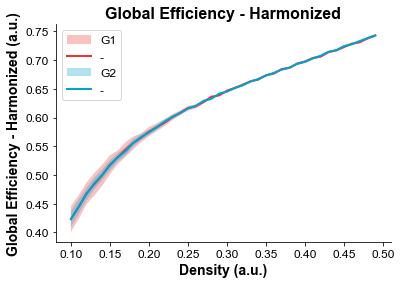

In [430]:
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Global Efficiency - Harmonized','Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy_v2,'Global Efficiency - Harmonized','Bilateral_v2')


Not significant:  0 < 4 , p-value:  0.6043956043956044


array([0.23955035, 0.22607798, 0.37297148, 0.50091496, 0.37351731,
       0.74901086, 0.74851559, 0.57439825, 0.93243049, 0.94058707,
       0.8409351 , 0.80138702, 0.83109058, 0.92021548, 0.81938387,
       0.99722947, 0.70961262, 0.64146237, 0.18153633, 0.13216339,
       0.52868478, 0.91980466, 0.74262758, 0.63486357, 0.48427098,
       0.60125421, 0.49577338, 0.37739112, 0.71038281, 0.62287552,
       0.76558106, 0.60476855, 0.32285274, 0.85180323, 0.66713585,
       0.45000998, 0.42163619, 0.18305513, 0.85471129, 0.9473644 ])

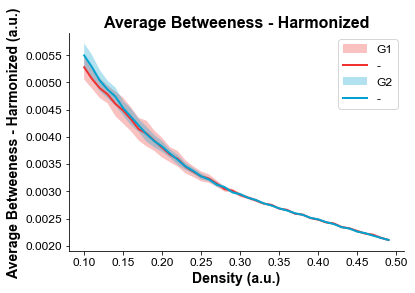

In [421]:
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Average Betweeness - Harmonized','Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy_v2,'Average Betweeness - Harmonized','Bilateral_v2')


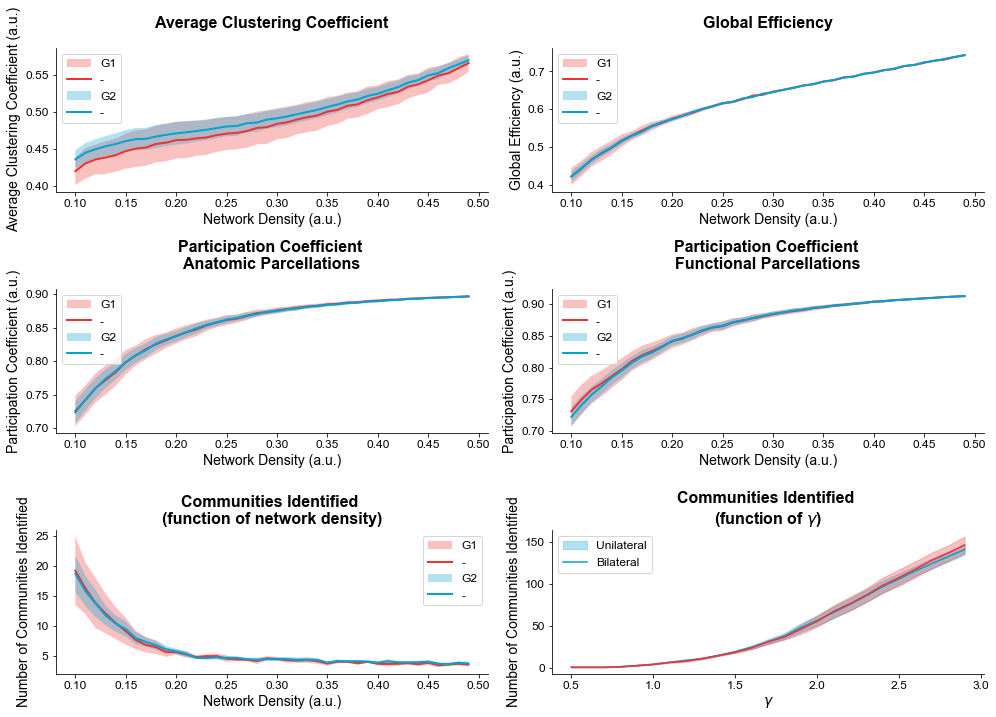

In [422]:
plt.figure(figsize=(14,10))

plt.subplot(3,2,3)
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'PC BNA - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Participation Coefficient \nAnatomic Parcellations', title_params, pad=20)

plt.subplot(3,2,4)
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'PC Yeo7 - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Participation Coefficient \nFunctional Parcellations', title_params, pad=20)

plt.subplot(3,2,1)
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Average Clustering - Harmonized','Bilateral')
plt.ylabel('Average Clustering Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Average Clustering Coefficient', title_params, pad=20)

plt.subplot(3,2,2)
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Global Efficiency - Harmonized','Bilateral')
plt.ylabel('Global Efficiency (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Global Efficiency', title_params, pad=20)

plt.subplot(3,2,5)
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Communities Identified Bin - Harmonized','Bilateral_v2')
plt.title('Communities Identified \n(function of network density)', title_params)
plt.ylabel('Number of Communities Identified', label_params)
plt.xlabel('Network Density (a.u.)', label_params)

plt.subplot(3,2,6)
plot_communities_fill(df_epilepsy_v2,'Communities Identified Di - Harmonized','Bilateral_v2')
plt.title('Communities Identified \n(function of $\gamma$)', title_params)
plt.ylabel('Number of Communities Identified', label_params)
plt.xlabel('$\gamma$', label_params)
plt.tight_layout()

plt.tight_layout()


In [423]:
# Pick sub-groups for subsequent analyses

#df_epilepsy_blv2 = df_epilepsy[ ((df_epilepsy['IEEG']=='IEEG') & (df_epilepsy['Bilateral']==True)) ]

df_epilepsy_blv2 = outcomes[(outcomes['Good_outcome']=='No')]
df_epilepsy_blv2['Bilateral_v2'] = True
df_epilepsy_univ2 = outcomes[(outcomes['Good_outcome']=='Yes')]
df_epilepsy_univ2['Bilateral_v2'] = False

df_epilepsy_v2 = pd.concat([df_epilepsy_blv2, df_epilepsy_univ2])


<ipython-input-423-4e1895d03c9b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epilepsy_blv2['Bilateral_v2'] = True
<ipython-input-423-4e1895d03c9b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epilepsy_univ2['Bilateral_v2'] = False


Significant:  39 > 3 , p-value:  0.005994005994005994


array([0.10256271, 0.02485967, 0.00730677, 0.00489598, 0.00318345,
       0.00180751, 0.00138903, 0.0014359 , 0.00275076, 0.00227748,
       0.00202433, 0.00254813, 0.00320161, 0.00228142, 0.00250153,
       0.00210294, 0.00347599, 0.00298196, 0.00338012, 0.00263994,
       0.00248975, 0.003416  , 0.00274366, 0.00350338, 0.00450263,
       0.0027898 , 0.00508568, 0.00264044, 0.00659645, 0.00274034,
       0.00825137, 0.00523663, 0.0062208 , 0.00438848, 0.00280831,
       0.00840207, 0.00312998, 0.00314605, 0.00387471, 0.00427961])

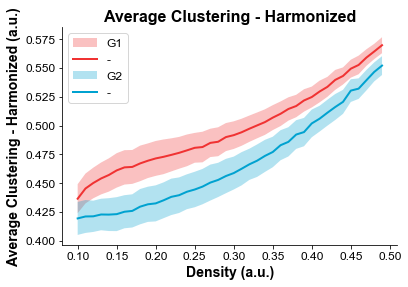

In [406]:
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Average Clustering - Harmonized','Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy_v2,'Average Clustering - Harmonized','Bilateral_v2')


Significant:  15 > 3 , p-value:  0.004995004995004995


array([1.92788514e-04, 2.36661617e-04, 1.11241901e-04, 1.53328204e-04,
       5.08338788e-05, 1.99694753e-04, 7.33126108e-04, 1.38888413e-03,
       1.25444980e-03, 3.47355407e-04, 2.28377487e-04, 1.36333123e-04,
       3.04247463e-04, 5.89075506e-03, 4.11745185e-04, 6.60323775e-02,
       2.36815303e-04, 2.54289656e-02, 3.20163236e-03, 3.04606351e-01,
       2.80571519e-01, 2.87805722e-01, 4.47820208e-01, 8.91118345e-01,
       7.95738417e-01, 2.67218211e-01, 5.67561873e-01, 2.12678588e-01,
       8.90535545e-02, 8.28261247e-02, 1.04256827e-01, 8.03413602e-01,
       6.44898667e-01, 3.43967791e-01, 7.84567712e-01, 2.29999049e-01,
       7.06706793e-01, 8.76561926e-01, 4.13396065e-01, 9.56740890e-01])

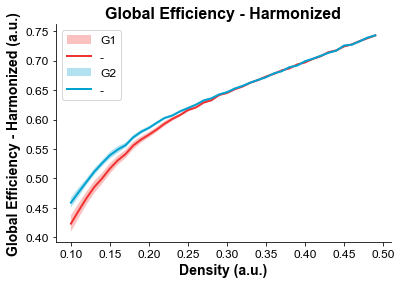

In [407]:
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Global Efficiency - Harmonized','Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy_v2,'Global Efficiency - Harmonized','Bilateral_v2')


Significant:  10 > 4 , p-value:  0.014985014985014986


array([1.70180217e-01, 2.12962776e-01, 8.36506372e-01, 1.85005874e-01,
       1.44307656e-01, 4.12847731e-02, 3.50632213e-02, 7.43594199e-02,
       1.31759718e-02, 9.04289151e-03, 1.12622597e-02, 4.70848742e-03,
       9.23408036e-04, 1.99349079e-02, 7.30503055e-03, 1.96641524e-02,
       1.79712355e-03, 3.66616851e-04, 1.18817884e-01, 1.18653916e-04,
       1.97367673e-01, 5.63448231e-02, 2.76301249e-01, 6.01161779e-01,
       8.94007226e-02, 4.03291946e-01, 8.99451300e-02, 1.48763945e-01,
       4.26618564e-02, 8.75377726e-02, 2.46452107e-01, 7.80082502e-01,
       2.28816153e-01, 6.05325955e-01, 8.74324090e-01, 8.07682883e-02,
       2.45091871e-01, 3.16116175e-01, 4.13817858e-01, 9.86485443e-01])

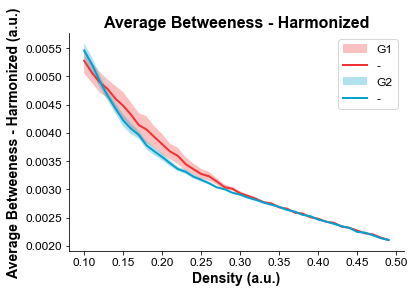

In [397]:
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Average Betweeness - Harmonized','Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy_v2,'Average Betweeness - Harmonized','Bilateral_v2')


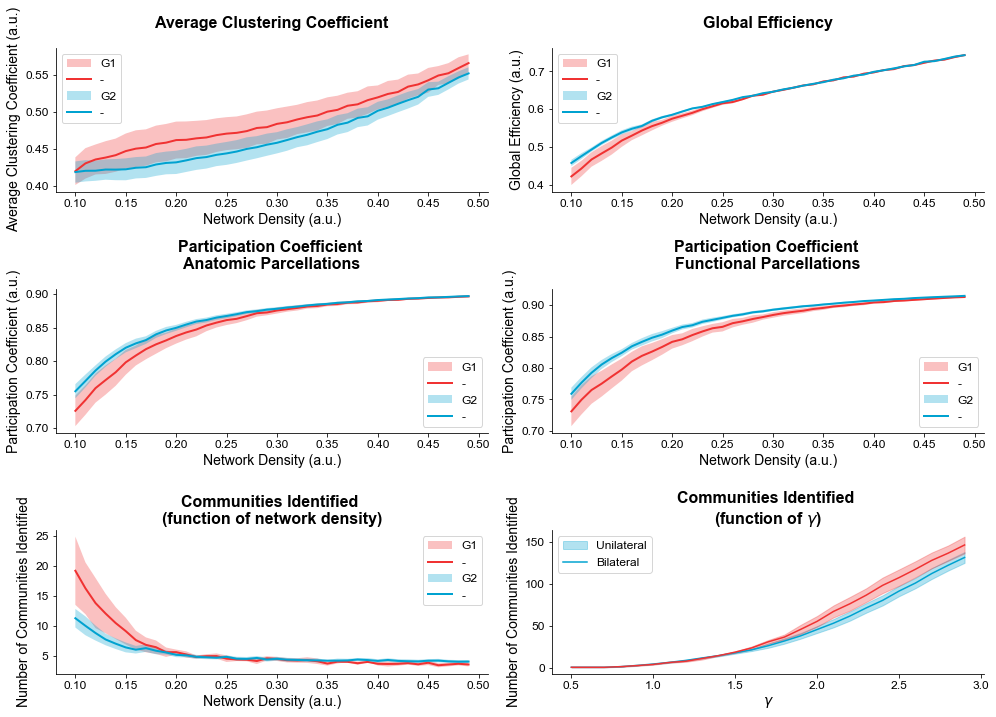

In [398]:
plt.figure(figsize=(14,10))

plt.subplot(3,2,3)
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'PC BNA - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Participation Coefficient \nAnatomic Parcellations', title_params, pad=20)

plt.subplot(3,2,4)
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'PC Yeo7 - Harmonized','Bilateral')
plt.ylabel('Participation Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Participation Coefficient \nFunctional Parcellations', title_params, pad=20)

plt.subplot(3,2,1)
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Average Clustering - Harmonized','Bilateral')
plt.ylabel('Average Clustering Coefficient (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Average Clustering Coefficient', title_params, pad=20)

plt.subplot(3,2,2)
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Global Efficiency - Harmonized','Bilateral')
plt.ylabel('Global Efficiency (a.u.)', label_params)
plt.xlabel('Network Density (a.u.)',label_params)
plt.title('Global Efficiency', title_params, pad=20)

plt.subplot(3,2,5)
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Communities Identified Bin - Harmonized','Bilateral_v2')
plt.title('Communities Identified \n(function of network density)', title_params)
plt.ylabel('Number of Communities Identified', label_params)
plt.xlabel('Network Density (a.u.)', label_params)

plt.subplot(3,2,6)
plot_communities_fill(df_epilepsy_v2,'Communities Identified Di - Harmonized','Bilateral_v2')
plt.title('Communities Identified \n(function of $\gamma$)', title_params)
plt.ylabel('Number of Communities Identified', label_params)
plt.xlabel('$\gamma$', label_params)
plt.tight_layout()

plt.tight_layout()


Significant:  40 > 6 , p-value:  0.000999000999000999


array([3.59867476e-04, 2.45391339e-04, 9.38200115e-05, 3.71433074e-05,
       6.16722508e-05, 9.90977872e-05, 8.11595298e-05, 2.99854430e-04,
       1.42328874e-04, 2.88414348e-04, 5.05568864e-04, 1.55520348e-04,
       4.42789807e-04, 6.57520903e-04, 6.27533302e-04, 4.18380089e-04,
       6.03927117e-04, 4.89016360e-04, 6.37407039e-04, 1.40923930e-03,
       9.45850525e-04, 1.79544428e-03, 3.56353591e-03, 1.47236318e-03,
       4.43080073e-03, 3.36657714e-03, 3.18235941e-03, 2.65347654e-03,
       2.60475227e-03, 2.67165305e-03, 6.63578354e-03, 4.23289913e-03,
       5.92674518e-03, 4.46570209e-03, 2.35346618e-03, 1.74432901e-03,
       5.39766938e-03, 3.44159706e-03, 9.27859251e-03, 1.81420892e-03])

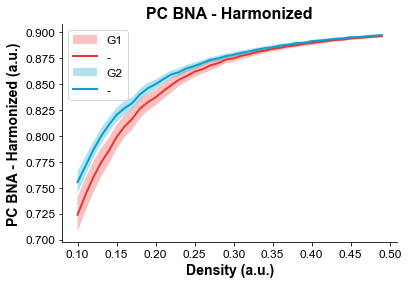

In [410]:
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'PC BNA - Harmonized','Bilateral')
get_suprathreshold_cluster_stat(df_epilepsy_v2,'PC Yeo7 - Harmonized','Bilateral_v2')


Significant:  7 > 3 , p-value:  0.003996003996003996


array([1.87765528e-04, 6.90052462e-04, 8.70018802e-04, 2.46666882e-04,
       3.98883647e-04, 5.02717091e-04, 3.49317143e-03, 6.43856479e-02,
       7.72175314e-02, 1.40195214e-01, 7.64838463e-02, 4.52047849e-01,
       4.36406866e-01, 5.68373512e-01, 7.68379657e-01, 3.47921697e-01,
       5.09970073e-01, 8.36970528e-01, 2.24064995e-01, 7.47547743e-01,
       8.17438011e-01, 7.02590300e-01, 9.82445345e-01, 7.45242097e-01,
       7.52364524e-01, 2.26277786e-02, 7.46757801e-01, 4.69664345e-01,
       1.32162223e-01, 2.35787928e-01, 1.43990240e-01, 3.64374042e-01,
       2.30434781e-01, 3.60566795e-01, 4.90392825e-01, 3.86390475e-01,
       1.58094772e-02, 1.03236236e-02, 3.68291109e-01, 1.23127155e-01])

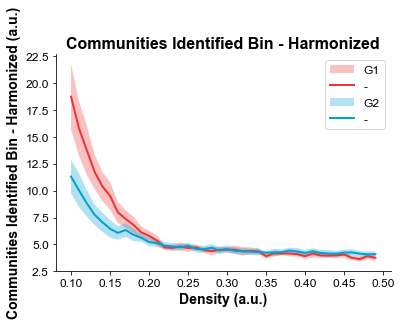

In [412]:
plot_metrics(df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==True)], df_epilepsy_v2[(df_epilepsy_v2['Bilateral_v2']==False)],'Communities Identified Bin - Harmonized','Bilateral_v2')
get_suprathreshold_cluster_stat(df_epilepsy_v2,'Communities Identified Bin - Harmonized','Bilateral_v2')